# Customer Review Analysis

In [1]:
#importing packages
#basics
import pandas as pd 
import numpy as np
#import pandas_profiling

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
#from wordcloud import WordCloud

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE,SelectKBest,f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import textblob
import xgboost
from textblob import TextBlob, Word

C:\Users\jubin\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data=pd.read_excel("Womens Clothing Reviews Data.xlsx").convert_dtypes()

### Basic Data Audit

In [3]:
data.head()

,Product ID,Category,Subcategory1,SubCategory2,Location,Channel,Customer Age,Review Title,Review Text,Rating,Recommend Flag
0,767,Initmates,Intimate,Intimates,Mumbai,Mobile,33,<NA>,Absolutely wonderful - silky and sexy and comf...,4,1
1,1080,General,Dresses,Dresses,Bangalore,Mobile,34,<NA>,Love this dress! it's sooo pretty. i happene...,5,1
2,1077,General,Dresses,Dresses,Gurgaon,Mobile,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0
3,1049,General Petite,Bottoms,Pants,Chennai,Web,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,847,General,Tops,Blouses,Bangalore,Web,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1


In [4]:
data.tail()

,Product ID,Category,Subcategory1,SubCategory2,Location,Channel,Customer Age,Review Title,Review Text,Rating,Recommend Flag
23481,1104,General Petite,Dresses,Dresses,Gurgaon,Mobile,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1
23482,862,General Petite,Tops,Knits,Gurgaon,Web,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1
23483,1104,General Petite,Dresses,Dresses,Gurgaon,Web,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0
23484,1084,General,Dresses,Dresses,Gurgaon,Web,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1
23485,1104,General Petite,Dresses,Dresses,Chennai,Mobile,52,Please make more like this one!,This dress in a lovely platinum is feminine an...,5,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product ID      23486 non-null  Int64 
 1   Category        23472 non-null  string
 2   Subcategory1    23472 non-null  string
 3   SubCategory2    23472 non-null  string
 4   Location        23486 non-null  string
 5   Channel         23486 non-null  string
 6   Customer Age    23486 non-null  Int64 
 7   Review Title    19676 non-null  string
 8   Review Text     22641 non-null  string
 9   Rating          23486 non-null  Int64 
 10  Recommend Flag  23486 non-null  Int64 
dtypes: Int64(4), string(7)
memory usage: 2.1 MB


In [6]:
#checking missing value
data.isna().sum()

Product ID           0
Category            14
Subcategory1        14
SubCategory2        14
Location             0
Channel              0
Customer Age         0
Review Title      3810
Review Text        845
Rating               0
Recommend Flag       0
dtype: int64

In [7]:
#checking dupliccates
data.duplicated().sum()

3

In [8]:
data.shape

(23486, 11)

### Basic Data Preparation

In [3]:
#Renaming the columsns by replacing space with underscore
data.columns = [ i.replace(' ', '_') for i in data.columns]

In [4]:
#dropping duplicates
data.drop_duplicates(inplace=True)

In [5]:
#missing value treatment
data=data[~data.Review_Text.isna()] #dropping all the rows with no review text as they can't be imputed
data=data[(~data.Category.isna())&(~data.Subcategory1 .isna())&(~data.SubCategory2 .isna())] # these 14 missing values for these 3 columns are in the same row
data.Review_Title.fillna('',inplace=True) # title and text are gonna be combined 

In [6]:
#combing reivew title with review text
data['Review_combined']=data['Review_Title'] + data['Review_Text']

In [7]:
#making age groups 
data['age_grp']=np.where(data.Customer_Age<=25,'youth',np.where(data.Customer_Age<=64,'adults','elderly'))

In [8]:
yelp=data.drop(columns=['Review_Title','Product_ID','Review_Text'])

In [9]:
yelp['rating_sentiment']=np.where(yelp.Rating>=4,'positive','negative')

### Data audit

In [17]:
yelp.head()

,Category,Subcategory1,SubCategory2,Location,Channel,Customer_Age,Rating,Recommend_Flag,Review_combined,age_grp,rating_sentiment
0,Initmates,Intimate,Intimates,Mumbai,Mobile,33,4,1,Absolutely wonderful - silky and sexy and comf...,adults,positive
1,General,Dresses,Dresses,Bangalore,Mobile,34,5,1,Love this dress! it's sooo pretty. i happene...,adults,positive
2,General,Dresses,Dresses,Gurgaon,Mobile,60,3,0,Some major design flawsI had such high hopes f...,adults,negative
3,General Petite,Bottoms,Pants,Chennai,Web,50,5,1,"My favorite buy!I love, love, love this jumpsu...",adults,positive
4,General,Tops,Blouses,Bangalore,Web,47,5,1,Flattering shirtThis shirt is very flattering ...,adults,positive


In [18]:
yelp.Rating.value_counts()

5    12527
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: Int64

In [19]:
yelp.Recommend_Flag.value_counts()

1    18527
0     4101
Name: Recommend_Flag, dtype: Int64

In [20]:
yelp.Category.value_counts()

General           13365
General Petite     7837
Initmates          1426
Name: Category, dtype: Int64

In [21]:
yelp.Subcategory1.value_counts()

Tops        10048
Dresses      6145
Bottoms      3662
Intimate     1653
Jackets      1002
Trend         118
Name: Subcategory1, dtype: Int64

In [22]:
yelp.SubCategory2.value_counts()

Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1104
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               332
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: SubCategory2, dtype: Int64

In [23]:
yelp.Location.value_counts()

Gurgaon      8486
Mumbai       6856
Bangalore    5048
Chennai      2238
Name: Location, dtype: Int64

In [24]:
yelp.Channel.value_counts()

Web       13090
Mobile     9538
Name: Channel, dtype: Int64

In [25]:
yelp.Customer_Age.value_counts()

39    1225
35     851
36     799
34     765
38     751
      ... 
93       2
90       2
86       2
99       2
92       1
Name: Customer_Age, Length: 77, dtype: Int64

### Basic Exploratory Analysis

In [ ]:
df=yelp.copy()
df['count_sent']=df['Review_combined'].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df["Review_combined"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["Review_combined"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["Review_combined"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] =df["Review_combined"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["Review_combined"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["Review_combined"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["Review_combined"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
#df["count_stopwords"] = df["Review_combined"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#Average length of the words
df["mean_word_len"] = df["Review_combined"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['Review_combined'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['Review_combined'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['Review_combined'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['Review_combined'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['Review_combined'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['Review_combined'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['Review_combined'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['Review_combined'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['Review_combined'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count']  = df['Review_combined'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count']  = df['Review_combined'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['Review_combined'].apply(lambda x: check_pos_tag(x, 'pron')) 

In [ ]:
df[df.columns.difference(list(yelp.columns))].head()

,Spaces,adj_count,adv_count,alphabetetics,alphanumeric,count_letters,count_punctuations,count_sent,count_unique_word,count_word,...,count_words_upper,mean_word_len,noun_count,numeric,pron_count,verb_count,word_density,wordcounts,words_ends_with_et,words_start_with_no
0,0,2,1,7,7,53,1,1,7,8,...,0,5.750000,2,0,0,0,5.888889,"{'and': 2, 'sexy': 1, 'comfortable': 1, 'silky...",0,0
1,0,8,5,51,51,303,13,1,47,62,...,0,3.822581,14,0,6,15,4.809524,"{'sooo': 1, 'and': 2, 'bought': 1, 'knee.': 1,...",0,0
2,0,23,10,88,88,523,14,1,73,101,...,0,4.188119,19,0,6,13,5.127451,"{'and': 3, 'initially': 1, 'to': 2, 'several':...",1,1
3,0,3,0,14,14,140,10,1,22,24,...,0,4.875000,8,0,4,7,5.600000,"{'and': 1, 'favorite': 1, 'great': 1, 'complim...",1,1
4,0,4,3,34,34,208,5,1,29,37,...,0,4.648649,8,0,3,7,5.473684,"{'and': 1, 'all': 1, 'flattering': 1, 'to': 3,...",0,0


#### Sentiment Analysis Lexican Approach

In [10]:
#Getting stop words from nltk package
stop = set(nltk.corpus.stopwords.words('english'))

#Abbrevations and Words correction
def clean_text(text):
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    text = text.replace('/','')                                          
    text = re.sub(r'[0-9]+', '', text)  
    text = text.lower()
    text = text.strip()
    return(text)

In [11]:
yelp['review']=yelp.Review_combined.apply(lambda x: clean_text(x))

In [12]:
import string
def pre_process(text):
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS']))
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
    text = text.apply(lambda x: re.sub("  "," ", x)) 
    return(text)


In [13]:
yelp['review'] = pre_process(yelp.review)

In [14]:
yelp['sentiment_score'] =  yelp.review.apply(lambda x: TextBlob(x).sentiment.polarity)

In [15]:
yelp['sentiment'] = np.where(yelp.sentiment_score>0.05,'Positive',np.where(yelp.sentiment_score<-0.05, 'Negative', 'Neutral'))

In [16]:
pd.crosstab(yelp.Rating, yelp.sentiment)

sentiment,Negative,Neutral,Positive
Rating,,,
1,194,162,465
2,203,289,1057
3,233,433,2157
4,161,433,4314
5,176,609,11742


In [17]:
Positive_review = yelp.review[yelp.Rating>=4]
Negative_review = yelp.review[yelp.Rating<4]

In [18]:
#Adding more words to the stop words for better analysis from the wordcloud
stop1 = set(list(stop)+['got','one','get','would','make','also','give'])

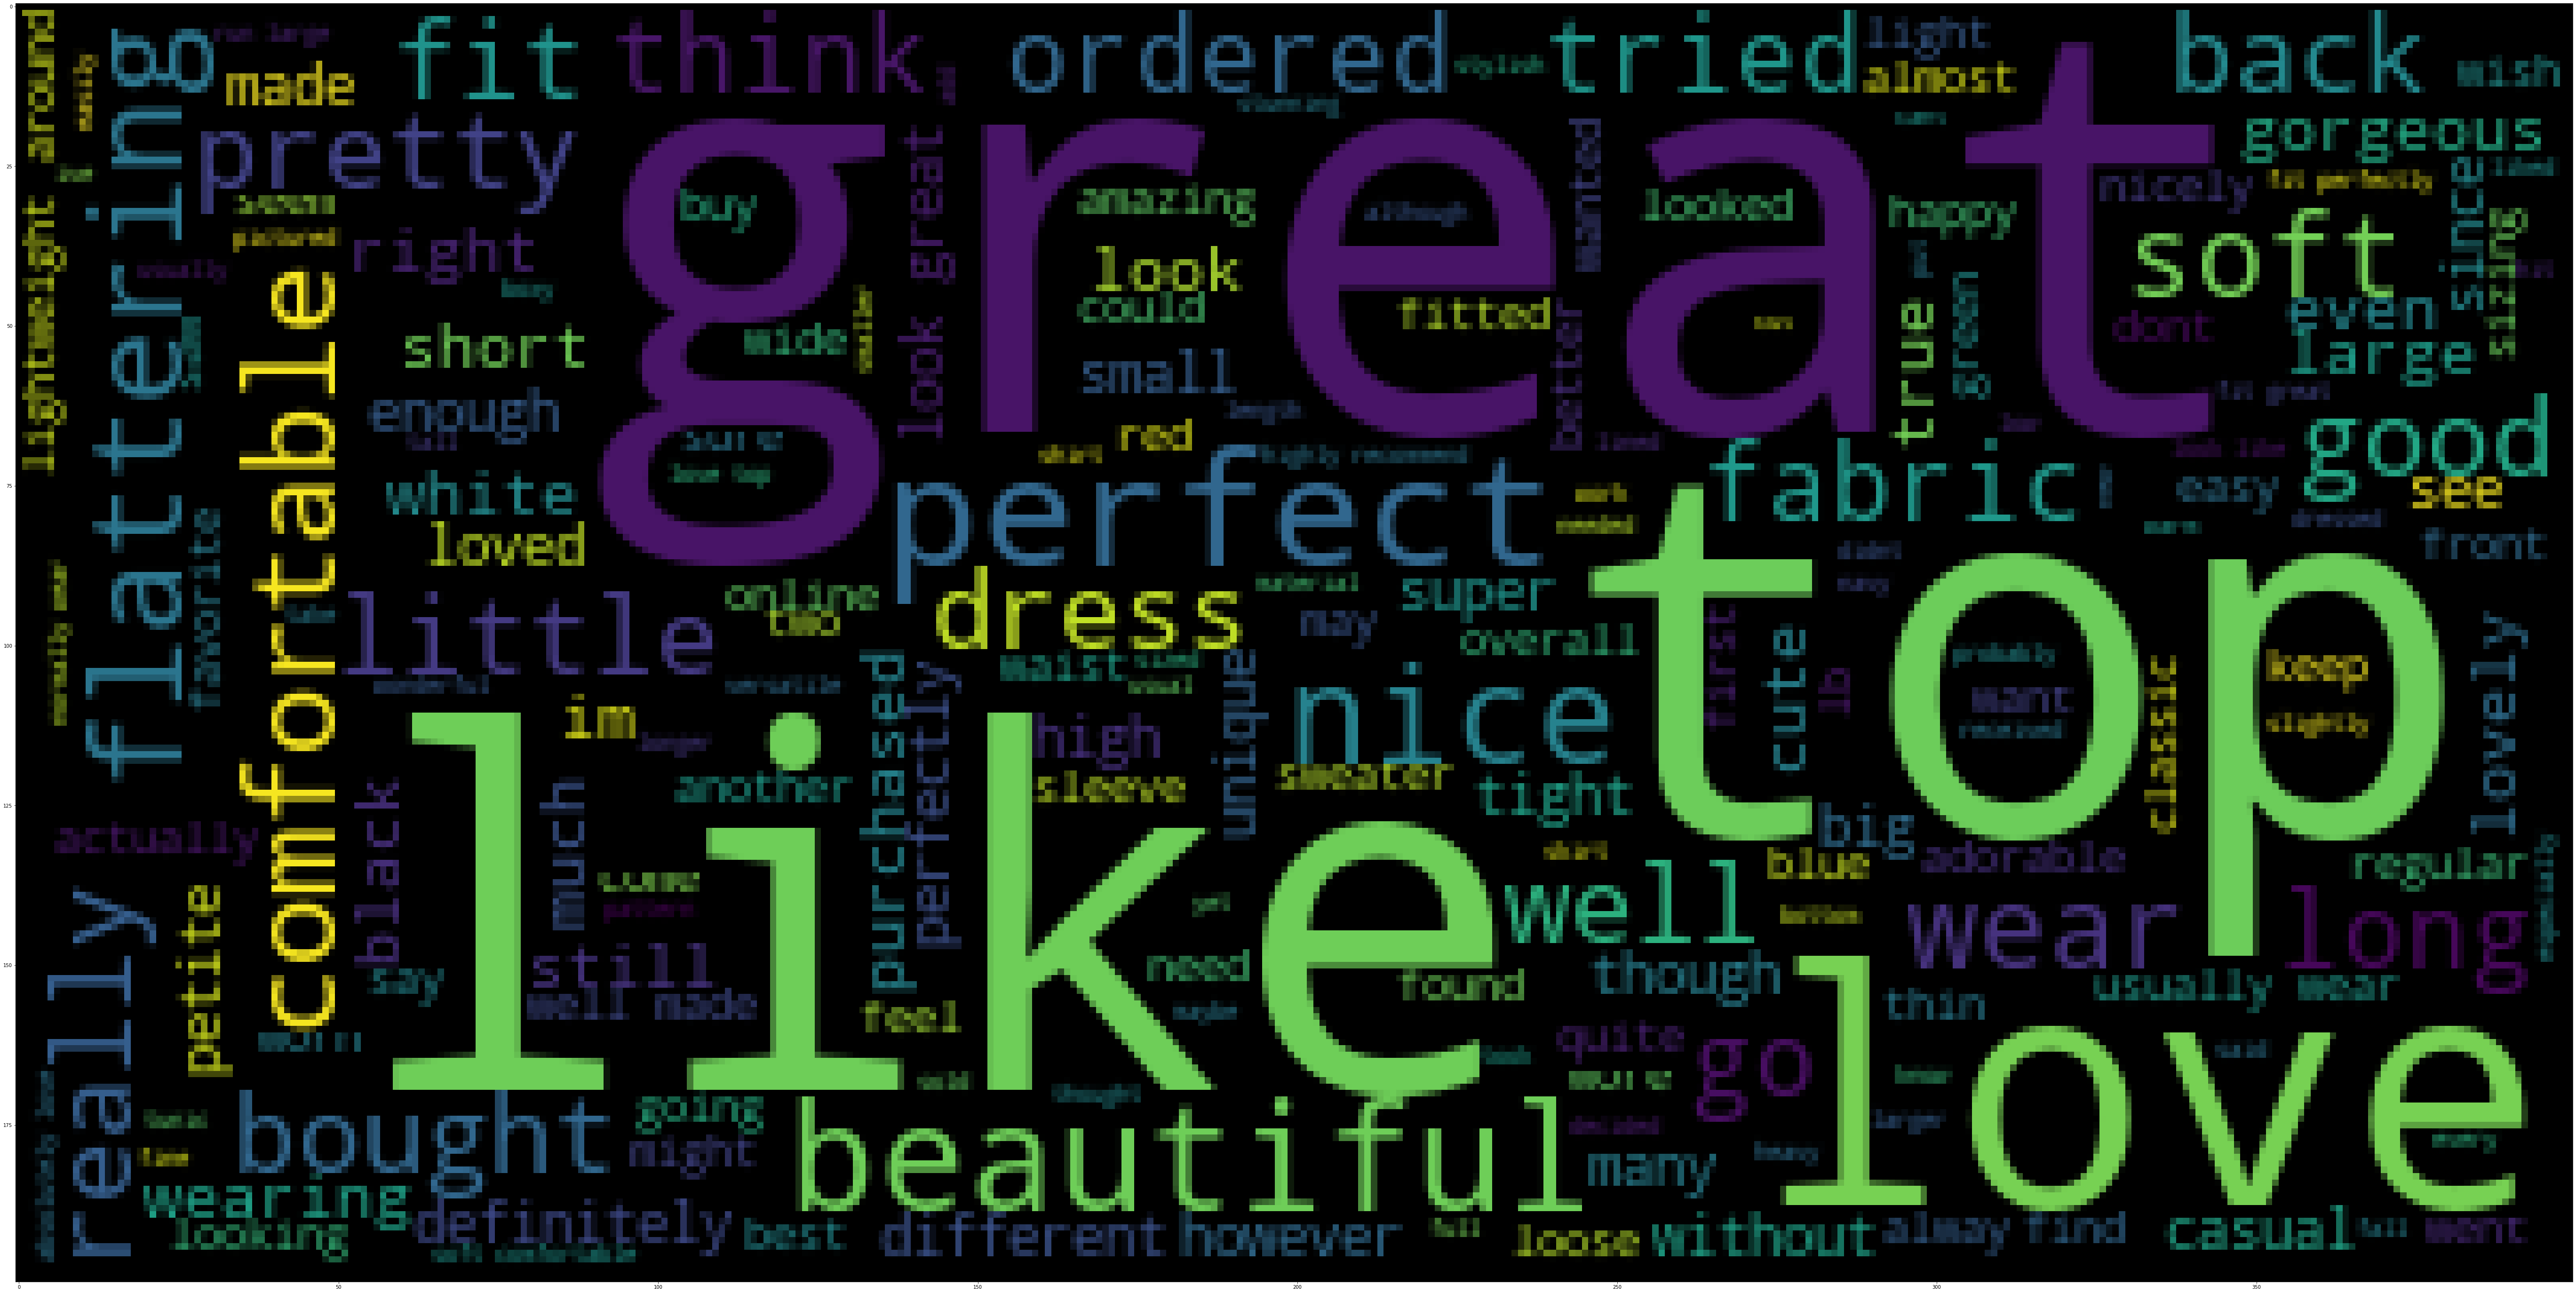

In [ ]:
#positive review wordcloud
wordcloud = WordCloud(stopwords=stop1).generate(' '.join(Positive_review.tolist()))
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

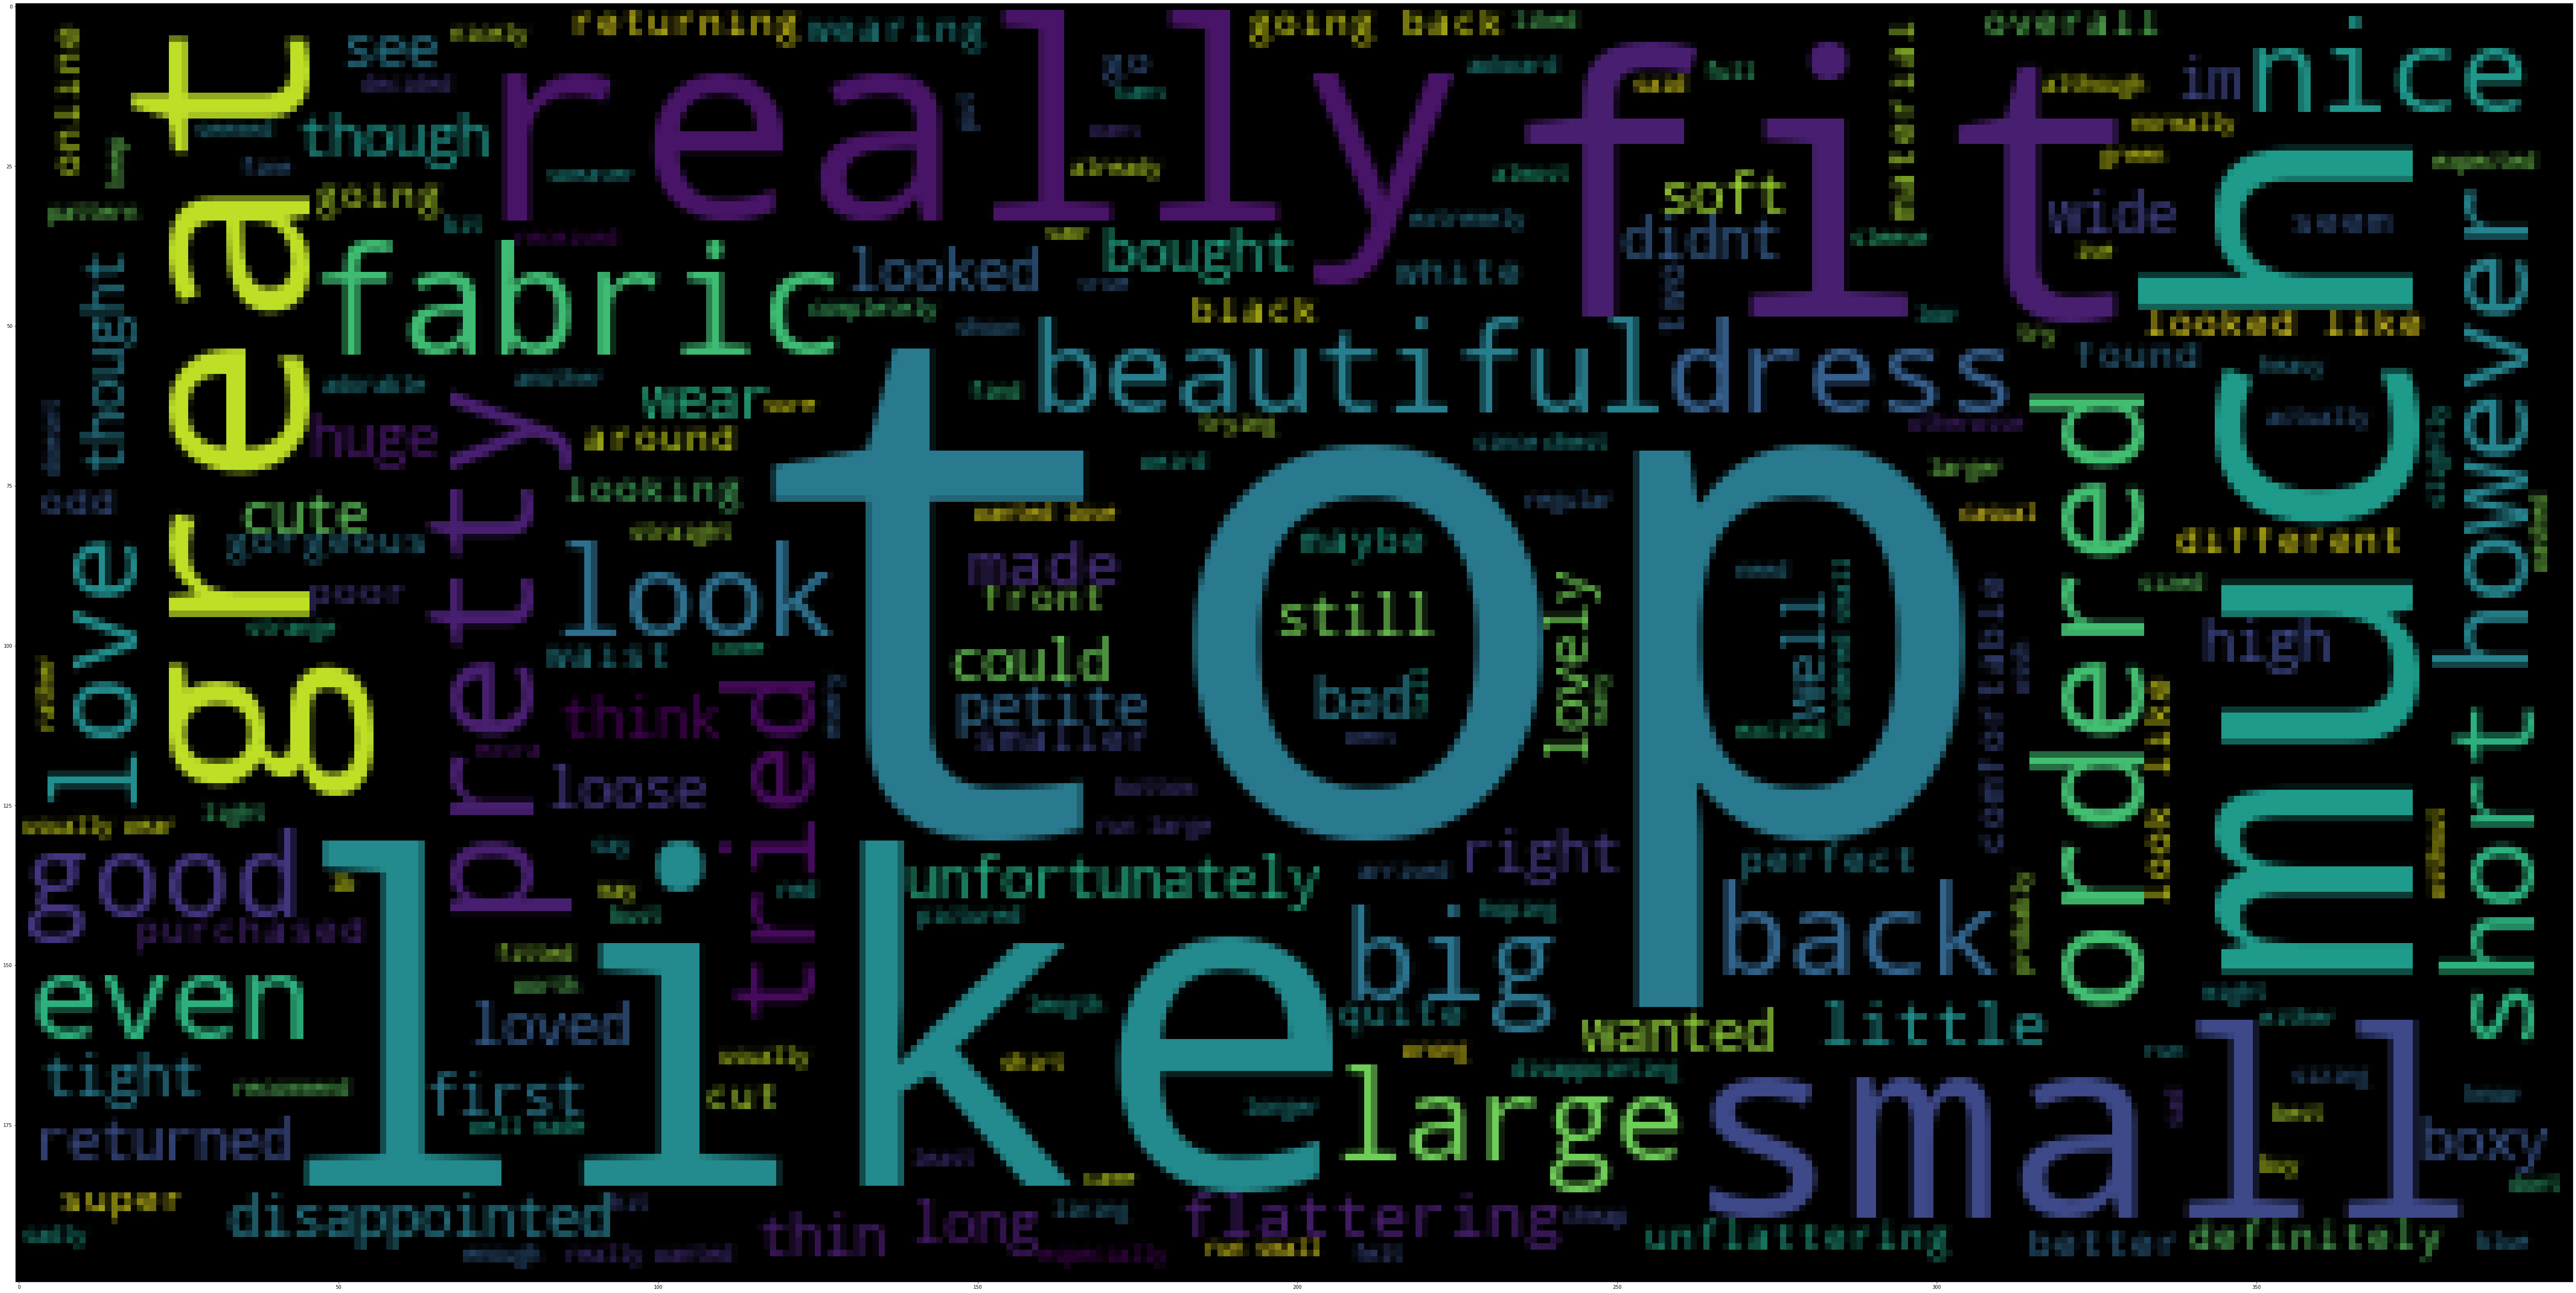

In [ ]:
#negative reviwe wordcloud
wordcloud = WordCloud(stopwords=stop1).generate(' '.join(Negative_review.tolist()))
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

<AxesSubplot:xlabel='rating_sentiment'>

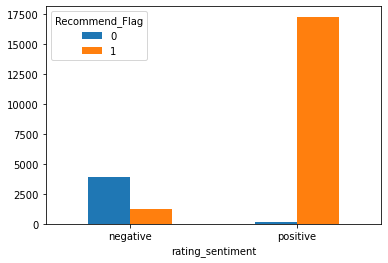

In [18]:
#relation between rating and recommendation
pd.crosstab(yelp.rating_sentiment,yelp.Recommend_Flag).plot.bar(rot=0)

<AxesSubplot:xlabel='sentiment'>

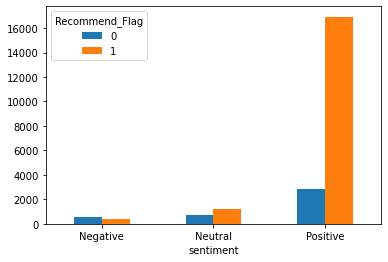

In [20]:
#relation between sentiment and Recommendtion
pd.crosstab(yelp.sentiment,yelp.Recommend_Flag).plot.bar(rot=0)

<AxesSubplot:xlabel='Category'>

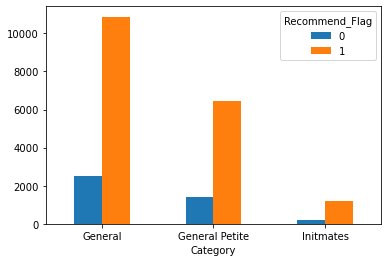

In [19]:
#relation between sentiment and Recommendtion
pd.crosstab(yelp.Category,yelp.Recommend_Flag).plot.bar(rot=0)

<AxesSubplot:xlabel='Category'>

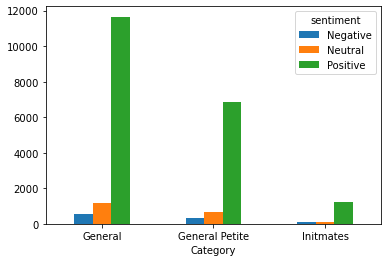

In [34]:
#relation between Category and sentiment
pd.crosstab(yelp.Category,yelp.sentiment).plot.bar(rot=0)

<AxesSubplot:xlabel='Subcategory1'>

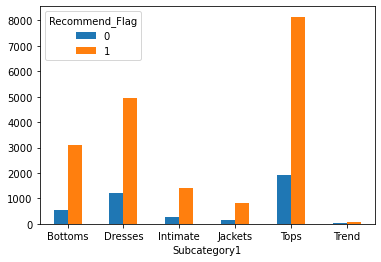

In [33]:
#relation between Subcategory1 and Recommendtion
pd.crosstab(yelp.Subcategory1,yelp.Recommend_Flag).plot.bar(rot=0)

<AxesSubplot:xlabel='Subcategory1'>

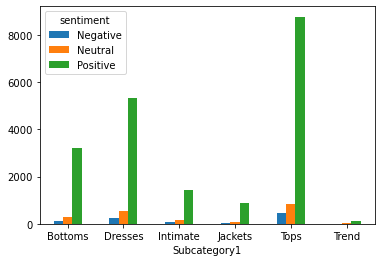

In [32]:
#relation between Subcategory1 and sentiment
pd.crosstab(yelp.Subcategory1,yelp.sentiment).plot.bar(rot=0)

<AxesSubplot:xlabel='SubCategory2'>

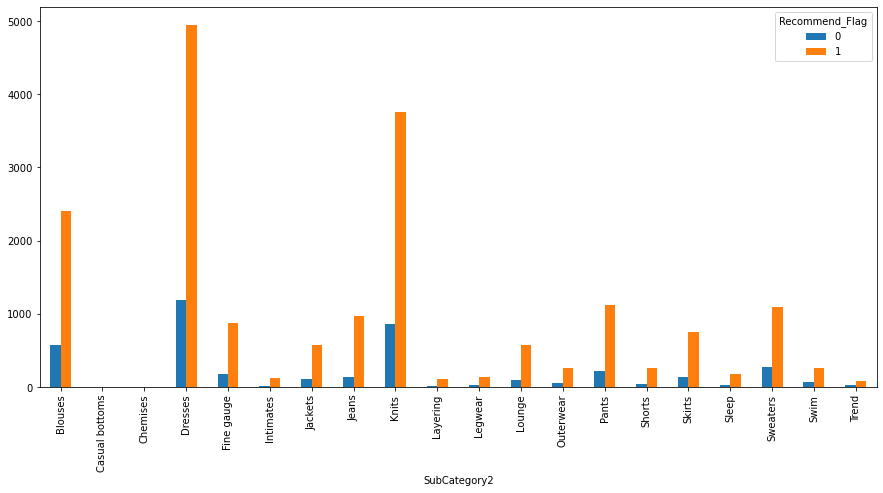

In [31]:
#relation between SubCategory2 and Recommendtion
pd.crosstab(yelp.SubCategory2,yelp.Recommend_Flag).plot(figsize=(15,7),kind='bar')

<AxesSubplot:xlabel='SubCategory2'>

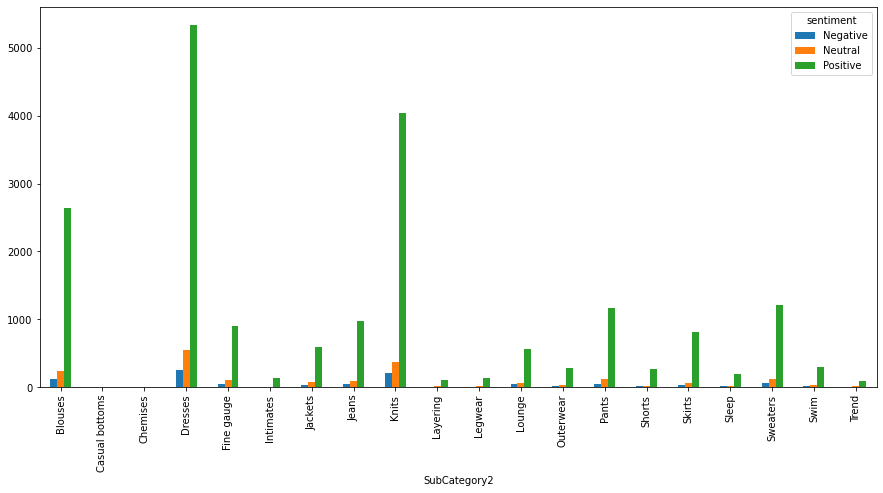

In [30]:
#relation between SubCategory2 and sentiment
pd.crosstab(yelp.SubCategory2,yelp.sentiment).plot(figsize=(15,7),kind='bar')

<AxesSubplot:xlabel='Channel'>

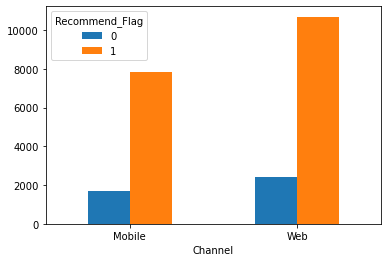

In [23]:
#relation between Channel and Recommendtion
pd.crosstab(yelp.Channel,yelp.Recommend_Flag).plot.bar(rot=0)

<AxesSubplot:xlabel='Channel'>

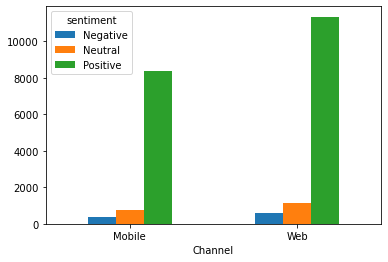

In [22]:
#relation between Channel and sentiment
pd.crosstab(yelp.Channel,yelp.sentiment).plot.bar(rot=0)

<AxesSubplot:xlabel='age_grp'>

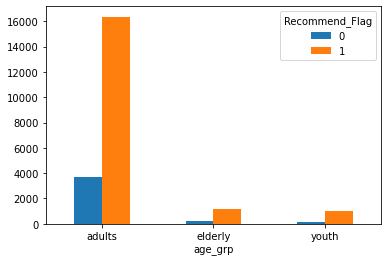

In [21]:
#relation between age group and Recommendtion
pd.crosstab(yelp.age_grp,yelp.Recommend_Flag).plot.bar(rot=0)

<AxesSubplot:xlabel='age_grp'>

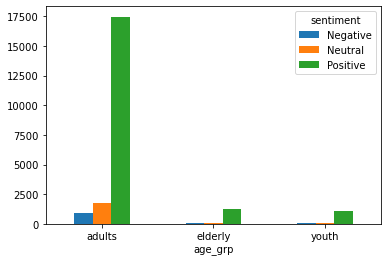

In [20]:
#relation between age group and sentiment
pd.crosstab(yelp.age_grp,yelp.sentiment).plot.bar(rot=0)

## Classification

#### Data preparation for classification

In [32]:
#dealing with multinomial data
df=pd.get_dummies(yelp,columns=['Category','Subcategory1','SubCategory2','Location'],drop_first=True)

In [33]:
#dealing with binomial
df['Channel']=np.where(df.Channel=='Mobile',1,0)

In [34]:
#dropping created columns
df.drop(columns=['Review_combined','age_grp','rating_sentiment','sentiment_score','sentiment'],inplace=True)

### Making a model to classify between reviews that lead to reocmmendation or not.

In [35]:
X_var=df[df.columns.difference(['Recommend_Flag','Rating'])]
Y_var=df.Recommend_Flag.astype('int')

In [36]:
#train test split
train_X, test_X, train_y, test_y = train_test_split(X_var, Y_var, test_size=0.3, random_state=123)

In [37]:
#dtm
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             max_df=0.9, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)

In [38]:
X_train_tfidf = tfidf_vect.fit_transform(train_X.review)
X_test_tfidf = tfidf_vect.transform(test_X.review)

In [39]:
dtm_tfidf_train=pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names(),index=train_X.index)
dtm_tfidf_test=pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vect.get_feature_names(),index=test_X.index)

C:\Users\jubin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jubin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
train_X=train_X[train_X.columns.difference(['review'])].join(dtm_tfidf_train)
test_X=test_X[test_X.columns.difference(['review'])].join(dtm_tfidf_test)

### SVM

In [43]:
from sklearn.svm import LinearSVC
lsvc_model = LinearSVC(C=1.0,dual=False).fit(train_X,train_y) 

In [49]:
#train
print(metrics.classification_report(train_y, lsvc_model.predict(train_X)))

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      2934
           1       0.92      0.96      0.94     12905

    accuracy                           0.91     15839
   macro avg       0.86      0.81      0.83     15839
weighted avg       0.90      0.91      0.90     15839



In [50]:
print(metrics.classification_report(test_y, lsvc_model.predict(test_X)))

              precision    recall  f1-score   support

           0       0.71      0.59      0.65      1167
           1       0.92      0.95      0.93      5622

    accuracy                           0.89      6789
   macro avg       0.81      0.77      0.79      6789
weighted avg       0.88      0.89      0.88      6789



### Random Forest

In [51]:
model=RandomForestClassifier()
model.fit(train_X,train_y)

RandomForestClassifier()

In [52]:
#train
print(metrics.classification_report(train_y, model.predict(train_X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2934
           1       1.00      1.00      1.00     12905

    accuracy                           1.00     15839
   macro avg       1.00      1.00      1.00     15839
weighted avg       1.00      1.00      1.00     15839



In [53]:
#test
print(metrics.classification_report(test_y, model.predict(test_X)))

              precision    recall  f1-score   support

           0       0.75      0.40      0.52      1167
           1       0.89      0.97      0.93      5622

    accuracy                           0.87      6789
   macro avg       0.82      0.68      0.72      6789
weighted avg       0.86      0.87      0.86      6789



## Segmentation

### K-means Clusturing

#### Data preparation for K-means

In [135]:
df.review

0                   absolutely wonderful silky comfortable
1        love pretty happened find never would ordered ...
2        major flawsi high dress really wanted initiall...
3                favorite flirty fabulous every wear great
4        flattering flattering due adjustable perfect w...
                               ...                        
23481    great many occasionsi happy great easy flatter...
23482    wish made reminds soft stretchy shiny flatteri...
23483    see throughthis fit well top never would worke...
23484    perfect wei bought wedding unfortunately fit p...
23485    please make like onethis lovely platinum femin...
Name: review, Length: 22628, dtype: object

In [145]:
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             max_df=0.9, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)

In [148]:
df_tfidf = tfidf_vect.fit_transform(df.review)
df_tfidf=pd.DataFrame(df_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

C:\Users\jubin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [150]:
df_tfidf.head()

,_xd_,able,absolutely,across,actual,actually,add,added,adding,additional,...,xsmall,xx,yellow,yes,yet,young,youre,zip,zipped,zipper
0,0.0,0.0,0.43022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247398,0.0,0.211312
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [151]:
from sklearn.cluster import KMeans
sc_score = []

for i in range(3,20):
    model = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1,random_state=5)
    res = model.fit(df_tfidf)
    score = metrics.silhouette_score(df_tfidf, res.labels_)
    print('cluster-', i, score)
    sc_score.append(score)

cluster- 3 0.005780844359142264
cluster- 4 0.006973442792441188
cluster- 5 0.00784075513053298
cluster- 6 0.007606767838544419
cluster- 7 0.007928283769350949
cluster- 8 0.008728052239499915
cluster- 9 0.009192435864509319
cluster- 10 0.009668614846603961
cluster- 11 0.009656734157491723
cluster- 12 0.010026350313373036
cluster- 13 0.009953114811753927
cluster- 14 0.009776228156854506
cluster- 15 0.009672669793893751
cluster- 16 0.01021490998550977
cluster- 17 0.010582290361383449
cluster- 18 0.010070581138178332
cluster- 19 0.010538577270455703


In [152]:
#taking k=12 as it has the highest score
model = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1,random_state=5)
res = model.fit(df_tfidf)

In [153]:
sse_err = []
cluster_centers = np.array(res.cluster_centers_)
cluster_centers

array([[1.41953662e-03, 4.74223538e-03, 6.28960861e-03, ...,
        1.39616110e-03, 4.35836676e-04, 1.31005779e-03],
       [2.53302964e-03, 4.09879821e-03, 6.02531553e-03, ...,
        2.38524478e-18, 2.80497407e-04, 1.19944278e-03],
       [1.40692330e-03, 5.20901414e-03, 3.15772042e-03, ...,
        8.03469505e-04, 3.69964758e-04, 1.17859907e-03],
       ...,
       [1.98340580e-03, 4.14359073e-03, 1.33119995e-02, ...,
        9.66687590e-04, 5.19401011e-04, 5.34819813e-04],
       [3.22308508e-03, 5.28652196e-03, 5.63212074e-03, ...,
        2.18864000e-04, 6.89993916e-04, 1.77298924e-03],
       [2.18493983e-03, 4.98409892e-03, 2.18840664e-02, ...,
        1.21927788e-03, 2.16019674e-04, 3.36191436e-03]])

In [154]:
np.array(tfidf_vect.get_feature_names())

C:\Users\jubin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['_xd_', 'able', 'absolutely', 'across', 'actual', 'actually',
       'add', 'added', 'adding', 'additional', 'adjustable', 'adorable',
       'adore', 'afraid', 'ag', 'ago', 'agree', 'airy', 'aline', 'allow',
       'allows', 'almost', 'alone', 'along', 'already', 'also', 'altered',
       'alternative', 'although', 'always', 'amazing', 'amazingly',
       'ankle', 'another', 'anyway', 'anywhere', 'apart', 'appear',
       'appeared', 'appears', 'appreciate', 'appropriate', 'arent', 'arm',
       'armhole', 'around', 'arrived', 'asked', 'asymmetrical',
       'athletic', 'attached', 'attractive', 'available', 'average',
       'avoid', 'aware', 'away', 'awesome', 'awful', 'awkward', 'b',
       'baby', 'back', 'bad', 'badly', 'baggy', 'barely', 'based',
       'basic', 'basically', 'bathing', 'bc', 'beading', 'beautiful',
       'beautifully', 'become', 'behind', 'beige', 'believe', 'belly',
       'belt', 'belted', 'best', 'better', 'beyond', 'big', 'bigger',
       'biggest', 

In [155]:
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
vocab = np.array(tfidf_vect.get_feature_names())

In [156]:
#top 20 words for all the segments
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-20:]]))
    print('Impo Words related seg:', i)
    print(vocab[sorted_vals[i][-20:]])
words=list(words)
words

Impo Words related seg: 0
['normally' 'bought' 'im' 'well' 'still' 'love' 'bit' 'top' 'like' 'great'
 'big' 'fit' 'usually' 'little' 'small' 'would' 'wear' 'ordered' 'run'
 'large']
Impo Words related seg: 1
['small' 'fabric' 'cute' 'ordered' 'soft' 'well' 'fit' 'flattering' 'one'
 'back' 'pretty' 'little' 'much' 'would' 'look' 'wear' 'love' 'great'
 'like' 'top']
Impo Words related seg: 2
['would' 'fabric' 'ordered' 'love' 'long' 'got' 'true' 'like' 'casual'
 'go' 'little' 'bought' 'flattering' 'well' 'wear' 'soft' 'look'
 'comfortable' 'fit' 'great']
Impo Words related seg: 3
['pretty' 'even' 'long' 'good' 'bought' 'dress' 'ordered' 'well' 'soft'
 'much' 'little' 'comfortable' 'look' 'back' 'flattering' 'fit' 'wear'
 'one' 'would' 'like']
Impo Words related seg: 4
['also' 'nice' 'perfect' 'got' 'back' 'fit' 'ordered' 'would' 'love'
 'look' 'blue' 'little' 'one' 'wear' 'bought' 'top' 'great' 'like' 'black'
 'white']
Impo Words related seg: 5
['could' 'tight' 'petite' 'got' 'one' 'love

['great',
 'normally',
 'wear',
 'got',
 'dress',
 'fabric',
 'bought',
 'gorgeous',
 'large',
 'white',
 'like',
 'extra',
 'petite',
 'many',
 'absolutely',
 'true',
 'run',
 'even',
 'im',
 'blue',
 'look',
 'tight',
 'nice',
 'well',
 'small',
 'really',
 'perfectly',
 'cute',
 'long',
 'perfect',
 'super',
 'short',
 'beautiful',
 'would',
 'little',
 'casual',
 'ordered',
 'good',
 'fit',
 'bit',
 'pretty',
 'much',
 'also',
 'wanted',
 'love',
 'black',
 'usually',
 'back',
 'could',
 'flattering',
 'made',
 'one',
 'top',
 'soft',
 'comfortable',
 'still',
 'big',
 'go']

## Text Mining

In [20]:
df.review

0                   absolutely wonderful silky comfortable
1        love pretty happened find never would ordered ...
2        major flawsi high dress really wanted initiall...
3                favorite flirty fabulous every wear great
4        flattering flattering due adjustable perfect w...
                               ...                        
23481    great many occasionsi happy great easy flatter...
23482    wish made reminds soft stretchy shiny flatteri...
23483    see throughthis fit well top never would worke...
23484    perfect wei bought wedding unfortunately fit p...
23485    please make like onethis lovely platinum femin...
Name: review, Length: 22628, dtype: object

In [25]:
#dtm
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             max_df=0.9, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)

In [26]:
vect = tfidf_vect.fit_transform(df.review)

In [27]:
vect=pd.DataFrame(vect.toarray(), columns=tfidf_vect.get_feature_names(),index=df.index)

C:\Users\jubin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
vect

,_xd_,able,absolutely,across,actual,actually,add,added,adding,additional,...,xsmall,xx,yellow,yes,yet,young,youre,zip,zipped,zipper
0,0.0,0.000000,0.43022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247398,0.0,0.211312
3,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23481,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
23482,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
23483,0.0,0.350594,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
23484,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [31]:
import gensim
from gensim import corpora

In [32]:
df_token= [doc.split() for doc in df.review] 

In [33]:
df_token

[['absolutely', 'wonderful', 'silky', 'comfortable'],
 ['love',
  'pretty',
  'happened',
  'find',
  'never',
  'would',
  'ordered',
  'online',
  'bought',
  'petite',
  'hit',
  'little',
  'would',
  'definitely',
  'true',
  'truly',
  'petite'],
 ['major',
  'flawsi',
  'high',
  'dress',
  'really',
  'wanted',
  'initially',
  'ordered',
  'petite',
  'small',
  'usual',
  'found',
  'outrageously',
  'small',
  'small',
  'could',
  'zip',
  'reordered',
  'petite',
  'ok',
  'overall',
  'top',
  'comfortable',
  'fit',
  'nicely',
  'bottom',
  'tight',
  'layer',
  'several',
  'somewhat',
  'cheap',
  'net',
  'imo',
  'major',
  'directly',
  'zipper'],
 ['favorite', 'flirty', 'fabulous', 'every', 'wear', 'great'],
 ['flattering',
  'flattering',
  'due',
  'adjustable',
  'perfect',
  'wear',
  'pair',
  'well',
  'cardigan',
  'love'],
 ['love',
  'reese',
  'dress',
  'one',
  'petite',
  'tall',
  'usually',
  'wear',
  'p',
  'pretty',
  'long',
  'full',
  'overwhe

In [34]:
dictionary = corpora.Dictionary(df_token)
print(dictionary)

Dictionary<15742 unique tokens: ['absolutely', 'comfortable', 'silky', 'wonderful', 'bought']...>


In [36]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df_token]

In [37]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [54]:
#finding number of topics with the least perplexity
for i in range(8,21):
    ldamodel = Lda(doc_term_matrix, num_topics=i, id2word = dictionary)
    print('num_topics--> {}'.format(i))
    print("Perplexity: ", ldamodel.log_perplexity(doc_term_matrix))
    print('---------------------------------------------------------------')
    

num_topics--> 8
Perplexity:  -7.190948719880485
---------------------------------------------------------------
num_topics--> 9
Perplexity:  -7.28506360604993
---------------------------------------------------------------
num_topics--> 10
Perplexity:  -7.38870827746613
---------------------------------------------------------------
num_topics--> 11
Perplexity:  -7.513555668461233
---------------------------------------------------------------
num_topics--> 12
Perplexity:  -7.633790800095267
---------------------------------------------------------------
num_topics--> 13
Perplexity:  -7.718300992127523
---------------------------------------------------------------
num_topics--> 14
Perplexity:  -7.775408237139755
---------------------------------------------------------------
num_topics--> 15
Perplexity:  -7.85177471267162
---------------------------------------------------------------
num_topics--> 16
Perplexity:  -7.908192771884986
----------------------------------------------------

In [38]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary)

In [39]:
print("Perplexity: ", ldamodel.log_perplexity(doc_term_matrix))

Perplexity:  -7.393144696845296


In [40]:
print(ldamodel.print_topics(num_topics=10, num_words=20))

[(0, '0.052*"love" + 0.031*"great" + 0.019*"perfect" + 0.016*"flattering" + 0.015*"beautiful" + 0.015*"soft" + 0.012*"gorgeous" + 0.011*"fabric" + 0.010*"wear" + 0.010*"bought" + 0.010*"fit" + 0.010*"well" + 0.010*"absolutely" + 0.009*"top" + 0.009*"make" + 0.009*"comfortable" + 0.008*"lovely" + 0.008*"long" + 0.008*"true" + 0.008*"little"'), (1, '0.018*"wear" + 0.017*"petite" + 0.017*"would" + 0.016*"long" + 0.015*"soft" + 0.015*"fit" + 0.011*"like" + 0.011*"perfect" + 0.011*"regular" + 0.010*"flattering" + 0.010*"love" + 0.010*"comfortable" + 0.010*"one" + 0.008*"perfectly" + 0.008*"great" + 0.007*"&" + 0.007*"im" + 0.007*"tried" + 0.007*"even" + 0.007*"much"'), (2, '0.020*"ordered" + 0.019*"worth" + 0.019*"like" + 0.017*"one" + 0.014*"bought" + 0.012*"first" + 0.012*"full" + 0.012*"beautiful" + 0.012*"really" + 0.011*"cute" + 0.011*"little" + 0.009*"usual" + 0.008*"top" + 0.008*"received" + 0.008*"run" + 0.008*"loved" + 0.008*"true" + 0.008*"small" + 0.007*"wearing" + 0.007*"poor"')

In [41]:
topics = ldamodel.show_topics(formatted=False, num_words=20)
    
for t in range(len(topics)):
    print("\nTopic {}, top {} words:".format(t+1,20))
    print(" ".join([w[0] for w in topics[t][1]]))


Topic 1, top 20 words:
love great perfect flattering beautiful soft gorgeous fabric wear bought fit well absolutely top make comfortable lovely long true little

Topic 2, top 20 words:
wear petite would long soft fit like perfect regular flattering love comfortable one perfectly great & im tried even much

Topic 3, top 20 words:
ordered worth like one bought first full beautiful really cute little usual top received run loved true small wearing poor

Topic 4, top 20 words:
great comfortable love wear perfect bought well fit top little black look soft one casual got white like flattering super

Topic 5, top 20 words:
top beautiful long got short back small fit one wide great little gorgeous look loved good would fabric wear pretty

Topic 6, top 20 words:
surprised got basic pleasantly inside coral cuter comfortable wear ordered must soft cozy meant unexpected simply see dressy casual top

Topic 7, top 20 words:
like back tight little beautiful would small fabric fit sent bad waist dres

In [42]:
# printing the topic associaltions with the documents
count = 0
for i in ldamodel[doc_term_matrix]:
    print("doc : ",count,i)
    count += 1

doc :  0 [(0, 0.6291489), (1, 0.020005627), (2, 0.020002358), (3, 0.02000782), (4, 0.020002767), (5, 0.020003606), (6, 0.21081822), (7, 0.020006314), (8, 0.020002026), (9, 0.020002339)]
doc :  1 [(0, 0.31829178), (1, 0.34160155), (2, 0.30120653)]
doc :  2 [(0, 0.2708098), (1, 0.24902906), (8, 0.28212702), (9, 0.18169108)]
doc :  3 [(0, 0.014290681), (1, 0.0142900385), (2, 0.014288882), (3, 0.69711673), (4, 0.014288767), (5, 0.014288613), (6, 0.014288923), (7, 0.18857011), (8, 0.014288245), (9, 0.014289049)]
doc :  4 [(0, 0.9181624)]
doc :  5 [(0, 0.4897301), (1, 0.18849194), (5, 0.06713278), (9, 0.22583123)]
doc :  6 [(8, 0.5072741), (9, 0.44778287)]
doc :  7 [(4, 0.1302765), (5, 0.32624882), (8, 0.52232164)]
doc :  8 [(0, 0.42036405), (9, 0.50688434)]
doc :  9 [(0, 0.110375665), (1, 0.35232306), (9, 0.50546235)]
doc :  10 [(2, 0.16710933), (6, 0.1263093), (8, 0.5022057), (9, 0.17935173)]
doc :  11 [(0, 0.69991136), (1, 0.033342365), (2, 0.03333958), (3, 0.033340927), (4, 0.0333445), (

doc :  236 [(0, 0.010021591), (1, 0.4426733), (2, 0.010022566), (3, 0.28923595), (4, 0.010021144), (5, 0.19794594), (6, 0.010018235), (7, 0.010020467), (8, 0.010021095), (9, 0.010019675)]
doc :  237 [(7, 0.06700739), (9, 0.8758352)]
doc :  238 [(5, 0.04467654), (7, 0.2766913), (8, 0.65605694)]
doc :  239 [(0, 0.016669359), (1, 0.016669665), (2, 0.4672695), (3, 0.016668433), (4, 0.016670574), (5, 0.016669117), (6, 0.016670596), (7, 0.016675554), (8, 0.016672147), (9, 0.399365)]
doc :  240 [(1, 0.14341427), (3, 0.41785857), (8, 0.40538055)]
doc :  241 [(0, 0.58647853), (1, 0.011113387), (2, 0.01111396), (3, 0.011114907), (4, 0.011114411), (5, 0.01111281), (6, 0.20671044), (7, 0.011114012), (8, 0.011115023), (9, 0.12901254)]
doc :  242 [(2, 0.7656537), (7, 0.20100164)]
doc :  243 [(3, 0.9470409)]
doc :  244 [(3, 0.08944499), (7, 0.8378068)]
doc :  245 [(7, 0.92522204)]
doc :  246 [(3, 0.5653015), (8, 0.40969014)]
doc :  247 [(7, 0.9549832)]
doc :  248 [(6, 0.21961018), (8, 0.707634)]
doc 

doc :  382 [(1, 0.3625472), (8, 0.58019114)]
doc :  383 [(1, 0.22488114), (3, 0.08082093), (8, 0.67171776)]
doc :  384 [(0, 0.46329), (1, 0.11572886), (3, 0.36723024)]
doc :  385 [(0, 0.49546462), (7, 0.4545378)]
doc :  386 [(1, 0.13064867), (8, 0.8121806)]
doc :  387 [(8, 0.8196994), (9, 0.15529794)]
doc :  388 [(3, 0.5024162), (4, 0.42487502)]
doc :  389 [(1, 0.6533376), (3, 0.23589858), (9, 0.082752965)]
doc :  390 [(0, 0.29177865), (1, 0.14218552), (8, 0.53266144)]
doc :  391 [(0, 0.2470136), (1, 0.7057726)]
doc :  392 [(1, 0.74067366), (3, 0.12616204), (8, 0.10398839)]
doc :  393 [(1, 0.91831493)]
doc :  394 [(0, 0.262269), (3, 0.3645251), (7, 0.28673384), (9, 0.06504462)]
doc :  395 [(4, 0.65976936), (7, 0.2902168)]
doc :  396 [(0, 0.165964), (6, 0.29844862), (9, 0.50643396)]
doc :  397 [(3, 0.22988617), (7, 0.50339144), (9, 0.22553389)]
doc :  398 [(0, 0.011114415), (1, 0.011114043), (2, 0.011114764), (3, 0.8999738), (4, 0.011112746), (5, 0.011112547), (6, 0.011113578), (7, 0.01

doc :  524 [(3, 0.44845143), (8, 0.48903975)]
doc :  525 [(0, 0.8499662), (1, 0.016669374), (2, 0.016669253), (3, 0.01667044), (4, 0.016676093), (5, 0.016668307), (6, 0.01666886), (7, 0.01667047), (8, 0.01667025), (9, 0.01667071)]
doc :  526 [(8, 0.94711053)]
doc :  527 [(2, 0.19309407), (6, 0.6079539), (7, 0.17094089)]
doc :  528 [(0, 0.020003611), (1, 0.020004181), (2, 0.020002505), (3, 0.8199735), (4, 0.020004267), (5, 0.02000169), (6, 0.020000953), (7, 0.020001285), (8, 0.020005219), (9, 0.02000273)]
doc :  529 [(0, 0.012501502), (1, 0.012501537), (2, 0.012501329), (3, 0.012501597), (4, 0.012502626), (5, 0.012501712), (6, 0.012501784), (7, 0.012502234), (8, 0.012502127), (9, 0.8874836)]
doc :  530 [(3, 0.36904377), (8, 0.60237306)]
doc :  531 [(2, 0.13824545), (4, 0.80444705)]
doc :  532 [(8, 0.9307521)]
doc :  533 [(0, 0.14621066), (1, 0.0100032175), (2, 0.010003975), (3, 0.41011775), (4, 0.01000234), (5, 0.010001481), (6, 0.01000193), (7, 0.010003423), (8, 0.37365267), (9, 0.0100

doc :  638 [(0, 0.01113999), (1, 0.011139454), (2, 0.011138579), (3, 0.75932497), (4, 0.011138606), (5, 0.011139037), (6, 0.011138689), (7, 0.0111392895), (8, 0.15156257), (9, 0.01113882)]
doc :  639 [(4, 0.25271827), (8, 0.6901718)]
doc :  640 [(0, 0.011118039), (1, 0.287286), (2, 0.0111149885), (3, 0.011118118), (4, 0.011115882), (5, 0.0111142425), (6, 0.011114464), (7, 0.0111154355), (8, 0.32502833), (9, 0.30987448)]
doc :  641 [(1, 0.3149078), (8, 0.65308326)]
doc :  642 [(2, 0.3076519), (3, 0.38931566), (9, 0.27258474)]
doc :  643 [(3, 0.83578247), (7, 0.09784046)]
doc :  644 [(1, 0.24811302), (7, 0.24061227), (8, 0.47625905)]
doc :  645 [(2, 0.27621484), (8, 0.69871134)]
doc :  646 [(1, 0.031551816), (3, 0.19411892), (8, 0.75010926)]
doc :  647 [(1, 0.70488334), (8, 0.23782043)]
doc :  648 [(0, 0.012513849), (1, 0.01251361), (2, 0.012517202), (3, 0.5484063), (4, 0.012513344), (5, 0.012512608), (6, 0.012512355), (7, 0.012513791), (8, 0.35148343), (9, 0.012513544)]
doc :  649 [(8, 

doc :  750 [(1, 0.15050109), (7, 0.77697104)]
doc :  751 [(0, 0.42325625), (1, 0.011105754), (2, 0.48789194), (3, 0.01110843), (4, 0.011108581), (5, 0.011105625), (6, 0.011104711), (7, 0.011106063), (8, 0.011106915), (9, 0.011105777)]
doc :  752 [(3, 0.38652378), (5, 0.11705033), (8, 0.44261184)]
doc :  753 [(3, 0.34038192), (8, 0.6262725)]
doc :  754 [(1, 0.63017595), (3, 0.066105686), (4, 0.082628846), (6, 0.08944276), (9, 0.114900984)]
doc :  755 [(4, 0.72324055), (8, 0.15834954), (9, 0.0958197)]
doc :  756 [(0, 0.059056465), (7, 0.06971684), (8, 0.84527236)]
doc :  757 [(1, 0.17310704), (2, 0.6050014), (3, 0.078758456), (4, 0.12244258)]
doc :  758 [(0, 0.30878136), (4, 0.13606183), (8, 0.5271917)]
doc :  759 [(0, 0.9099626), (1, 0.010004738), (2, 0.010003357), (3, 0.010004171), (4, 0.010005716), (5, 0.010002976), (6, 0.010003405), (7, 0.010003324), (8, 0.01000512), (9, 0.010004548)]
doc :  760 [(3, 0.46265367), (8, 0.5053342)]
doc :  761 [(0, 0.7378763), (3, 0.23134406)]
doc :  762

doc :  907 [(0, 0.07651383), (1, 0.1391313), (4, 0.16691045), (8, 0.49908456), (9, 0.10168785)]
doc :  908 [(1, 0.20250052), (9, 0.7641819)]
doc :  909 [(3, 0.35742664), (6, 0.12833859), (8, 0.37039763), (9, 0.11531066)]
doc :  910 [(0, 0.69613475), (1, 0.011110231), (2, 0.011108547), (3, 0.011110087), (4, 0.011109019), (5, 0.011110766), (6, 0.01110818), (7, 0.011109703), (8, 0.21499054), (9, 0.0111081675)]
doc :  911 [(2, 0.91780293)]
doc :  912 [(0, 0.92515504)]
doc :  913 [(0, 0.58414245), (1, 0.011113713), (2, 0.32693368), (3, 0.011114518), (4, 0.0111136045), (5, 0.011113522), (6, 0.011119403), (7, 0.011116976), (8, 0.011113259), (9, 0.011118906)]
doc :  914 [(2, 0.2503682), (8, 0.7229514)]
doc :  915 [(1, 0.540559), (7, 0.27330813), (9, 0.16050626)]
doc :  916 [(0, 0.15104857), (5, 0.50596637), (7, 0.31704825)]
doc :  917 [(0, 0.2605604), (3, 0.33819962), (5, 0.10231092), (7, 0.2527618)]
doc :  918 [(8, 0.43804437), (9, 0.51491433)]
doc :  919 [(8, 0.5528603), (9, 0.40498722)]
doc

doc :  1028 [(2, 0.56053495), (3, 0.33775157), (8, 0.0725078)]
doc :  1029 [(1, 0.28038737), (4, 0.69379747)]
doc :  1030 [(0, 0.21159975), (5, 0.16645746), (8, 0.5901459)]
doc :  1031 [(0, 0.2754831), (1, 0.1604723), (7, 0.39209953), (8, 0.1497273)]
doc :  1032 [(3, 0.31156418), (4, 0.3229265), (8, 0.31167132)]
doc :  1033 [(0, 0.2037816), (6, 0.13477124), (9, 0.6373013)]
doc :  1034 [(1, 0.62015796), (3, 0.3226769)]
doc :  1035 [(2, 0.17579332), (3, 0.5105126), (5, 0.26374486)]
doc :  1036 [(0, 0.959075)]
doc :  1037 [(3, 0.55861634), (4, 0.4022858)]
doc :  1038 [(7, 0.79793245), (8, 0.17767261)]
doc :  1039 [(1, 0.45739812), (8, 0.48920536)]
doc :  1040 [(0, 0.012860881), (1, 0.01285676), (2, 0.012860267), (3, 0.611012), (4, 0.012860628), (5, 0.012858893), (6, 0.012857003), (7, 0.012857049), (8, 0.012858783), (9, 0.28611776)]
doc :  1041 [(1, 0.4095461), (3, 0.5332869)]
doc :  1042 [(1, 0.65574837), (2, 0.31455305)]
doc :  1043 [(0, 0.6482287), (8, 0.31472576)]
doc :  1044 [(4, 0.77

doc :  1154 [(0, 0.11783133), (7, 0.18354638), (9, 0.6717063)]
doc :  1155 [(1, 0.5855137), (5, 0.050366145), (9, 0.34151706)]
doc :  1156 [(1, 0.527144), (5, 0.3096868), (6, 0.1049891)]
doc :  1157 [(2, 0.08830772), (3, 0.85834295)]
doc :  1158 [(0, 0.13717726), (8, 0.7680346), (9, 0.06786221)]
doc :  1159 [(1, 0.36579615), (8, 0.25832033), (9, 0.34088883)]
doc :  1160 [(0, 0.011117563), (1, 0.011115578), (2, 0.2242443), (3, 0.47780886), (4, 0.011117306), (5, 0.011115095), (6, 0.22013545), (7, 0.01111645), (8, 0.01111465), (9, 0.011114774)]
doc :  1161 [(0, 0.23572113), (8, 0.732572)]
doc :  1162 [(8, 0.310829), (9, 0.6685999)]
doc :  1163 [(2, 0.3897705), (3, 0.19047785), (7, 0.3959598)]
doc :  1164 [(2, 0.9584645)]
doc :  1165 [(1, 0.62017787), (3, 0.31313586)]
doc :  1166 [(7, 0.19652757), (8, 0.76711124)]
doc :  1167 [(2, 0.7548398), (6, 0.06411624), (8, 0.15983722)]
doc :  1168 [(3, 0.22309457), (4, 0.2614314), (8, 0.48051205)]
doc :  1169 [(6, 0.20888758), (8, 0.67701447), (9, 0

doc :  1273 [(0, 0.011115509), (1, 0.011114528), (2, 0.011114962), (3, 0.37009913), (4, 0.34552848), (5, 0.011113449), (6, 0.011117418), (7, 0.01111593), (8, 0.20656541), (9, 0.011115124)]
doc :  1274 [(0, 0.012504578), (1, 0.012504243), (2, 0.012507921), (3, 0.012506574), (4, 0.012507527), (5, 0.0125063555), (6, 0.15541933), (7, 0.012504135), (8, 0.7445335), (9, 0.012505861)]
doc :  1275 [(0, 0.2708026), (1, 0.010003053), (2, 0.010001798), (3, 0.010003428), (4, 0.010001395), (5, 0.010001343), (6, 0.0100017795), (7, 0.0100019695), (8, 0.6491797), (9, 0.010002939)]
doc :  1276 [(0, 0.016673872), (1, 0.53742343), (2, 0.016672276), (3, 0.016671166), (4, 0.32919917), (5, 0.016670361), (6, 0.016672745), (7, 0.016670886), (8, 0.016672276), (9, 0.016673781)]
doc :  1277 [(0, 0.31862965), (1, 0.20844638), (3, 0.4029745)]
doc :  1278 [(0, 0.012505145), (1, 0.012505711), (2, 0.88745373), (3, 0.012504444), (4, 0.012504746), (5, 0.012503868), (6, 0.0125040095), (7, 0.012503801), (8, 0.012509602), 

doc :  1401 [(7, 0.2617061), (8, 0.36357188), (9, 0.3378754)]
doc :  1402 [(0, 0.4652155), (1, 0.43464053), (2, 0.012518495), (3, 0.0125209605), (4, 0.012517699), (5, 0.012516775), (6, 0.01251729), (7, 0.012518022), (8, 0.012517414), (9, 0.012517309)]
doc :  1403 [(1, 0.4595476), (8, 0.43119907), (9, 0.089239776)]
doc :  1404 [(8, 0.9718573)]
doc :  1405 [(1, 0.5805556), (3, 0.257838), (6, 0.050708678), (9, 0.09155684)]
doc :  1406 [(1, 0.35164505), (6, 0.1352627), (9, 0.481263)]
doc :  1407 [(0, 0.8150685), (7, 0.1404994)]
doc :  1408 [(0, 0.114668), (3, 0.82371026)]
doc :  1409 [(0, 0.010070787), (1, 0.010066876), (2, 0.010068251), (3, 0.90938735), (4, 0.01006834), (5, 0.01006866), (6, 0.010066645), (7, 0.010067869), (8, 0.010067314), (9, 0.010067869)]
doc :  1410 [(0, 0.012502748), (1, 0.01250369), (2, 0.012502692), (3, 0.012502563), (4, 0.18145382), (5, 0.012502799), (6, 0.012503311), (7, 0.7185204), (8, 0.01250489), (9, 0.012503029)]
doc :  1411 [(8, 0.9126055), (9, 0.061576396)]


doc :  1629 [(0, 0.5881744), (4, 0.106924325), (8, 0.27800643)]
doc :  1630 [(0, 0.32679993), (2, 0.6064212)]
doc :  1631 [(0, 0.80078804), (1, 0.1491954)]
doc :  1632 [(2, 0.27171564), (3, 0.24840027), (4, 0.19308536), (5, 0.040276602), (6, 0.23262392)]
doc :  1633 [(1, 0.17111467), (8, 0.7717072)]
doc :  1634 [(0, 0.020007329), (1, 0.020007716), (2, 0.020014137), (3, 0.33892822), (4, 0.020010212), (5, 0.020006439), (6, 0.02000678), (7, 0.020007096), (8, 0.50100327), (9, 0.02000885)]
doc :  1635 [(1, 0.1041413), (9, 0.83170015)]
doc :  1636 [(4, 0.5873169), (9, 0.38981855)]
doc :  1637 [(1, 0.31414035), (5, 0.1362704), (9, 0.49122337)]
doc :  1638 [(0, 0.44139832), (1, 0.3475452), (3, 0.18511885)]
doc :  1639 [(7, 0.06496941), (8, 0.4821413), (9, 0.43167567)]
doc :  1640 [(1, 0.9500297)]
doc :  1641 [(2, 0.31757635), (7, 0.35981384), (8, 0.29512006)]
doc :  1642 [(8, 0.9308053)]
doc :  1643 [(1, 0.42949024), (9, 0.5397481)]
doc :  1644 [(0, 0.012503107), (1, 0.012502716), (2, 0.012504

doc :  1846 [(0, 0.31783274), (3, 0.2599181), (5, 0.1427303), (9, 0.25728568)]
doc :  1847 [(0, 0.016671319), (1, 0.8499571), (2, 0.01667175), (3, 0.016672725), (4, 0.016670037), (5, 0.016670376), (6, 0.016669527), (7, 0.016669724), (8, 0.016675975), (9, 0.016671438)]
doc :  1848 [(7, 0.33119833), (9, 0.6324175)]
doc :  1849 [(3, 0.26424146), (5, 0.110397644), (7, 0.57867897)]
doc :  1850 [(1, 0.6342335), (3, 0.33719727)]
doc :  1851 [(0, 0.3614587), (1, 0.4717282), (5, 0.06596577), (7, 0.07583097)]
doc :  1852 [(0, 0.016673485), (1, 0.8499212), (2, 0.016672472), (3, 0.016674709), (4, 0.016674021), (5, 0.016672134), (6, 0.016681466), (7, 0.016676942), (8, 0.01667659), (9, 0.016676921)]
doc :  1853 [(0, 0.6482584), (1, 0.13265581), (4, 0.1554276)]
doc :  1854 [(0, 0.014291139), (1, 0.8713941), (2, 0.014288968), (3, 0.014290823), (4, 0.0142900655), (5, 0.014287695), (6, 0.01428888), (7, 0.014287698), (8, 0.014292067), (9, 0.014288518)]
doc :  1855 [(1, 0.33874676), (2, 0.088194154), (3, 

doc :  1976 [(1, 0.3002015), (4, 0.67015654)]
doc :  1977 [(0, 0.010005694), (1, 0.7130159), (2, 0.010006197), (3, 0.010005641), (4, 0.010007103), (5, 0.010005525), (6, 0.010005577), (7, 0.010008903), (8, 0.010007809), (9, 0.20693165)]
doc :  1978 [(0, 0.014287825), (1, 0.014287751), (2, 0.014288688), (3, 0.014287909), (4, 0.014290357), (5, 0.014287762), (6, 0.01428982), (7, 0.014291632), (8, 0.8713976), (9, 0.0142906355)]
doc :  1979 [(0, 0.031428207), (1, 0.2856451), (2, 0.11338412), (8, 0.54553777)]
doc :  1980 [(1, 0.42995724), (7, 0.16951993), (8, 0.37551814)]
doc :  1981 [(0, 0.32929125), (3, 0.26200566), (8, 0.3237171), (9, 0.0649638)]
doc :  1982 [(1, 0.109142244), (5, 0.5211129), (6, 0.06820522), (8, 0.27543908)]
doc :  1983 [(7, 0.5405433), (8, 0.42308047)]
doc :  1984 [(0, 0.9307341)]
doc :  1985 [(2, 0.33974278), (9, 0.59356314)]
doc :  1986 [(6, 0.42403018), (8, 0.4161799), (9, 0.1364493)]
doc :  1987 [(1, 0.970007)]
doc :  1988 [(0, 0.3256442), (3, 0.5940656), (5, 0.05335

doc :  2126 [(1, 0.41409457), (4, 0.13823213), (8, 0.4270715)]
doc :  2127 [(0, 0.53950274), (5, 0.41837636)]
doc :  2128 [(7, 0.34877682), (8, 0.6067626)]
doc :  2129 [(0, 0.0124958325), (1, 0.012496833), (2, 0.012498669), (3, 0.012497483), (4, 0.0124977), (5, 0.01249562), (6, 0.01249844), (7, 0.012497853), (8, 0.4509237), (9, 0.4490979)]
doc :  2130 [(2, 0.20640734), (3, 0.29449585), (7, 0.19769788), (9, 0.28070074)]
doc :  2131 [(1, 0.36275044), (8, 0.5572812)]
doc :  2132 [(1, 0.23033023), (4, 0.15219726), (8, 0.5870344)]
doc :  2133 [(0, 0.601275), (1, 0.24401745), (5, 0.12289533)]
doc :  2134 [(0, 0.0125019485), (1, 0.012502579), (2, 0.88747394), (3, 0.012503277), (4, 0.012503499), (5, 0.012500969), (6, 0.012502541), (7, 0.012502057), (8, 0.012506795), (9, 0.0125023965)]
doc :  2135 [(3, 0.49014553), (5, 0.4526957)]
doc :  2136 [(2, 0.15371901), (3, 0.7735404)]
doc :  2137 [(0, 0.3249903), (7, 0.6178748)]
doc :  2138 [(0, 0.02500996), (1, 0.025010737), (2, 0.025021326), (3, 0.025

doc :  2286 [(7, 0.39659366), (9, 0.55635285)]
doc :  2287 [(0, 0.29593337), (3, 0.44757485), (4, 0.06399666), (9, 0.15500769)]
doc :  2288 [(0, 0.016675025), (1, 0.016670363), (2, 0.016669542), (3, 0.84997237), (4, 0.016669022), (5, 0.016668456), (6, 0.016668206), (7, 0.016669782), (8, 0.016668616), (9, 0.01666859)]
doc :  2289 [(3, 0.5235377), (9, 0.4431215)]
doc :  2290 [(1, 0.23942931), (2, 0.14388926), (8, 0.5886411)]
doc :  2291 [(3, 0.53850394), (8, 0.43292972)]
doc :  2292 [(0, 0.8261459), (2, 0.1205668)]
doc :  2293 [(1, 0.34305322), (2, 0.16786328), (3, 0.13451019), (4, 0.1475676), (5, 0.09766917), (6, 0.080798246)]
doc :  2294 [(0, 0.024987463), (1, 0.024988089), (2, 0.024988772), (3, 0.02498975), (4, 0.024987599), (5, 0.024986427), (6, 0.02498736), (7, 0.024986275), (8, 0.7751096), (9, 0.024988715)]
doc :  2295 [(0, 0.012501572), (1, 0.012501515), (2, 0.0125010805), (3, 0.0125029115), (4, 0.012499486), (5, 0.01250009), (6, 0.012499643), (7, 0.012499535), (8, 0.8874937), (9,

doc :  2467 [(3, 0.14780246), (5, 0.15435608), (8, 0.6778389)]
doc :  2468 [(4, 0.40550664), (8, 0.3404027), (9, 0.2152121)]
doc :  2469 [(0, 0.5195543), (8, 0.4232992)]
doc :  2470 [(0, 0.3449104), (1, 0.112535544), (2, 0.11168116), (8, 0.40358678)]
doc :  2471 [(0, 0.24168798), (1, 0.33122286), (3, 0.06711684), (8, 0.3359221)]
doc :  2472 [(0, 0.010008141), (1, 0.01000779), (2, 0.010007583), (3, 0.35847667), (4, 0.010007487), (5, 0.010006887), (6, 0.010007503), (7, 0.01000843), (8, 0.24449115), (9, 0.3269784)]
doc :  2473 [(0, 0.12630439), (6, 0.22152428), (9, 0.61884123)]
doc :  2474 [(0, 0.010001855), (1, 0.010002884), (2, 0.010002452), (3, 0.010002919), (4, 0.010001997), (5, 0.0100010615), (6, 0.010005928), (7, 0.010001481), (8, 0.909977), (9, 0.010002347)]
doc :  2475 [(2, 0.21985522), (6, 0.09632895), (8, 0.38517466), (9, 0.2527504)]
doc :  2476 [(0, 0.2834382), (1, 0.15775959), (2, 0.084538236), (3, 0.12868686), (5, 0.17107035), (8, 0.15636012)]
doc :  2477 [(0, 0.28671318), (8

doc :  2621 [(1, 0.7166561), (2, 0.25574788)]
doc :  2622 [(1, 0.9250177)]
doc :  2623 [(0, 0.65949816), (5, 0.2605567)]
doc :  2624 [(1, 0.47104686), (4, 0.087229766), (7, 0.40668532)]
doc :  2625 [(3, 0.53936803), (8, 0.42421922)]
doc :  2626 [(2, 0.3592376), (3, 0.583599)]
doc :  2627 [(0, 0.011113714), (1, 0.011115298), (2, 0.011113268), (3, 0.011113208), (4, 0.011114886), (5, 0.0111127375), (6, 0.16442338), (7, 0.011112725), (8, 0.74666667), (9, 0.011114129)]
doc :  2628 [(0, 0.010003164), (1, 0.010003685), (2, 0.01000156), (3, 0.010003705), (4, 0.010004929), (5, 0.21677266), (6, 0.0100011695), (7, 0.01000282), (8, 0.010002321), (9, 0.70320404)]
doc :  2629 [(2, 0.2507238), (3, 0.20837215), (5, 0.122770555), (7, 0.39994928)]
doc :  2630 [(1, 0.28476557), (3, 0.14447455), (4, 0.37483156), (5, 0.05287562), (9, 0.122209)]
doc :  2631 [(0, 0.16139284), (3, 0.77193516)]
doc :  2632 [(0, 0.10856818), (3, 0.57118756), (7, 0.2764718)]
doc :  2633 [(2, 0.41181397), (8, 0.5623661)]
doc :  2

doc :  2750 [(1, 0.15488154), (3, 0.50091964), (7, 0.31477034)]
doc :  2751 [(1, 0.16830418), (3, 0.2793539), (4, 0.3710098), (9, 0.1460559)]
doc :  2752 [(1, 0.37243605), (7, 0.20671608), (9, 0.38824528)]
doc :  2753 [(1, 0.19663984), (2, 0.6583045), (3, 0.119139865)]
doc :  2754 [(0, 0.32089484), (3, 0.3938061), (7, 0.09333374), (9, 0.17377818)]
doc :  2755 [(3, 0.041333962), (6, 0.23629995), (8, 0.62958115), (9, 0.070568934)]
doc :  2756 [(0, 0.12252489), (2, 0.45975298), (8, 0.37652487)]
doc :  2757 [(6, 0.20983668), (8, 0.7402049)]
doc :  2758 [(2, 0.48070112), (3, 0.2291702), (5, 0.15277933), (9, 0.09117995)]
doc :  2759 [(0, 0.13497823), (3, 0.49550554), (6, 0.12710656), (8, 0.22475487)]
doc :  2760 [(2, 0.3163232), (3, 0.6415715)]
doc :  2761 [(8, 0.94372284)]
doc :  2762 [(4, 0.14415467), (8, 0.794302)]
doc :  2763 [(2, 0.23826018), (4, 0.3231891), (5, 0.13636768), (7, 0.26885518)]
doc :  2764 [(0, 0.3376553), (4, 0.14113185), (9, 0.48941764)]
doc :  2765 [(0, 0.050023284), (1

doc :  2882 [(3, 0.432247), (8, 0.538111)]
doc :  2883 [(1, 0.73937684), (3, 0.22582753)]
doc :  2884 [(2, 0.51299995), (3, 0.33144322), (7, 0.108887896)]
doc :  2885 [(0, 0.19251488), (1, 0.011116947), (2, 0.011118192), (3, 0.011119106), (4, 0.011114664), (5, 0.011115955), (6, 0.33767268), (7, 0.3919979), (8, 0.011114999), (9, 0.011114646)]
doc :  2886 [(0, 0.025002303), (1, 0.025001207), (2, 0.025002861), (3, 0.025002744), (4, 0.025002789), (5, 0.025001861), (6, 0.025005015), (7, 0.025005935), (8, 0.02500552), (9, 0.77496976)]
doc :  2887 [(3, 0.51580703), (6, 0.1464234), (7, 0.31832147)]
doc :  2888 [(0, 0.21528064), (3, 0.57279325), (4, 0.17886005)]
doc :  2889 [(0, 0.6071065), (3, 0.20490202), (4, 0.15298922)]
doc :  2890 [(3, 0.44514534), (4, 0.19999112), (7, 0.3137025)]
doc :  2891 [(3, 0.62219733), (8, 0.23569639), (9, 0.10523086)]
doc :  2892 [(1, 0.17953196), (2, 0.08926699), (6, 0.05652731), (8, 0.6546641)]
doc :  2893 [(1, 0.108594075), (2, 0.4592908), (4, 0.3737975)]
doc :

doc :  2988 [(1, 0.2048251), (2, 0.03314049), (3, 0.23893297), (8, 0.20619304), (9, 0.3002329)]
doc :  2989 [(3, 0.9181922)]
doc :  2990 [(0, 0.54995626), (1, 0.05000905), (2, 0.050002296), (3, 0.050013006), (4, 0.05000362), (5, 0.050003286), (6, 0.05000212), (7, 0.05000303), (8, 0.050004303), (9, 0.05000304)]
doc :  2991 [(1, 0.49597424), (7, 0.4506162)]
doc :  2992 [(0, 0.30739403), (1, 0.4759578), (5, 0.03384291), (8, 0.16404831)]
doc :  2993 [(2, 0.05909777), (6, 0.2348), (7, 0.08118715), (8, 0.44269344), (9, 0.16435695)]
doc :  2994 [(2, 0.67227024), (5, 0.107411355), (6, 0.1620143)]
doc :  2995 [(2, 0.34994164), (4, 0.18771574), (6, 0.4273478)]
doc :  2996 [(6, 0.15761036), (9, 0.79238826)]
doc :  2997 [(0, 0.07680643), (3, 0.60997254), (7, 0.15533112), (8, 0.13060693)]
doc :  2998 [(0, 0.010003448), (1, 0.43124425), (2, 0.010004186), (3, 0.4887316), (4, 0.010002816), (5, 0.010002695), (6, 0.010002465), (7, 0.010002743), (8, 0.010002828), (9, 0.0100029595)]
doc :  2999 [(2, 0.047

doc :  3109 [(3, 0.33684948), (4, 0.09114689), (7, 0.41572613), (9, 0.13558388)]
doc :  3110 [(2, 0.23204017), (3, 0.48940346), (9, 0.239653)]
doc :  3111 [(0, 0.22398023), (4, 0.316485), (8, 0.41832745)]
doc :  3112 [(3, 0.7493782), (6, 0.17064296)]
doc :  3113 [(3, 0.57186997), (8, 0.4005329)]
doc :  3114 [(3, 0.5986102), (8, 0.36328137)]
doc :  3115 [(1, 0.1808723), (3, 0.16172789), (8, 0.63323784)]
doc :  3116 [(1, 0.11107507), (4, 0.24165191), (8, 0.60051453)]
doc :  3117 [(0, 0.14086035), (1, 0.53313285), (3, 0.054940846), (9, 0.25019133)]
doc :  3118 [(0, 0.61018276), (1, 0.016672648), (2, 0.016669646), (3, 0.016672798), (4, 0.016673617), (5, 0.016669616), (6, 0.016670037), (7, 0.01667092), (8, 0.25644514), (9, 0.016672844)]
doc :  3119 [(1, 0.10909173), (2, 0.543024), (8, 0.29449415), (9, 0.032692473)]
doc :  3120 [(1, 0.1774746), (3, 0.762836), (5, 0.036342043)]
doc :  3121 [(0, 0.0142900385), (1, 0.014289976), (2, 0.014287751), (3, 0.014289325), (4, 0.014286776), (5, 0.014289

doc :  3250 [(0, 0.27993283), (1, 0.26686427), (2, 0.4065213)]
doc :  3251 [(1, 0.06035375), (6, 0.11794909), (8, 0.7805502)]
doc :  3252 [(1, 0.29285), (2, 0.18131882), (3, 0.05134208), (7, 0.14145726), (8, 0.31739894)]
doc :  3253 [(1, 0.11573999), (2, 0.28897), (4, 0.4495618), (8, 0.115692034)]
doc :  3254 [(3, 0.924982)]
doc :  3255 [(0, 0.0142879095), (1, 0.014289278), (2, 0.014288658), (3, 0.5740393), (4, 0.014287877), (5, 0.014287059), (6, 0.01428839), (7, 0.014288303), (8, 0.31165478), (9, 0.01428849)]
doc :  3256 [(0, 0.41227978), (1, 0.29142588), (2, 0.068298526), (7, 0.06493188), (8, 0.14131054)]
doc :  3257 [(2, 0.31986102), (3, 0.120553225), (4, 0.2045055), (8, 0.3089459)]
doc :  3258 [(1, 0.10508336), (3, 0.12942114), (8, 0.4955791), (9, 0.23986337)]
doc :  3259 [(4, 0.11423111), (7, 0.17521057), (8, 0.5176266), (9, 0.16292007)]
doc :  3260 [(1, 0.2506482), (3, 0.04989727), (4, 0.38686067), (6, 0.1783759), (9, 0.118084446)]
doc :  3261 [(3, 0.25574785), (4, 0.36573875), (

doc :  3383 [(8, 0.96537006)]
doc :  3384 [(1, 0.2865995), (7, 0.13924691), (8, 0.15648419), (9, 0.39545307)]
doc :  3385 [(0, 0.011114796), (1, 0.26884612), (2, 0.011114644), (3, 0.011116308), (4, 0.4929964), (5, 0.011113674), (6, 0.16035295), (7, 0.011115159), (8, 0.01111529), (9, 0.011114664)]
doc :  3386 [(0, 0.0645122), (2, 0.07282933), (3, 0.1409115), (8, 0.484893), (9, 0.2141098)]
doc :  3387 [(3, 0.14957382), (8, 0.820777)]
doc :  3388 [(0, 0.17181082), (1, 0.39379966), (3, 0.27698293), (8, 0.1374388)]
doc :  3389 [(2, 0.23005664), (7, 0.43243703), (8, 0.314923)]
doc :  3390 [(0, 0.01427108), (1, 0.014271955), (2, 0.87154585), (3, 0.014270338), (4, 0.01427267), (5, 0.014271381), (6, 0.014271252), (7, 0.014278259), (8, 0.014273594), (9, 0.014273617)]
doc :  3391 [(3, 0.19853553), (8, 0.7666721)]
doc :  3392 [(1, 0.4738066), (3, 0.15128939), (7, 0.35074526)]
doc :  3393 [(4, 0.39017388), (8, 0.26123288), (9, 0.3167714)]
doc :  3394 [(0, 0.0100021195), (1, 0.010002988), (2, 0.0100

doc :  3529 [(0, 0.5322798), (1, 0.011114299), (2, 0.011113054), (3, 0.011115239), (4, 0.011113875), (5, 0.011113394), (6, 0.011115364), (7, 0.12374296), (8, 0.011115192), (9, 0.26617685)]
doc :  3530 [(3, 0.36723903), (5, 0.12849824), (8, 0.45424533)]
doc :  3531 [(7, 0.16749515), (8, 0.79249096)]
doc :  3532 [(1, 0.2249311), (2, 0.1497192), (3, 0.5269961), (5, 0.06501927)]
doc :  3533 [(0, 0.11736931), (1, 0.0966989), (3, 0.30004826), (6, 0.09261801), (7, 0.37402448)]
doc :  3534 [(2, 0.46494442), (7, 0.4818491)]
doc :  3535 [(1, 0.17993422), (2, 0.29907858), (3, 0.46713588)]
doc :  3536 [(0, 0.033311445), (1, 0.700243), (2, 0.033305492), (3, 0.033306077), (4, 0.0333091), (5, 0.033308253), (6, 0.03330363), (7, 0.033303462), (8, 0.033305198), (9, 0.033304315)]
doc :  3537 [(1, 0.15828867), (3, 0.17041054), (8, 0.6362857)]
doc :  3538 [(0, 0.02001234), (1, 0.5026039), (2, 0.020014904), (3, 0.020017026), (4, 0.020012125), (5, 0.020012366), (6, 0.020011177), (7, 0.020011976), (8, 0.33729

doc :  3685 [(0, 0.20278794), (3, 0.18771377), (4, 0.16544905), (7, 0.4065042)]
doc :  3686 [(4, 0.35984698), (6, 0.13482523), (8, 0.47939342)]
doc :  3687 [(5, 0.06145613), (8, 0.2902853), (9, 0.6199588)]
doc :  3688 [(0, 0.043905266), (2, 0.2840861), (4, 0.08238473), (8, 0.5646182)]
doc :  3689 [(0, 0.7173152), (1, 0.014313477), (2, 0.014311035), (3, 0.0143045215), (4, 0.1681898), (5, 0.014305902), (6, 0.014312863), (7, 0.014319975), (8, 0.014311864), (9, 0.014315352)]
doc :  3690 [(8, 0.9689486)]
doc :  3691 [(0, 0.55105215), (1, 0.30040875), (6, 0.11810698)]
doc :  3692 [(0, 0.40319717), (1, 0.21711482), (3, 0.16583484), (8, 0.18984103)]
doc :  3693 [(0, 0.54278666), (2, 0.09961115), (5, 0.30759495)]
doc :  3694 [(0, 0.40224573), (4, 0.301611), (5, 0.095103405), (9, 0.1676946)]
doc :  3695 [(3, 0.39574626), (6, 0.182457), (8, 0.35292223)]
doc :  3696 [(3, 0.9307866)]
doc :  3697 [(3, 0.27350014), (6, 0.13564062), (8, 0.5470884)]
doc :  3698 [(0, 0.48274255), (1, 0.025006171), (2, 0

doc :  3815 [(1, 0.8454942), (9, 0.1144913)]
doc :  3816 [(3, 0.2792644), (4, 0.15875524), (8, 0.5328086)]
doc :  3817 [(0, 0.020010108), (1, 0.020008666), (2, 0.020007178), (3, 0.020007266), (4, 0.020017961), (5, 0.81991714), (6, 0.020009182), (7, 0.0200078), (8, 0.0200061), (9, 0.020008672)]
doc :  3818 [(1, 0.4285675), (5, 0.055330515), (8, 0.35782188), (9, 0.1368965)]
doc :  3819 [(0, 0.44412622), (2, 0.27645382), (5, 0.05903157), (9, 0.19816254)]
doc :  3820 [(2, 0.10295664), (3, 0.35723516), (4, 0.32748082), (6, 0.19358113)]
doc :  3821 [(0, 0.032143444), (1, 0.7107073), (2, 0.032144528), (3, 0.032140415), (4, 0.032148927), (5, 0.03214863), (6, 0.032140765), (7, 0.03214206), (8, 0.032142296), (9, 0.03214158)]
doc :  3822 [(2, 0.5541598), (4, 0.39249086)]
doc :  3823 [(3, 0.06222522), (7, 0.20768063), (8, 0.69826585)]
doc :  3824 [(2, 0.5856255), (3, 0.36993423)]
doc :  3825 [(0, 0.049906168), (1, 0.049898416), (2, 0.0499018), (3, 0.04989562), (4, 0.55090207), (5, 0.049897734), (6

doc :  3954 [(0, 0.097195774), (2, 0.13006848), (3, 0.1990976), (5, 0.04290668), (6, 0.11624708), (8, 0.33982936), (9, 0.06555566)]
doc :  3955 [(0, 0.012495858), (1, 0.012497359), (2, 0.012498391), (3, 0.012496754), (4, 0.012499932), (5, 0.012495992), (6, 0.012496605), (7, 0.0124955885), (8, 0.88752615), (9, 0.012497435)]
doc :  3956 [(0, 0.03338637), (1, 0.38126466), (2, 0.033381406), (3, 0.3516819), (4, 0.03337884), (5, 0.03337884), (6, 0.03338053), (7, 0.03338542), (8, 0.03338092), (9, 0.033381145)]
doc :  3957 [(0, 0.34713134), (1, 0.011115215), (2, 0.0111173745), (3, 0.0111156795), (4, 0.011114674), (5, 0.011115143), (6, 0.011115747), (7, 0.011115516), (8, 0.563944), (9, 0.011115286)]
doc :  3958 [(0, 0.09695697), (8, 0.87636715)]
doc :  3959 [(0, 0.014280411), (1, 0.014278727), (2, 0.014278312), (3, 0.8714916), (4, 0.014278309), (5, 0.014278077), (6, 0.014277754), (7, 0.01427861), (8, 0.01427933), (9, 0.0142788505)]
doc :  3960 [(0, 0.011116026), (1, 0.0111147), (2, 0.15433873),

doc :  4087 [(0, 0.1906289), (1, 0.2396545), (4, 0.15299751), (8, 0.3944907)]
doc :  4088 [(3, 0.8291497), (7, 0.12639454)]
doc :  4089 [(0, 0.014291651), (1, 0.014291486), (2, 0.014288517), (3, 0.30950612), (4, 0.014292516), (5, 0.014289499), (6, 0.29398954), (7, 0.014290217), (8, 0.014291598), (9, 0.2964689)]
doc :  4090 [(0, 0.033323053), (1, 0.033327814), (2, 0.033326466), (3, 0.033336584), (4, 0.033327267), (5, 0.033320144), (6, 0.033328105), (7, 0.033330325), (8, 0.70005465), (9, 0.033325583)]
doc :  4091 [(0, 0.22475852), (1, 0.5687824), (4, 0.17951985)]
doc :  4092 [(1, 0.37129042), (3, 0.48847833), (6, 0.093524314)]
doc :  4093 [(0, 0.016672885), (1, 0.016671637), (2, 0.016670946), (3, 0.84994984), (4, 0.016671404), (5, 0.0166686), (6, 0.016672703), (7, 0.01666988), (8, 0.016679272), (9, 0.016672833)]
doc :  4094 [(2, 0.20176008), (3, 0.1690818), (9, 0.6041544)]
doc :  4095 [(6, 0.23759475), (8, 0.41412404), (9, 0.3206808)]
doc :  4096 [(7, 0.40501547), (8, 0.38253665), (9, 0.

doc :  4221 [(4, 0.43892866), (5, 0.10612511), (9, 0.42162699)]
doc :  4222 [(0, 0.48124847), (6, 0.256728), (8, 0.20815101)]
doc :  4223 [(3, 0.22514004), (8, 0.6397062), (9, 0.11393316)]
doc :  4224 [(0, 0.011114565), (1, 0.011114872), (2, 0.0111148525), (3, 0.8999582), (4, 0.011121697), (5, 0.011113997), (6, 0.011114747), (7, 0.011116399), (8, 0.01111641), (9, 0.011114328)]
doc :  4225 [(3, 0.54371935), (4, 0.34481516), (6, 0.070300125)]
doc :  4226 [(0, 0.10979551), (2, 0.36543217), (3, 0.12462009), (5, 0.1473004), (6, 0.23283641)]
doc :  4227 [(0, 0.8713975), (1, 0.014289368), (2, 0.014293689), (3, 0.014293399), (4, 0.014287792), (5, 0.014287589), (6, 0.014287193), (7, 0.014287661), (8, 0.014287591), (9, 0.014288177)]
doc :  4228 [(3, 0.11441045), (7, 0.40216547), (9, 0.45651174)]
doc :  4229 [(2, 0.2251965), (3, 0.22133155), (8, 0.49509776)]
doc :  4230 [(1, 0.68489873), (4, 0.074205734), (6, 0.21831147)]
doc :  4231 [(0, 0.050013114), (1, 0.05000339), (2, 0.050000988), (3, 0.549

doc :  4397 [(0, 0.17977758), (1, 0.12115709), (3, 0.2816588), (8, 0.38739002)]
doc :  4398 [(0, 0.44855526), (1, 0.41807187), (2, 0.016671784), (3, 0.01667104), (4, 0.016670054), (5, 0.016668987), (6, 0.016669797), (7, 0.016673991), (8, 0.016671266), (9, 0.016675927)]
doc :  4399 [(1, 0.11335259), (3, 0.40056884), (8, 0.46485877)]
doc :  4400 [(1, 0.12705238), (3, 0.1531543), (4, 0.11491108), (6, 0.112119436), (7, 0.20248444), (9, 0.27506992)]
doc :  4401 [(3, 0.1630555), (8, 0.80615985)]
doc :  4402 [(2, 0.09863272), (5, 0.11510467), (8, 0.37214342), (9, 0.39342377)]
doc :  4403 [(2, 0.61922514), (7, 0.31921542)]
doc :  4404 [(4, 0.18236388), (5, 0.36454237), (8, 0.40643325)]
doc :  4405 [(0, 0.22082269), (2, 0.13722727), (4, 0.28800753), (7, 0.20582621), (8, 0.12810951)]
doc :  4406 [(3, 0.91819096)]
doc :  4407 [(1, 0.25499633), (3, 0.6878335)]
doc :  4408 [(3, 0.48519608), (8, 0.47034642)]
doc :  4409 [(1, 0.1770907), (3, 0.5333416), (8, 0.25914595)]
doc :  4410 [(3, 0.3660308), (

doc :  4539 [(0, 0.5929575), (6, 0.21239835), (8, 0.16870715)]
doc :  4540 [(0, 0.4373279), (8, 0.4145636), (9, 0.1112797)]
doc :  4541 [(1, 0.1828547), (4, 0.17008129), (8, 0.50517285), (9, 0.12188721)]
doc :  4542 [(0, 0.01428571), (1, 0.014280414), (2, 0.014279117), (3, 0.014279097), (4, 0.014286574), (5, 0.014284485), (6, 0.014279371), (7, 0.01427909), (8, 0.014279228), (9, 0.8714669)]
doc :  4543 [(0, 0.9250033)]
doc :  4544 [(0, 0.014284498), (1, 0.014283769), (2, 0.014284162), (3, 0.014281433), (4, 0.01428235), (5, 0.014281497), (6, 0.014283446), (7, 0.014281312), (8, 0.87145454), (9, 0.014282971)]
doc :  4545 [(1, 0.16477807), (2, 0.14341706), (6, 0.17583674), (7, 0.49526867)]
doc :  4546 [(4, 0.37861153), (8, 0.59379154)]
doc :  4547 [(0, 0.16937336), (8, 0.78061974)]
doc :  4548 [(1, 0.9549833)]
doc :  4549 [(0, 0.21953999), (1, 0.40260795), (4, 0.0838058), (8, 0.16036601), (9, 0.11754991)]
doc :  4550 [(1, 0.29525065), (3, 0.31626192), (8, 0.3571149)]
doc :  4551 [(1, 0.1405

doc :  4670 [(0, 0.5672051), (7, 0.1325741), (8, 0.24188259)]
doc :  4671 [(4, 0.7355887), (7, 0.19772318)]
doc :  4672 [(2, 0.91004616)]
doc :  4673 [(1, 0.10719902), (4, 0.068889976), (9, 0.78503305)]
doc :  4674 [(1, 0.16556278), (3, 0.32343066), (8, 0.48841187)]
doc :  4675 [(3, 0.08033215), (5, 0.06457427), (6, 0.14885513), (7, 0.27189034), (9, 0.41350895)]
doc :  4676 [(2, 0.38031277), (8, 0.45858198), (9, 0.13698597)]
doc :  4677 [(1, 0.9625006)]
doc :  4678 [(3, 0.32556108), (5, 0.07539951), (7, 0.039623044), (8, 0.53440803)]
doc :  4679 [(0, 0.37113035), (1, 0.016264772), (2, 0.016266048), (3, 0.49875334), (4, 0.016264943), (5, 0.016263766), (6, 0.016262764), (7, 0.016263952), (8, 0.01626466), (9, 0.016265413)]
doc :  4680 [(0, 0.1404584), (1, 0.37597013), (8, 0.45556483)]
doc :  4681 [(0, 0.12043584), (1, 0.53391874), (6, 0.10305103), (7, 0.21404235)]
doc :  4682 [(2, 0.082334824), (6, 0.088492185), (7, 0.13090308), (8, 0.2542812), (9, 0.42224827)]
doc :  4683 [(0, 0.20854603

doc :  4814 [(0, 0.12605016), (3, 0.1750506), (4, 0.10550322), (5, 0.08848598), (9, 0.48639297)]
doc :  4815 [(0, 0.09914568), (1, 0.14209759), (3, 0.4535458), (8, 0.28645116)]
doc :  4816 [(1, 0.06920429), (8, 0.9011616)]
doc :  4817 [(0, 0.819951), (1, 0.020005178), (2, 0.020006225), (3, 0.02000812), (4, 0.02000384), (5, 0.020004464), (6, 0.020004539), (7, 0.020004293), (8, 0.02000836), (9, 0.02000404)]
doc :  4818 [(0, 0.11717891), (1, 0.2563109), (5, 0.04091724), (9, 0.55949295)]
doc :  4819 [(3, 0.11320883), (8, 0.8252162)]
doc :  4820 [(0, 0.020007763), (1, 0.020005716), (2, 0.020004058), (3, 0.54954445), (4, 0.020004831), (5, 0.020004401), (6, 0.29040918), (7, 0.020004438), (8, 0.02000649), (9, 0.020008696)]
doc :  4821 [(0, 0.033337004), (1, 0.03333814), (2, 0.033336386), (3, 0.033336025), (4, 0.03337271), (5, 0.033335607), (6, 0.69991094), (7, 0.0333427), (8, 0.03334453), (9, 0.03334595)]
doc :  4822 [(0, 0.14637263), (1, 0.557797), (3, 0.25206652)]
doc :  4823 [(0, 0.02000125

doc :  4965 [(1, 0.25510848), (3, 0.38198462), (5, 0.1742946), (6, 0.0952511), (8, 0.07337079)]
doc :  4966 [(0, 0.14478455), (1, 0.4933753), (3, 0.29184884)]
doc :  4967 [(3, 0.11916346), (4, 0.28884202), (8, 0.5453076)]
doc :  4968 [(1, 0.12948665), (3, 0.72531486), (5, 0.12186247)]
doc :  4969 [(8, 0.56138855), (9, 0.41003048)]
doc :  4970 [(9, 0.9442179)]
doc :  4971 [(2, 0.16230503), (3, 0.42727792), (7, 0.36922783)]
doc :  4972 [(3, 0.6342003), (4, 0.1547857), (6, 0.054518152), (9, 0.13036734)]
doc :  4973 [(2, 0.06726166), (3, 0.5741721), (8, 0.1585838), (9, 0.16837886)]
doc :  4974 [(4, 0.1151117), (8, 0.24470721), (9, 0.60517025)]
doc :  4975 [(2, 0.103765644), (4, 0.18310846), (5, 0.08783975), (6, 0.054981545), (8, 0.2984697), (9, 0.25971064)]
doc :  4976 [(0, 0.016668608), (1, 0.01666357), (2, 0.016663855), (3, 0.8500274), (4, 0.016660204), (5, 0.01666325), (6, 0.016662924), (7, 0.016661303), (8, 0.016666282), (9, 0.016662601)]
doc :  4977 [(3, 0.9307511)]
doc :  4978 [(8, 0

doc :  5117 [(0, 0.2861261), (1, 0.07220054), (6, 0.23217608), (8, 0.19361775), (9, 0.19920552)]
doc :  5118 [(1, 0.12907697), (3, 0.17730284), (6, 0.139416), (8, 0.5334974)]
doc :  5119 [(0, 0.32664806), (1, 0.2985057), (2, 0.1917494), (5, 0.056414213), (6, 0.1074678)]
doc :  5120 [(0, 0.34975243), (1, 0.14858165), (4, 0.061217707), (8, 0.29281327), (9, 0.1276187)]
doc :  5121 [(0, 0.012496044), (1, 0.012497196), (2, 0.27906042), (3, 0.012497131), (4, 0.20848063), (5, 0.012496143), (6, 0.012496532), (7, 0.42497927), (8, 0.012498863), (9, 0.012497757)]
doc :  5122 [(0, 0.43159616), (1, 0.4053633), (5, 0.11419221)]
doc :  5123 [(3, 0.12180987), (4, 0.20779802), (5, 0.0609407), (6, 0.09046703), (8, 0.49723113)]
doc :  5124 [(6, 0.71877533), (8, 0.24491319)]
doc :  5125 [(1, 0.3945072), (3, 0.31526256), (7, 0.061154883), (8, 0.2059801)]
doc :  5126 [(3, 0.06933864), (7, 0.08853493), (8, 0.82090473)]
doc :  5127 [(3, 0.9181844)]
doc :  5128 [(1, 0.3590063), (3, 0.31409228), (9, 0.29772493)

doc :  5225 [(2, 0.33500186), (6, 0.12884773), (8, 0.50432247)]
doc :  5226 [(3, 0.2325467), (5, 0.1292944), (8, 0.4410792), (9, 0.17485806)]
doc :  5227 [(1, 0.13573769), (3, 0.7975305)]
doc :  5228 [(0, 0.19354963), (3, 0.66910106), (6, 0.10049479)]
doc :  5229 [(0, 0.37354994), (3, 0.07285049), (7, 0.5185631)]
doc :  5230 [(0, 0.011112852), (1, 0.011113019), (2, 0.011113599), (3, 0.89998317), (4, 0.011112591), (5, 0.011112146), (6, 0.0111127375), (7, 0.01111289), (8, 0.011113809), (9, 0.011113194)]
doc :  5231 [(4, 0.12989247), (8, 0.7016106), (9, 0.14434884)]
doc :  5232 [(0, 0.8999728), (1, 0.011114005), (2, 0.011112996), (3, 0.011117109), (4, 0.011114019), (5, 0.011113725), (6, 0.011112971), (7, 0.011114263), (8, 0.011113826), (9, 0.011114262)]
doc :  5233 [(0, 0.011146954), (1, 0.0111496495), (2, 0.011151135), (3, 0.6456566), (4, 0.011150064), (5, 0.011148124), (6, 0.011152483), (7, 0.01114754), (8, 0.011149541), (9, 0.26514798)]
doc :  5234 [(0, 0.10707387), (3, 0.14381808), (8

doc :  5345 [(0, 0.08579712), (3, 0.2589792), (6, 0.13491578), (8, 0.49027926)]
doc :  5346 [(1, 0.13454266), (2, 0.299876), (9, 0.54299617)]
doc :  5347 [(0, 0.011112464), (1, 0.011112973), (2, 0.0111105675), (3, 0.011112029), (4, 0.011110985), (5, 0.011110429), (6, 0.0111125065), (7, 0.011113562), (8, 0.8999914), (9, 0.011113141)]
doc :  5348 [(7, 0.17481755), (8, 0.5605399), (9, 0.24129976)]
doc :  5349 [(0, 0.010003755), (1, 0.010003368), (2, 0.010005299), (3, 0.01000468), (4, 0.010004875), (5, 0.010003499), (6, 0.010002199), (7, 0.72675616), (8, 0.010005166), (9, 0.19321096)]
doc :  5350 [(0, 0.30782172), (1, 0.02000418), (2, 0.020008076), (3, 0.020007608), (4, 0.020004878), (5, 0.020003187), (6, 0.5321352), (7, 0.020003641), (8, 0.020007864), (9, 0.020003604)]
doc :  5351 [(3, 0.40437472), (4, 0.18348004), (6, 0.17221037), (9, 0.2149429)]
doc :  5352 [(0, 0.014289151), (1, 0.014289382), (2, 0.014286257), (3, 0.8714149), (4, 0.014286484), (5, 0.01428689), (6, 0.014286207), (7, 0.0

doc :  5454 [(3, 0.7599561), (5, 0.17848691)]
doc :  5455 [(0, 0.020002078), (1, 0.02000351), (2, 0.020004103), (3, 0.583362), (4, 0.020002836), (5, 0.25661618), (6, 0.020001492), (7, 0.020003913), (8, 0.020002106), (9, 0.020001853)]
doc :  5456 [(0, 0.25253803), (3, 0.50688183), (4, 0.18217948)]
doc :  5457 [(3, 0.95000863)]
doc :  5458 [(8, 0.93569875)]
doc :  5459 [(2, 0.5069616), (4, 0.16280639), (8, 0.31227717)]
doc :  5460 [(1, 0.2847797), (3, 0.15068297), (4, 0.04305428), (5, 0.058444235), (6, 0.10757883), (8, 0.33879125)]
doc :  5461 [(2, 0.06282956), (3, 0.1938442), (7, 0.07609785), (8, 0.12519166), (9, 0.52351207)]
doc :  5462 [(0, 0.89997435), (1, 0.011113993), (2, 0.011113557), (3, 0.011113615), (4, 0.011116917), (5, 0.011114637), (6, 0.0111119505), (7, 0.0111139845), (8, 0.0111137675), (9, 0.0111132525)]
doc :  5463 [(0, 0.010006155), (1, 0.25895163), (2, 0.20166214), (3, 0.4693536), (4, 0.010003663), (5, 0.010003836), (6, 0.010003498), (7, 0.010005163), (8, 0.010005227), 

doc :  5581 [(0, 0.23584573), (2, 0.15266582), (6, 0.056359917), (8, 0.532042)]
doc :  5582 [(0, 0.033337053), (1, 0.033339698), (2, 0.033337593), (3, 0.03333748), (4, 0.033343054), (5, 0.03333708), (6, 0.03333942), (7, 0.033359006), (8, 0.033342212), (9, 0.6999274)]
doc :  5583 [(6, 0.658497), (8, 0.28864616)]
doc :  5584 [(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
doc :  5585 [(2, 0.26871717), (3, 0.101134695), (4, 0.30265698), (8, 0.29414585)]
doc :  5586 [(3, 0.33765563), (4, 0.37863672), (9, 0.2370138)]
doc :  5587 [(8, 0.94704103)]
doc :  5588 [(0, 0.10403642), (2, 0.11207385), (4, 0.12712607), (7, 0.11476755), (8, 0.5227576)]
doc :  5589 [(1, 0.6243761), (8, 0.32228708)]
doc :  5590 [(0, 0.3449381), (1, 0.21372461), (2, 0.011114472), (3, 0.011116707), (4, 0.011116714), (5, 0.011114109), (6, 0.011115292), (7, 0.011114446), (8, 0.3635312), (9, 0.0111142965)]
doc :  5591 [(0, 0.14398468), (3, 0.6584766), (5, 0.1360612)]
doc :

doc :  5713 [(2, 0.19515622), (3, 0.54725343), (5, 0.054518744), (9, 0.1823764)]
doc :  5714 [(3, 0.8504329), (7, 0.109553844)]
doc :  5715 [(0, 0.2493338), (3, 0.6935031)]
doc :  5716 [(3, 0.50589585), (5, 0.2545936), (8, 0.18119656)]
doc :  5717 [(0, 0.033355433), (1, 0.69979733), (2, 0.033355467), (3, 0.033355437), (4, 0.033355433), (5, 0.03335544), (6, 0.033355433), (7, 0.033356197), (8, 0.03335841), (9, 0.033355433)]
doc :  5718 [(0, 0.63259363), (1, 0.12496772), (4, 0.19576977)]
doc :  5719 [(1, 0.0869182), (4, 0.34664688), (5, 0.057579983), (6, 0.10132042), (7, 0.38894737)]
doc :  5720 [(3, 0.2109841), (8, 0.71313566), (9, 0.053263094)]
doc :  5721 [(2, 0.438174), (3, 0.33989894), (5, 0.10421548), (7, 0.094638295)]
doc :  5722 [(2, 0.1819675), (3, 0.63289064), (7, 0.16013907)]
doc :  5723 [(3, 0.2872733), (4, 0.053830642), (8, 0.63475335)]
doc :  5724 [(0, 0.067633994), (1, 0.056449376), (7, 0.24976388), (8, 0.24197987), (9, 0.36901003)]
doc :  5725 [(4, 0.20809454), (7, 0.65100

doc :  5822 [(1, 0.22353472), (2, 0.21480395), (8, 0.5312155)]
doc :  5823 [(2, 0.20500414), (7, 0.0942807), (8, 0.67813337)]
doc :  5824 [(0, 0.010001521), (1, 0.32686487), (2, 0.24777356), (3, 0.010001716), (4, 0.13097629), (6, 0.010000333), (7, 0.010000496), (8, 0.23438013), (9, 0.010001234)]
doc :  5825 [(0, 0.15150595), (5, 0.062039483), (6, 0.21954206), (8, 0.54548156)]
doc :  5826 [(0, 0.17028274), (4, 0.10154763), (8, 0.38445207), (9, 0.32148504)]
doc :  5827 [(7, 0.40894115), (8, 0.5154525)]
doc :  5828 [(8, 0.25412747), (9, 0.6988141)]
doc :  5829 [(2, 0.1407911), (8, 0.8058433)]
doc :  5830 [(0, 0.6143412), (8, 0.33859956)]
doc :  5831 [(2, 0.32568216), (3, 0.45264652), (9, 0.18481317)]
doc :  5832 [(0, 0.0124904495), (1, 0.012492891), (2, 0.5775853), (3, 0.012490998), (4, 0.012493714), (5, 0.0124900155), (6, 0.01249057), (7, 0.32247755), (8, 0.012493407), (9, 0.012495157)]
doc :  5833 [(1, 0.29122353), (3, 0.24997151), (8, 0.42835894)]
doc :  5834 [(0, 0.014271965), (1, 0.0

doc :  5940 [(3, 0.22962795), (5, 0.38790023), (8, 0.33570972)]
doc :  5941 [(0, 0.011114246), (1, 0.011114774), (2, 0.011115005), (3, 0.33967823), (4, 0.011115677), (5, 0.011113809), (6, 0.011113065), (7, 0.011114623), (8, 0.011114888), (9, 0.5714057)]
doc :  5942 [(1, 0.7500632), (7, 0.21356346)]
doc :  5943 [(0, 0.07837157), (1, 0.2415912), (3, 0.19892618), (4, 0.21474579), (7, 0.24135247)]
doc :  5944 [(1, 0.19696148), (3, 0.30588543), (9, 0.45596245)]
doc :  5945 [(1, 0.27736297), (6, 0.06654069), (7, 0.16975226), (8, 0.459078)]
doc :  5946 [(0, 0.23576562), (3, 0.27987716), (5, 0.22751568), (7, 0.21066332)]
doc :  5947 [(4, 0.33530277), (6, 0.29885107), (7, 0.30224702)]
doc :  5948 [(2, 0.109382346), (3, 0.37990367), (4, 0.10682187), (8, 0.3638645)]
doc :  5949 [(0, 0.22262874), (8, 0.7107028)]
doc :  5950 [(0, 0.37377867), (1, 0.21192382), (3, 0.11977688), (7, 0.14237519), (8, 0.13361983)]
doc :  5951 [(0, 0.13314818), (3, 0.2203099), (8, 0.6092394)]
doc :  5952 [(4, 0.26067638)

doc :  6051 [(1, 0.16217689), (4, 0.2309192), (5, 0.03932619), (8, 0.31608304), (9, 0.23958495)]
doc :  6052 [(4, 0.09857169), (5, 0.12310746), (8, 0.7503037)]
doc :  6053 [(2, 0.60557663), (5, 0.09967335), (8, 0.24087517)]
doc :  6054 [(0, 0.3350569), (2, 0.32480016), (3, 0.28628483)]
doc :  6055 [(0, 0.70288754), (1, 0.012503577), (2, 0.012506399), (3, 0.0125040375), (4, 0.19707869), (5, 0.012503308), (6, 0.012503181), (7, 0.012503669), (8, 0.012504284), (9, 0.012505325)]
doc :  6056 [(2, 0.26544926), (3, 0.4365363), (4, 0.12472598), (9, 0.15071474)]
doc :  6057 [(0, 0.10705454), (3, 0.4356763), (4, 0.10620792), (5, 0.045377), (9, 0.2900522)]
doc :  6058 [(0, 0.33595997), (2, 0.16085409), (7, 0.24141783), (8, 0.23674664)]
doc :  6059 [(2, 0.21358413), (3, 0.5151462), (6, 0.12145383), (8, 0.05443632), (9, 0.071538776)]
doc :  6060 [(0, 0.38118613), (1, 0.26355872), (2, 0.011100209), (3, 0.0111000035), (4, 0.011104674), (5, 0.011101633), (6, 0.011101789), (7, 0.2775457), (8, 0.01110046

doc :  6183 [(0, 0.3928844), (2, 0.14960077), (7, 0.19292986), (9, 0.23963615)]
doc :  6184 [(3, 0.91815543)]
doc :  6185 [(0, 0.010003453), (1, 0.010003751), (2, 0.010002991), (3, 0.47934687), (4, 0.01000237), (5, 0.010001809), (6, 0.010003145), (7, 0.010002968), (8, 0.44062868), (9, 0.010003909)]
doc :  6186 [(2, 0.14065719), (3, 0.2521109), (4, 0.1815589), (8, 0.40498334)]
doc :  6187 [(0, 0.22969045), (3, 0.6903216)]
doc :  6188 [(0, 0.18980004), (1, 0.494807), (5, 0.04688034), (8, 0.24974887)]
doc :  6189 [(1, 0.40844625), (2, 0.5248497)]
doc :  6190 [(8, 0.8534737), (9, 0.119917996)]
doc :  6191 [(1, 0.25040883), (5, 0.05644025), (7, 0.65814704)]
doc :  6192 [(0, 0.014274383), (1, 0.8715788), (2, 0.014268866), (3, 0.014267712), (4, 0.01426801), (5, 0.014266939), (6, 0.014267177), (7, 0.014269371), (8, 0.014268849), (9, 0.014269851)]
doc :  6193 [(0, 0.24902251), (1, 0.3255503), (3, 0.2222683), (8, 0.15316658)]
doc :  6194 [(0, 0.70935684), (4, 0.22910118)]
doc :  6195 [(0, 0.1050

doc :  6326 [(0, 0.2927713), (8, 0.26710448), (9, 0.41824982)]
doc :  6327 [(2, 0.43726456), (3, 0.37532327), (8, 0.14073111)]
doc :  6328 [(2, 0.16063775), (3, 0.7175433), (4, 0.091380455)]
doc :  6329 [(1, 0.10183702), (3, 0.5300635), (9, 0.3347137)]
doc :  6330 [(0, 0.7166371), (2, 0.21060443)]
doc :  6331 [(1, 0.6935229), (4, 0.15254824), (8, 0.11708085)]
doc :  6332 [(3, 0.11492214), (4, 0.21035008), (6, 0.12617338), (8, 0.51326907)]
doc :  6333 [(0, 0.60817945), (6, 0.019450983), (7, 0.314081)]
doc :  6334 [(0, 0.16635069), (3, 0.0907705), (4, 0.09748536), (7, 0.07916782), (8, 0.5476985)]
doc :  6335 [(0, 0.55342287), (2, 0.18131854), (7, 0.06529711), (8, 0.17925926)]
doc :  6336 [(0, 0.011114911), (1, 0.011114251), (2, 0.01111418), (3, 0.33943748), (4, 0.011117597), (5, 0.011113316), (6, 0.011113446), (7, 0.57164276), (8, 0.011116685), (9, 0.01111534)]
doc :  6337 [(2, 0.6238506), (3, 0.2972335), (9, 0.042054906)]
doc :  6338 [(0, 0.17516798), (2, 0.36514294), (3, 0.34094116), (

doc :  6442 [(1, 0.27085036), (2, 0.4260755), (4, 0.25932503)]
doc :  6443 [(4, 0.18904345), (8, 0.7813261)]
doc :  6444 [(1, 0.19870272), (7, 0.18047337), (8, 0.5669563)]
doc :  6445 [(0, 0.35755485), (2, 0.2224413), (3, 0.19753872), (6, 0.19382375)]
doc :  6446 [(2, 0.31949025), (8, 0.6233848)]
doc :  6447 [(0, 0.012503218), (1, 0.012503357), (2, 0.01250357), (3, 0.012504408), (4, 0.88746154), (5, 0.012502853), (6, 0.012504553), (7, 0.012507779), (8, 0.012504733), (9, 0.012503988)]
doc :  6448 [(0, 0.42157868), (1, 0.02500512), (2, 0.025004756), (3, 0.025009591), (4, 0.025007835), (5, 0.02500577), (6, 0.025007881), (7, 0.025005236), (8, 0.025014244), (9, 0.3783609)]
doc :  6449 [(3, 0.26922315), (9, 0.6774256)]
doc :  6450 [(0, 0.3916049), (9, 0.5516399)]
doc :  6451 [(1, 0.60317594), (8, 0.35681826)]
doc :  6452 [(1, 0.7193411), (2, 0.10484241), (8, 0.14245395)]
doc :  6453 [(0, 0.13657218), (1, 0.5677841), (8, 0.27149907)]
doc :  6454 [(0, 0.3800439), (1, 0.4673464), (8, 0.12456788

doc :  6567 [(1, 0.7398166), (4, 0.09687517), (7, 0.13737328)]
doc :  6568 [(0, 0.23561087), (1, 0.13500354), (4, 0.17793861), (8, 0.17172758), (9, 0.25692344)]
doc :  6569 [(1, 0.147954), (4, 0.7948764)]
doc :  6570 [(3, 0.69769484), (7, 0.27269617)]
doc :  6571 [(4, 0.2073912), (8, 0.68784404), (9, 0.08218568)]
doc :  6572 [(1, 0.44188043), (7, 0.50095534)]
doc :  6573 [(0, 0.0125048505), (1, 0.012501985), (2, 0.01250078), (3, 0.012506408), (4, 0.012501312), (5, 0.0125023415), (6, 0.012498721), (7, 0.012501143), (8, 0.887483), (9, 0.01249942)]
doc :  6574 [(3, 0.5075723), (5, 0.05258109), (8, 0.41674474)]
doc :  6575 [(0, 0.21671115), (3, 0.5697092), (4, 0.18764599)]
doc :  6576 [(0, 0.14091511), (6, 0.28912002), (9, 0.51160246)]
doc :  6577 [(0, 0.16303688), (2, 0.07035932), (6, 0.14385611), (8, 0.59773636)]
doc :  6578 [(0, 0.42882198), (2, 0.5044951)]
doc :  6579 [(3, 0.12464697), (8, 0.8332405)]
doc :  6580 [(0, 0.34346774), (1, 0.21450876), (4, 0.4106479)]
doc :  6581 [(2, 0.170

doc :  6696 [(1, 0.5908587), (7, 0.34243825)]
doc :  6697 [(0, 0.49724796), (1, 0.0100032715), (2, 0.010002735), (3, 0.010004275), (4, 0.42272636), (5, 0.0100028915), (6, 0.010001545), (7, 0.010003041), (8, 0.010004479), (9, 0.010003437)]
doc :  6698 [(4, 0.20255743), (9, 0.75934535)]
doc :  6699 [(1, 0.29966938), (8, 0.67175734)]
doc :  6700 [(0, 0.012499517), (1, 0.012497762), (2, 0.012496945), (3, 0.012498707), (4, 0.012497712), (5, 0.01249632), (6, 0.012497796), (7, 0.012497639), (8, 0.88752025), (9, 0.012497325)]
doc :  6701 [(3, 0.32720765), (6, 0.06596459), (8, 0.5788761)]
doc :  6702 [(0, 0.83394045), (6, 0.10450197)]
doc :  6703 [(0, 0.54991484), (1, 0.050014477), (2, 0.050005086), (3, 0.050024644), (4, 0.050005425), (5, 0.0500043), (6, 0.050002187), (7, 0.0500106), (8, 0.05000868), (9, 0.050009754)]
doc :  6704 [(0, 0.014289865), (1, 0.01429103), (2, 0.28977913), (3, 0.59590954), (4, 0.014287347), (5, 0.014288354), (6, 0.014287309), (7, 0.014289436), (8, 0.014290725), (9, 0.0

doc :  6806 [(1, 0.115848266), (2, 0.30015567), (9, 0.55064243)]
doc :  6807 [(0, 0.19099616), (3, 0.36204353), (6, 0.0662816), (8, 0.3545756)]
doc :  6808 [(0, 0.2303383), (3, 0.5985773), (7, 0.1172353)]
doc :  6809 [(0, 0.3376973), (9, 0.6178401)]
doc :  6810 [(0, 0.455034), (3, 0.22829384), (8, 0.27291083)]
doc :  6811 [(4, 0.3271971), (7, 0.07130919), (8, 0.5681424)]
doc :  6812 [(0, 0.30029458), (3, 0.40486267), (8, 0.27152136)]
doc :  6813 [(3, 0.16173118), (4, 0.51922864), (8, 0.2752924)]
doc :  6814 [(1, 0.7526384), (7, 0.18071781)]
doc :  6815 [(0, 0.09551438), (3, 0.5307369), (5, 0.11439926), (6, 0.06188345), (8, 0.17899665)]
doc :  6816 [(0, 0.1981968), (1, 0.08316123), (3, 0.3726444), (8, 0.32454664)]
doc :  6817 [(0, 0.40452394), (4, 0.31061333), (6, 0.08085638), (7, 0.16649134)]
doc :  6818 [(0, 0.02000337), (1, 0.02000391), (2, 0.02000165), (3, 0.81997204), (4, 0.020004647), (5, 0.02000292), (6, 0.020002296), (7, 0.020004159), (8, 0.020002147), (9, 0.020002848)]
doc :  6

doc :  6912 [(1, 0.5316813), (9, 0.4433137)]
doc :  6913 [(0, 0.23734975), (1, 0.2255721), (3, 0.13023616), (5, 0.097659744), (9, 0.282862)]
doc :  6914 [(1, 0.5454299), (2, 0.2713965), (7, 0.088151075), (9, 0.07275461)]
doc :  6915 [(4, 0.112824365), (5, 0.088874474), (8, 0.3266273), (9, 0.44558182)]
doc :  6916 [(0, 0.1886288), (1, 0.56568074), (8, 0.10990646), (9, 0.10968399)]
doc :  6917 [(0, 0.42557967), (2, 0.20096219), (5, 0.18008816), (8, 0.15048842)]
doc :  6918 [(3, 0.033843413), (6, 0.11833838), (8, 0.8252268)]
doc :  6919 [(1, 0.2045027), (5, 0.115264505), (6, 0.07115389), (8, 0.29888284), (9, 0.28844827)]
doc :  6920 [(0, 0.025003308), (1, 0.025004428), (2, 0.02500793), (3, 0.025003279), (4, 0.025004542), (5, 0.025001774), (6, 0.025005791), (7, 0.025002861), (8, 0.7749595), (9, 0.025006594)]
doc :  6921 [(4, 0.20539172), (7, 0.23698358), (9, 0.52719384)]
doc :  6922 [(0, 0.5168718), (7, 0.44833377)]
doc :  6923 [(0, 0.1815974), (3, 0.15653957), (4, 0.3687445), (7, 0.269106

doc :  7028 [(0, 0.0111227855), (1, 0.27966636), (2, 0.011118493), (3, 0.6313735), (4, 0.011119525), (5, 0.011118322), (6, 0.011121405), (7, 0.011121141), (8, 0.011120287), (9, 0.011118184)]
doc :  7029 [(1, 0.29083723), (2, 0.108262695), (8, 0.5775599)]
doc :  7030 [(1, 0.32517213), (6, 0.08205587), (8, 0.4063137), (9, 0.14644106)]
doc :  7031 [(0, 0.012497019), (1, 0.0124958465), (2, 0.012495475), (3, 0.012498184), (4, 0.012495217), (5, 0.012493918), (6, 0.01249368), (7, 0.012494705), (8, 0.012495952), (9, 0.88754004)]
doc :  7032 [(1, 0.51047033), (2, 0.21143469), (3, 0.15380014), (7, 0.09701477)]
doc :  7033 [(3, 0.50974774), (6, 0.091517374), (7, 0.13423423), (9, 0.23116587)]
doc :  7034 [(0, 0.025013573), (1, 0.025007837), (2, 0.02500389), (3, 0.02500248), (4, 0.7749464), (5, 0.025002781), (6, 0.02500275), (7, 0.025013898), (8, 0.02500331), (9, 0.02500313)]
doc :  7035 [(1, 0.31771296), (8, 0.35310432), (9, 0.27081436)]
doc :  7036 [(0, 0.1414685), (2, 0.24837284), (4, 0.3185103)

doc :  7117 [(0, 0.23248288), (1, 0.10280659), (7, 0.5051553), (8, 0.13344221)]
doc :  7118 [(1, 0.66571134), (4, 0.23645416), (6, 0.06982385)]
doc :  7119 [(4, 0.7778221), (9, 0.15547976)]
doc :  7120 [(1, 0.28845495), (3, 0.20764202), (4, 0.23139672), (8, 0.2531439)]
doc :  7121 [(3, 0.27459642), (4, 0.39520988), (6, 0.04871332), (7, 0.25923604)]
doc :  7122 [(0, 0.22448781), (1, 0.5949668), (6, 0.14719705)]
doc :  7123 [(2, 0.35773492), (3, 0.10465267), (8, 0.34097075), (9, 0.15374753)]
doc :  7124 [(1, 0.17467564), (3, 0.22269563), (4, 0.10458512), (5, 0.061658744), (6, 0.16791156), (9, 0.2546691)]
doc :  7125 [(0, 0.15108924), (1, 0.5986095), (2, 0.20915644)]
doc :  7126 [(0, 0.40447712), (2, 0.36550605), (6, 0.20197634)]
doc :  7127 [(0, 0.34959397), (1, 0.011114423), (2, 0.0111144055), (3, 0.011115835), (4, 0.56149054), (5, 0.011113578), (6, 0.011114476), (7, 0.011114654), (8, 0.011114169), (9, 0.0111139305)]
doc :  7128 [(0, 0.1331772), (3, 0.2830221), (8, 0.55044097)]
doc :  7

doc :  7337 [(1, 0.091346465), (9, 0.8514924)]
doc :  7338 [(7, 0.13986118), (8, 0.5815823), (9, 0.25163198)]
doc :  7339 [(2, 0.94998)]
doc :  7340 [(1, 0.4512466), (3, 0.34018275), (9, 0.1673757)]
doc :  7341 [(0, 0.2973192), (3, 0.1605928), (5, 0.10793072), (8, 0.40079734)]
doc :  7342 [(2, 0.2172594), (3, 0.28317288), (8, 0.46270975)]
doc :  7343 [(1, 0.3941422), (3, 0.41936153), (7, 0.15314762)]
doc :  7344 [(4, 0.184025), (8, 0.7893006)]
doc :  7345 [(0, 0.096537545), (3, 0.26621026), (5, 0.06564935), (7, 0.40318227), (8, 0.14568399)]
doc :  7346 [(3, 0.38102946), (4, 0.16055869), (7, 0.1558368), (9, 0.2717968)]
doc :  7347 [(0, 0.0111107305), (1, 0.011110703), (2, 0.011110181), (3, 0.011110773), (4, 0.0111112865), (5, 0.011109742), (6, 0.01110892), (7, 0.0111099), (8, 0.90000784), (9, 0.011109851)]
doc :  7348 [(8, 0.5124456), (9, 0.45675734)]
doc :  7349 [(2, 0.6004888), (6, 0.17035437), (7, 0.18247496)]
doc :  7350 [(0, 0.3622907), (4, 0.25327504), (8, 0.35496676)]
doc :  7351

doc :  7463 [(3, 0.72884816), (4, 0.19839644)]
doc :  7464 [(1, 0.3099335), (4, 0.11783933), (6, 0.22094439), (8, 0.3159985)]
doc :  7465 [(1, 0.3780035), (8, 0.59341294)]
doc :  7466 [(1, 0.17140274), (2, 0.09373045), (6, 0.29609057), (7, 0.20557623), (9, 0.21610548)]
doc :  7467 [(0, 0.40396148), (1, 0.014289485), (2, 0.014292801), (3, 0.014291982), (4, 0.014292751), (5, 0.014289016), (6, 0.014289039), (7, 0.0142899705), (8, 0.4817135), (9, 0.014289968)]
doc :  7468 [(1, 0.4050326), (4, 0.17652304), (6, 0.025401952), (8, 0.3753703)]
doc :  7469 [(2, 0.28317356), (5, 0.07245179), (8, 0.45999348), (9, 0.1571374)]
doc :  7470 [(0, 0.0100031), (1, 0.010004064), (2, 0.010002272), (3, 0.9099732), (4, 0.010002199), (5, 0.01000248), (6, 0.010001952), (7, 0.010004781), (8, 0.010003573), (9, 0.010002415)]
doc :  7471 [(1, 0.1222669), (3, 0.5750655), (8, 0.27924356)]
doc :  7472 [(0, 0.25285995), (2, 0.09395278), (7, 0.17417787), (8, 0.4550055)]
doc :  7473 [(3, 0.12825422), (8, 0.5516587), (9,

doc :  7568 [(2, 0.16086018), (8, 0.8148911)]
doc :  7569 [(8, 0.70303047), (9, 0.27029508)]
doc :  7570 [(3, 0.038890533), (6, 0.124135114), (7, 0.13974361), (8, 0.65437776)]
doc :  7571 [(1, 0.33858827), (2, 0.25822833), (8, 0.2612111), (9, 0.11972738)]
doc :  7572 [(2, 0.7189626), (6, 0.21449566)]
doc :  7573 [(4, 0.35935843), (8, 0.5985325)]
doc :  7574 [(0, 0.011451221), (1, 0.66332084), (2, 0.01144958), (3, 0.24507892), (4, 0.01145151), (5, 0.011448731), (6, 0.0114495205), (7, 0.011451375), (8, 0.01144829), (9, 0.011449949)]
doc :  7575 [(1, 0.36696592), (5, 0.058874108), (9, 0.5408349)]
doc :  7576 [(2, 0.45622113), (8, 0.5016656)]
doc :  7577 [(0, 0.010003258), (1, 0.010003961), (2, 0.44297665), (3, 0.010003405), (4, 0.0100040855), (5, 0.010003954), (6, 0.22693442), (7, 0.010006566), (8, 0.010005619), (9, 0.26005808)]
doc :  7578 [(3, 0.549404), (6, 0.31283355), (7, 0.10442066)]
doc :  7579 [(1, 0.7098056), (6, 0.24018851)]
doc :  7580 [(2, 0.4854287), (7, 0.16563326), (8, 0.32

doc :  7696 [(0, 0.49001905), (3, 0.23259169), (8, 0.2235387)]
doc :  7697 [(0, 0.093767665), (1, 0.33224592), (6, 0.099212594), (8, 0.43951523)]
doc :  7698 [(5, 0.15922283), (6, 0.122685365), (7, 0.20816569), (8, 0.46995908)]
doc :  7699 [(1, 0.022292333), (2, 0.18038608), (7, 0.4528698), (8, 0.32373804)]
doc :  7700 [(0, 0.020009227), (1, 0.020004768), (2, 0.020005496), (3, 0.81993246), (4, 0.020016922), (5, 0.02000416), (6, 0.020004919), (7, 0.020006329), (8, 0.020010013), (9, 0.020005729)]
doc :  7701 [(1, 0.26304546), (2, 0.09607043), (6, 0.32329047), (9, 0.29150948)]
doc :  7702 [(0, 0.44773322), (1, 0.4379439), (2, 0.014289134), (3, 0.014291862), (4, 0.0142907305), (5, 0.014288744), (6, 0.014292809), (7, 0.0142902965), (8, 0.014288854), (9, 0.014290453)]
doc :  7703 [(1, 0.444188), (3, 0.48306158)]
doc :  7704 [(1, 0.46483514), (2, 0.07722832), (5, 0.05446134), (9, 0.38346687)]
doc :  7705 [(0, 0.21554935), (1, 0.2962771), (3, 0.25771052), (9, 0.19712281)]
doc :  7706 [(2, 0.16

doc :  7817 [(1, 0.4642654), (2, 0.2526332), (3, 0.16299784), (6, 0.09156298)]
doc :  7818 [(0, 0.24651171), (1, 0.26301953), (2, 0.13548365), (8, 0.1371372), (9, 0.2006015)]
doc :  7819 [(2, 0.19369458), (3, 0.075435385), (5, 0.041501522), (7, 0.27968433), (8, 0.39616442)]
doc :  7820 [(3, 0.6016482), (4, 0.05540581), (6, 0.04985866), (9, 0.27432016)]
doc :  7821 [(1, 0.4231208), (2, 0.14543867), (3, 0.33640692), (8, 0.07102055)]
doc :  7822 [(5, 0.12448257), (8, 0.7330443), (9, 0.11330407)]
doc :  7823 [(0, 0.116270855), (3, 0.53070176), (6, 0.047163997), (7, 0.061266087), (9, 0.22898111)]
doc :  7824 [(0, 0.0124929575), (1, 0.012492964), (2, 0.012494423), (3, 0.012491798), (4, 0.0124929845), (5, 0.012492303), (6, 0.012494807), (7, 0.012496869), (8, 0.012493094), (9, 0.88755774)]
doc :  7825 [(0, 0.32074863), (1, 0.41087618), (2, 0.1629958), (9, 0.0767916)]
doc :  7826 [(0, 0.050007846), (1, 0.050015155), (2, 0.050014947), (3, 0.05000426), (4, 0.05001531), (5, 0.5499106), (6, 0.05000

doc :  8051 [(1, 0.3423256), (5, 0.36983716), (8, 0.25280786)]
doc :  8052 [(3, 0.16677779), (4, 0.11867914), (9, 0.6707814)]
doc :  8053 [(8, 0.95499325)]
doc :  8054 [(1, 0.16669337), (2, 0.10453891), (3, 0.32570475), (5, 0.24459694), (8, 0.12715892)]
doc :  8055 [(1, 0.673272), (7, 0.25397676)]
doc :  8056 [(0, 0.67501163), (1, 0.12074418), (7, 0.09105861), (9, 0.09174956)]
doc :  8057 [(0, 0.010002625), (1, 0.2761723), (3, 0.6438264), (4, 0.010002238), (9, 0.010000084)]
doc :  8058 [(1, 0.13760088), (4, 0.24686404), (6, 0.14243525), (7, 0.18060166), (9, 0.2739792)]
doc :  8059 [(1, 0.8335301), (5, 0.113140546)]
doc :  8060 [(2, 0.114782386), (8, 0.8124667)]
doc :  8061 [(2, 0.5943512), (8, 0.36120498)]
doc :  8062 [(3, 0.31313893), (5, 0.11873115), (8, 0.5243507)]
doc :  8063 [(2, 0.14572857), (4, 0.33591986), (9, 0.4683835)]
doc :  8064 [(2, 0.18454242), (3, 0.1812208), (4, 0.15541251), (5, 0.22960693), (9, 0.23134287)]
doc :  8065 [(1, 0.17437324), (2, 0.40353075), (4, 0.10147659

doc :  8201 [(1, 0.34555483), (3, 0.44551557), (7, 0.19142339)]
doc :  8202 [(1, 0.69164944), (8, 0.25120392)]
doc :  8203 [(0, 0.010001001), (1, 0.010003055), (2, 0.010001883), (3, 0.19577949), (4, 0.010001461), (5, 0.010002042), (6, 0.18501534), (7, 0.010000736), (8, 0.54919237), (9, 0.010002617)]
doc :  8204 [(1, 0.18265496), (3, 0.7792379)]
doc :  8205 [(0, 0.5698243), (4, 0.08585459), (7, 0.30053872)]
doc :  8206 [(0, 0.010003028), (1, 0.010002498), (2, 0.37565252), (3, 0.5443142), (4, 0.010003034), (5, 0.010008208), (6, 0.010005323), (7, 0.010002921), (8, 0.010004072), (9, 0.010004225)]
doc :  8207 [(5, 0.049466044), (8, 0.92385834)]
doc :  8208 [(4, 0.17265745), (8, 0.79096943)]
doc :  8209 [(0, 0.22013223), (3, 0.22777544), (4, 0.07300222), (8, 0.32295898), (9, 0.13441616)]
doc :  8210 [(0, 0.2696248), (6, 0.2710106), (8, 0.43343544)]
doc :  8211 [(1, 0.32978666), (8, 0.6406767)]
doc :  8212 [(0, 0.011114519), (1, 0.011113178), (2, 0.011112563), (3, 0.8999847), (4, 0.011112536)

doc :  8357 [(2, 0.21583152), (7, 0.09579475), (8, 0.6345556)]
doc :  8358 [(0, 0.025016705), (1, 0.025006577), (2, 0.025004722), (3, 0.025027184), (4, 0.025012558), (5, 0.025008066), (6, 0.025006276), (7, 0.025006387), (8, 0.7749048), (9, 0.025006685)]
doc :  8359 [(1, 0.06977364), (5, 0.049359027), (8, 0.35874707), (9, 0.5039393)]
doc :  8360 [(1, 0.20517734), (2, 0.26771554), (4, 0.09574665), (7, 0.26559877), (9, 0.1478462)]
doc :  8361 [(0, 0.14854783), (1, 0.20699786), (5, 0.098885246), (8, 0.5194754)]
doc :  8362 [(0, 0.38372695), (8, 0.47436753), (9, 0.11389819)]
doc :  8363 [(0, 0.014291458), (1, 0.014289834), (2, 0.014288322), (3, 0.87139344), (4, 0.014289444), (5, 0.014288821), (6, 0.014289686), (7, 0.014287689), (8, 0.014290462), (9, 0.014290852)]
doc :  8364 [(0, 0.012499261), (1, 0.012498818), (2, 0.01249777), (3, 0.012499051), (4, 0.012498267), (5, 0.012497331), (6, 0.012498817), (7, 0.012498056), (8, 0.8875123), (9, 0.0125002945)]
doc :  8365 [(1, 0.46421102), (3, 0.4824

doc :  8511 [(1, 0.9103647)]
doc :  8512 [(6, 0.09472724), (7, 0.28735724), (9, 0.57900953)]
doc :  8513 [(1, 0.15884233), (8, 0.6593838), (9, 0.15982935)]
doc :  8514 [(1, 0.31451628), (9, 0.6433828)]
doc :  8515 [(8, 0.93075335)]
doc :  8516 [(1, 0.4277303), (2, 0.2018371), (8, 0.15286674), (9, 0.19612612)]
doc :  8517 [(1, 0.8283538), (8, 0.12696445)]
doc :  8518 [(3, 0.62666196), (4, 0.10785985), (7, 0.21879213)]
doc :  8519 [(4, 0.12128545), (6, 0.18873593), (8, 0.011103525), (9, 0.65579695)]
doc :  8520 [(0, 0.75479406), (1, 0.011114477), (2, 0.011114028), (3, 0.011117137), (4, 0.0111136865), (5, 0.15628746), (6, 0.011113479), (7, 0.011116036), (8, 0.011114493), (9, 0.011115161)]
doc :  8521 [(0, 0.0125088375), (1, 0.012508018), (2, 0.012505403), (3, 0.25980774), (4, 0.36239704), (5, 0.012507706), (6, 0.01250627), (7, 0.012507796), (8, 0.2902453), (9, 0.012505888)]
doc :  8522 [(0, 0.016669765), (1, 0.016669033), (2, 0.016670104), (3, 0.8499819), (4, 0.016667856), (5, 0.01666894)

doc :  8704 [(1, 0.1416191), (2, 0.21189368), (8, 0.57977134), (9, 0.04796178)]
doc :  8705 [(0, 0.02000698), (1, 0.020004032), (2, 0.020002007), (3, 0.020006603), (4, 0.020005189), (5, 0.020002456), (6, 0.020003796), (7, 0.020003354), (8, 0.020006495), (9, 0.81995904)]
doc :  8706 [(0, 0.22460419), (1, 0.5063709), (8, 0.17629726), (9, 0.07199634)]
doc :  8707 [(0, 0.35529637), (2, 0.5719507)]
doc :  8708 [(0, 0.016669093), (1, 0.016669365), (2, 0.016668983), (3, 0.016670221), (4, 0.8499689), (5, 0.016668083), (6, 0.016671486), (7, 0.016668217), (8, 0.016673256), (9, 0.016672399)]
doc :  8709 [(0, 0.17749296), (1, 0.20202509), (8, 0.5871232)]
doc :  8710 [(2, 0.028987855), (3, 0.40588725), (4, 0.2817124), (9, 0.2561231)]
doc :  8711 [(0, 0.46551847), (1, 0.3379047), (9, 0.15281194)]
doc :  8712 [(0, 0.81994736), (1, 0.020004995), (2, 0.020005489), (3, 0.020006066), (4, 0.020003926), (5, 0.020002294), (6, 0.020004254), (7, 0.020002365), (8, 0.020016171), (9, 0.020007076)]
doc :  8713 [(

doc :  8897 [(1, 0.09484601), (7, 0.66987544), (9, 0.2034494)]
doc :  8898 [(1, 0.20615101), (3, 0.7642044)]
doc :  8899 [(3, 0.28915477), (7, 0.3476), (8, 0.3340784)]
doc :  8900 [(0, 0.33038247), (5, 0.10341278), (9, 0.51237565)]
doc :  8901 [(4, 0.12780724), (6, 0.2305555), (8, 0.59786993)]
doc :  8902 [(1, 0.46444565), (3, 0.3443922), (8, 0.1593289)]
doc :  8903 [(0, 0.011104574), (1, 0.011103274), (2, 0.011107649), (3, 0.4104363), (4, 0.500727), (5, 0.011103265), (6, 0.011104808), (7, 0.011103837), (8, 0.011105069), (9, 0.011104233)]
doc :  8904 [(0, 0.6258402), (1, 0.20718002), (3, 0.09699242)]
doc :  8905 [(0, 0.020003019), (1, 0.020004667), (2, 0.020002754), (3, 0.8199736), (4, 0.020002695), (5, 0.020001682), (6, 0.020002147), (7, 0.02000379), (8, 0.020002412), (9, 0.020003293)]
doc :  8906 [(0, 0.9001178), (1, 0.011099614), (2, 0.011097372), (3, 0.011099931), (4, 0.011097356), (5, 0.011097455), (6, 0.0110971), (7, 0.011097462), (8, 0.011098144), (9, 0.011097758)]
doc :  8907 [

doc :  9088 [(0, 0.4542223), (1, 0.30803177), (6, 0.20090397)]
doc :  9089 [(1, 0.36445695), (3, 0.09921707), (9, 0.51510984)]
doc :  9090 [(0, 0.11582613), (2, 0.24937637), (3, 0.13526586), (4, 0.056379583), (7, 0.15247712), (8, 0.27585292)]
doc :  9091 [(0, 0.07665437), (2, 0.47407755), (3, 0.227437), (4, 0.11862113), (6, 0.08140622)]
doc :  9092 [(0, 0.14639187), (3, 0.6906706), (5, 0.12174426)]
doc :  9093 [(1, 0.4929227), (8, 0.43432525)]
doc :  9094 [(1, 0.13577165), (2, 0.42712188), (9, 0.4091002)]
doc :  9095 [(0, 0.016405892), (1, 0.016397491), (2, 0.016397147), (3, 0.016404107), (4, 0.852401), (5, 0.016398666), (6, 0.016397987), (7, 0.016398102), (8, 0.016400486), (9, 0.01639911)]
doc :  9096 [(2, 0.54473937), (3, 0.04612467), (4, 0.26993257), (9, 0.11611709)]
doc :  9097 [(0, 0.25660893), (2, 0.14554495), (9, 0.544007)]
doc :  9098 [(1, 0.18861832), (4, 0.16961311), (8, 0.5011317), (9, 0.121276975)]
doc :  9099 [(3, 0.66543317), (6, 0.04635738), (8, 0.26227632)]
doc :  9100 

doc :  9254 [(0, 0.34395888), (2, 0.121779926), (3, 0.497403)]
doc :  9255 [(3, 0.2987188), (8, 0.669278)]
doc :  9256 [(0, 0.7255095), (8, 0.2381615)]
doc :  9257 [(1, 0.3383907), (3, 0.19800216), (8, 0.32571355), (9, 0.10062319)]
doc :  9258 [(3, 0.13064174), (4, 0.3342398), (7, 0.088070996), (8, 0.4197529)]
doc :  9259 [(0, 0.28614685), (3, 0.21404968), (4, 0.25453088), (6, 0.14397551), (9, 0.08318665)]
doc :  9260 [(2, 0.27643305), (5, 0.09172927), (8, 0.5125822), (9, 0.097032264)]
doc :  9261 [(0, 0.8881199), (1, 0.0124309), (2, 0.012430377), (3, 0.012436071), (4, 0.012429819), (5, 0.0124297), (6, 0.012430149), (7, 0.012430444), (8, 0.012431143), (9, 0.012431486)]
doc :  9262 [(1, 0.18519595), (2, 0.15761763), (8, 0.35391796), (9, 0.28253692)]
doc :  9263 [(1, 0.6952613), (2, 0.19267865), (4, 0.087049365)]
doc :  9264 [(1, 0.33173308), (8, 0.38377458), (9, 0.25856173)]
doc :  9265 [(4, 0.19693936), (7, 0.3352226), (9, 0.4266287)]
doc :  9266 [(0, 0.6445527), (3, 0.30209967)]
doc :

doc :  9447 [(0, 0.09180691), (1, 0.20790948), (7, 0.4512085), (8, 0.22972073)]
doc :  9448 [(1, 0.34177384), (3, 0.36976042), (9, 0.24464808)]
doc :  9449 [(0, 0.66472507), (3, 0.12487199), (8, 0.17150246)]
doc :  9450 [(0, 0.014289268), (1, 0.014289308), (2, 0.473159), (3, 0.014288997), (4, 0.014288653), (5, 0.4125242), (6, 0.014289114), (7, 0.014290777), (8, 0.014291505), (9, 0.014289204)]
doc :  9451 [(2, 0.13404363), (3, 0.4568937), (6, 0.0943869), (8, 0.2813536)]
doc :  9452 [(1, 0.5606077), (8, 0.27370006), (9, 0.13067877)]
doc :  9453 [(0, 0.15900113), (1, 0.010002978), (2, 0.010003023), (3, 0.01000392), (4, 0.010002508), (5, 0.010002363), (6, 0.010001576), (7, 0.010002333), (8, 0.76097727), (9, 0.01000287)]
doc :  9454 [(0, 0.25944617), (7, 0.5440485), (8, 0.15531544)]
doc :  9455 [(1, 0.13775964), (3, 0.058251057), (8, 0.666855), (9, 0.116440885)]
doc :  9456 [(3, 0.33039427), (5, 0.08767081), (8, 0.44274285), (9, 0.10387666)]
doc :  9457 [(3, 0.57843643), (9, 0.35998675)]
do

doc :  9614 [(0, 0.31413147), (2, 0.13410334), (3, 0.46743977), (6, 0.05825546)]
doc :  9615 [(5, 0.07498673), (8, 0.45192522), (9, 0.44391322)]
doc :  9616 [(0, 0.15400746), (8, 0.8015375)]
doc :  9617 [(0, 0.011101834), (1, 0.011101795), (2, 0.011101989), (3, 0.011103234), (4, 0.90008634), (5, 0.011099113), (6, 0.0111024985), (7, 0.011099959), (8, 0.011102466), (9, 0.011100802)]
doc :  9618 [(1, 0.4195039), (3, 0.22319417), (5, 0.049114298), (8, 0.29149756)]
doc :  9619 [(0, 0.8267611), (6, 0.111683086)]
doc :  9620 [(7, 0.09016079), (8, 0.6465187), (9, 0.23149449)]
doc :  9621 [(0, 0.17237991), (3, 0.37162924), (8, 0.43006107)]
doc :  9622 [(3, 0.56405103), (8, 0.397839)]
doc :  9623 [(4, 0.25806987), (8, 0.68039185)]
doc :  9624 [(3, 0.12005351), (8, 0.8541418)]
doc :  9625 [(0, 0.13788822), (3, 0.27351332), (7, 0.32449263), (8, 0.23801382)]
doc :  9626 [(1, 0.3855984), (8, 0.2817653), (9, 0.30080065)]
doc :  9627 [(1, 0.45327333), (2, 0.124036185), (8, 0.37268198)]
doc :  9628 [(0

doc :  9797 [(1, 0.40899852), (4, 0.209878), (5, 0.2006202), (7, 0.14048739)]
doc :  9798 [(1, 0.06681586), (2, 0.13801426), (4, 0.2867509), (6, 0.05958568), (8, 0.42959332)]
doc :  9799 [(0, 0.22364092), (1, 0.23172775), (2, 0.010006295), (3, 0.47458756), (4, 0.010007014), (5, 0.010004988), (6, 0.010005199), (7, 0.010008696), (8, 0.0100065805), (9, 0.010004978)]
doc :  9800 [(0, 0.011114499), (1, 0.011114303), (2, 0.0111143105), (3, 0.011113811), (4, 0.12135685), (5, 0.011113167), (6, 0.011113515), (7, 0.011114122), (8, 0.78973126), (9, 0.011114118)]
doc :  9801 [(7, 0.537766), (8, 0.408883)]
doc :  9802 [(0, 0.011113552), (1, 0.011114255), (2, 0.01111444), (3, 0.6447002), (4, 0.011113254), (5, 0.011113704), (6, 0.011114707), (7, 0.011114867), (8, 0.26638544), (9, 0.01111549)]
doc :  9803 [(3, 0.93998235)]
doc :  9804 [(0, 0.016677307), (1, 0.8499568), (2, 0.016669445), (3, 0.016674588), (4, 0.01667016), (5, 0.016669836), (6, 0.016669882), (7, 0.016671337), (8, 0.01667029), (9, 0.0166

doc :  9952 [(1, 0.42142624), (3, 0.4417505), (5, 0.05577316), (7, 0.061066594)]
doc :  9953 [(2, 0.67340195), (3, 0.24679814)]
doc :  9954 [(0, 0.01667344), (1, 0.016673887), (2, 0.016672954), (3, 0.62501824), (4, 0.016677186), (5, 0.01667188), (6, 0.016671171), (7, 0.016671909), (8, 0.2415974), (9, 0.016671946)]
doc :  9955 [(1, 0.2417648), (7, 0.088386334), (9, 0.6457117)]
doc :  9956 [(6, 0.5586792), (8, 0.39424288)]
doc :  9957 [(0, 0.19013992), (8, 0.78127766)]
doc :  9958 [(0, 0.3470507), (1, 0.15542893), (6, 0.2512826), (9, 0.20877597)]
doc :  9959 [(1, 0.122174226), (7, 0.3444665), (8, 0.50835323)]
doc :  9960 [(2, 0.22276829), (3, 0.2423179), (4, 0.19559777), (6, 0.10066414), (8, 0.20527492)]
doc :  9961 [(0, 0.65688264), (8, 0.27039132)]
doc :  9962 [(2, 0.427672), (3, 0.51902074)]
doc :  9963 [(0, 0.01667129), (1, 0.016675038), (2, 0.016671138), (3, 0.46778402), (4, 0.016672594), (5, 0.016679654), (6, 0.016670665), (7, 0.3988243), (8, 0.016674975), (9, 0.016676286)]
doc :  

doc :  10157 [(1, 0.20686726), (2, 0.21740076), (3, 0.15220428), (5, 0.048494432), (7, 0.29871535), (9, 0.063406624)]
doc :  10158 [(1, 0.47921777), (7, 0.044320166), (8, 0.44728503)]
doc :  10159 [(1, 0.6677267), (6, 0.08443838), (8, 0.22089666)]
doc :  10160 [(1, 0.2224107), (4, 0.14989986), (8, 0.60175866)]
doc :  10161 [(2, 0.32809335), (4, 0.27016452), (9, 0.37258273)]
doc :  10162 [(4, 0.237298), (5, 0.4077775), (6, 0.09735352), (8, 0.2277241)]
doc :  10163 [(1, 0.13458836), (4, 0.11865213), (5, 0.07815063), (8, 0.63702947)]
doc :  10164 [(1, 0.20219849), (8, 0.34207487), (9, 0.4323923)]
doc :  10165 [(2, 0.30912098), (3, 0.38697147), (4, 0.13574718), (7, 0.13480999)]
doc :  10166 [(0, 0.32637173), (8, 0.6236188)]
doc :  10167 [(7, 0.20150378), (8, 0.379002), (9, 0.39615738)]
doc :  10168 [(2, 0.55584973), (3, 0.3713884)]
doc :  10169 [(0, 0.7139712), (1, 0.010073267), (2, 0.010074134), (3, 0.20544092), (4, 0.010072708), (5, 0.010072316), (6, 0.010073422), (7, 0.0100734085), (8, 

doc :  10343 [(1, 0.4529043), (2, 0.12281918), (3, 0.31369263), (9, 0.08656838)]
doc :  10344 [(8, 0.46644598), (9, 0.50462866)]
doc :  10345 [(2, 0.3829868), (3, 0.27010134), (7, 0.31192103)]
doc :  10346 [(5, 0.1024223), (8, 0.8360426)]
doc :  10347 [(3, 0.0911487), (4, 0.08412418), (8, 0.80060035)]
doc :  10348 [(8, 0.73807716), (9, 0.20477346)]
doc :  10349 [(3, 0.9181572)]
doc :  10350 [(0, 0.016669046), (1, 0.24847913), (2, 0.016668273), (3, 0.016668128), (4, 0.016668973), (5, 0.016667677), (6, 0.016667642), (7, 0.61816996), (8, 0.016669566), (9, 0.01667164)]
doc :  10351 [(1, 0.12200131), (2, 0.44951636), (3, 0.1301384), (9, 0.27433914)]
doc :  10352 [(0, 0.20915629), (3, 0.420021), (7, 0.34389654)]
doc :  10353 [(0, 0.2368354), (1, 0.24925824), (5, 0.090968035), (8, 0.40472358)]
doc :  10354 [(2, 0.33488843), (8, 0.63409704)]
doc :  10355 [(1, 0.48852667), (8, 0.44430354)]
doc :  10356 [(0, 0.5274449), (1, 0.32421574), (8, 0.10447463)]
doc :  10357 [(0, 0.91820914)]
doc :  1035

doc :  10511 [(2, 0.27618212), (3, 0.64383316)]
doc :  10512 [(0, 0.014289582), (1, 0.014289959), (2, 0.014288807), (3, 0.0142884785), (4, 0.5391508), (5, 0.014292369), (6, 0.014288752), (7, 0.014289882), (8, 0.34652922), (9, 0.014292149)]
doc :  10513 [(0, 0.4286187), (3, 0.3294273), (4, 0.19816753)]
doc :  10514 [(2, 0.26768875), (3, 0.17975691), (7, 0.515696)]
doc :  10515 [(0, 0.4166386), (4, 0.23452781), (8, 0.31381914)]
doc :  10516 [(0, 0.011100808), (1, 0.011101498), (2, 0.011103438), (3, 0.01110196), (4, 0.20609601), (5, 0.011101739), (6, 0.011101362), (7, 0.011100904), (8, 0.70509154), (9, 0.011100762)]
doc :  10517 [(0, 0.17487665), (3, 0.54025805), (8, 0.24366926)]
doc :  10518 [(1, 0.44287425), (2, 0.26615834), (6, 0.18646568), (9, 0.07840932)]
doc :  10519 [(0, 0.21203852), (1, 0.44393456), (4, 0.0712428), (9, 0.24777515)]
doc :  10520 [(1, 0.74463624), (8, 0.18867812)]
doc :  10521 [(0, 0.012506868), (1, 0.012503277), (2, 0.012504477), (3, 0.88745993), (4, 0.012503523), 

doc :  10639 [(4, 0.67724586), (8, 0.25611317)]
doc :  10640 [(0, 0.012503084), (1, 0.887471), (2, 0.012502838), (3, 0.012503481), (4, 0.012502526), (5, 0.012502305), (6, 0.012502302), (7, 0.012502938), (8, 0.012504884), (9, 0.012504643)]
doc :  10641 [(0, 0.67517966), (8, 0.2803708)]
doc :  10642 [(1, 0.11293417), (4, 0.3378756), (7, 0.26869658), (8, 0.12244246), (9, 0.13803779)]
doc :  10643 [(0, 0.012488265), (1, 0.012486014), (2, 0.012484244), (3, 0.012488409), (4, 0.88762534), (5, 0.012483183), (6, 0.012485651), (7, 0.01248565), (8, 0.012487424), (9, 0.012485836)]
doc :  10644 [(0, 0.113772415), (2, 0.29610804), (6, 0.092423856), (9, 0.46002793)]
doc :  10645 [(3, 0.6517895), (8, 0.18872638), (9, 0.12764469)]
doc :  10646 [(2, 0.087656215), (8, 0.88269925)]
doc :  10647 [(1, 0.51591295), (5, 0.07681244), (6, 0.08412071), (9, 0.29584724)]
doc :  10648 [(1, 0.5448331), (2, 0.15859346), (6, 0.23290098)]
doc :  10649 [(0, 0.30928466), (3, 0.41758996), (9, 0.23422575)]
doc :  10650 [(0

doc :  10777 [(3, 0.069820434), (7, 0.50875455), (8, 0.39807522)]
doc :  10778 [(0, 0.909971), (1, 0.010003821), (2, 0.010001576), (3, 0.010003744), (4, 0.010002879), (5, 0.010001477), (6, 0.010005438), (7, 0.010003527), (8, 0.010004041), (9, 0.010002473)]
doc :  10779 [(1, 0.50273764), (3, 0.46086955)]
doc :  10780 [(1, 0.32413426), (2, 0.15753502), (3, 0.1305255), (8, 0.36637712)]
doc :  10781 [(1, 0.5569992), (4, 0.3960404)]
doc :  10782 [(0, 0.33433998), (1, 0.25054514), (2, 0.07435476), (8, 0.26776358), (9, 0.0573562)]
doc :  10783 [(1, 0.62125796), (4, 0.21679623), (7, 0.13501106)]
doc :  10784 [(1, 0.20891239), (3, 0.76945883)]
doc :  10785 [(4, 0.28477144), (8, 0.6804388)]
doc :  10786 [(1, 0.3272544), (2, 0.08087382), (8, 0.5649388)]
doc :  10787 [(0, 0.1473374), (2, 0.21647753), (3, 0.6143063)]
doc :  10788 [(1, 0.74208903), (3, 0.19636808)]
doc :  10789 [(0, 0.012459514), (1, 0.012459177), (2, 0.0124571575), (3, 0.012461679), (4, 0.31720227), (5, 0.1614797), (6, 0.4341085), 

doc :  10964 [(2, 0.3757716), (4, 0.11940496), (6, 0.15274659), (8, 0.31814677), (9, 0.0130886305)]
doc :  10965 [(0, 0.10270726), (1, 0.34545898), (2, 0.08375041), (3, 0.40133864), (8, 0.046738062)]
doc :  10966 [(4, 0.11894705), (8, 0.8462609)]
doc :  10967 [(3, 0.23883577), (8, 0.70780927)]
doc :  10968 [(0, 0.50931746), (2, 0.16836768), (3, 0.2603067), (6, 0.041221637)]
doc :  10969 [(1, 0.3607196), (7, 0.32635376), (8, 0.13350818), (9, 0.15440637)]
doc :  10970 [(2, 0.090977736), (3, 0.6237846), (8, 0.2640188)]
doc :  10971 [(0, 0.19212657), (1, 0.44211298), (6, 0.11781889), (9, 0.22650468)]
doc :  10972 [(0, 0.016675467), (1, 0.84993136), (2, 0.016673079), (3, 0.01667702), (4, 0.016673626), (5, 0.016673997), (6, 0.016671402), (7, 0.016675342), (8, 0.016674109), (9, 0.016674578)]
doc :  10973 [(2, 0.45402732), (8, 0.4843997)]
doc :  10974 [(0, 0.05000641), (1, 0.05000669), (2, 0.050001185), (3, 0.5499708), (4, 0.050003115), (5, 0.05000129), (6, 0.050003488), (7, 0.050003894), (8, 

doc :  11141 [(3, 0.4901415), (7, 0.18682359), (8, 0.28413725)]
doc :  11142 [(0, 0.9307501)]
doc :  11143 [(3, 0.54056937), (8, 0.41237286)]
doc :  11144 [(3, 0.6805452), (8, 0.26943746)]
doc :  11145 [(1, 0.43488878), (4, 0.21866031), (9, 0.2997621)]
doc :  11146 [(0, 0.06882552), (3, 0.63001627), (5, 0.06734977), (8, 0.21236923)]
doc :  11147 [(2, 0.37215358), (8, 0.4707717), (9, 0.11041049)]
doc :  11148 [(3, 0.105266094), (8, 0.8447284)]
doc :  11149 [(9, 0.9470434)]
doc :  11150 [(0, 0.011108173), (1, 0.01110791), (2, 0.011107579), (3, 0.011108403), (4, 0.011108257), (5, 0.14304645), (6, 0.011109699), (7, 0.011107645), (8, 0.7680885), (9, 0.011107418)]
doc :  11151 [(0, 0.011108058), (1, 0.011108325), (2, 0.011108563), (3, 0.9000245), (4, 0.011109227), (5, 0.01110811), (6, 0.011107932), (7, 0.011108094), (8, 0.011109286), (9, 0.011107965)]
doc :  11152 [(0, 0.8199624), (1, 0.020003162), (2, 0.020007862), (3, 0.020002818), (4, 0.020003555), (5, 0.02000271), (6, 0.020002283), (7, 0

doc :  11309 [(1, 0.2969734), (7, 0.04518116), (8, 0.34330338), (9, 0.29053563)]
doc :  11310 [(0, 0.91819376)]
doc :  11311 [(1, 0.3027102), (3, 0.43250588), (6, 0.075778455), (8, 0.1675717)]
doc :  11312 [(3, 0.38055563), (8, 0.29106867), (9, 0.2992102)]
doc :  11313 [(0, 0.26998606), (4, 0.13554372), (8, 0.5576013)]
doc :  11314 [(8, 0.34093982), (9, 0.6018996)]
doc :  11315 [(1, 0.13254467), (2, 0.03689118), (8, 0.71601355), (9, 0.090548664)]
doc :  11316 [(8, 0.93571264)]
doc :  11317 [(0, 0.014292888), (1, 0.014288098), (2, 0.28421047), (3, 0.6014763), (4, 0.01428792), (5, 0.014288731), (6, 0.014287904), (7, 0.0142878145), (8, 0.014291146), (9, 0.014288725)]
doc :  11318 [(0, 0.016675966), (1, 0.016670963), (2, 0.016669126), (3, 0.8499634), (4, 0.016669583), (5, 0.016668474), (6, 0.016669378), (7, 0.016671829), (8, 0.016670333), (9, 0.01667091)]
doc :  11319 [(1, 0.2528035), (8, 0.7195999)]
doc :  11320 [(0, 0.3369791), (1, 0.25665605), (8, 0.37726173)]
doc :  11321 [(1, 0.536882

doc :  11451 [(2, 0.50251704), (4, 0.26642874), (7, 0.20433459)]
doc :  11452 [(2, 0.099651344), (3, 0.34253624), (8, 0.5209656)]
doc :  11453 [(1, 0.46373338), (3, 0.20432127), (7, 0.14937758), (8, 0.16034566)]
doc :  11454 [(0, 0.1673634), (1, 0.25279132), (5, 0.13717645), (9, 0.41869214)]
doc :  11455 [(3, 0.39532566), (8, 0.57708234)]
doc :  11456 [(0, 0.0531802), (4, 0.08485543), (5, 0.047902573), (6, 0.07328967), (7, 0.15560476), (8, 0.44998172), (9, 0.123189785)]
doc :  11457 [(0, 0.26515508), (8, 0.527232), (9, 0.17577837)]
doc :  11458 [(2, 0.14592822), (4, 0.115505606), (6, 0.06759297), (8, 0.64596295)]
doc :  11459 [(2, 0.0822626), (3, 0.25175086), (9, 0.6291323)]
doc :  11460 [(0, 0.016671417), (1, 0.016670132), (2, 0.016668504), (3, 0.8499782), (4, 0.016668549), (5, 0.016668528), (6, 0.016667716), (7, 0.01666897), (8, 0.016669026), (9, 0.016668962)]
doc :  11461 [(0, 0.47913906), (8, 0.45417923)]
doc :  11462 [(0, 0.11490302), (4, 0.6198282), (8, 0.23609102)]
doc :  11463 

doc :  11607 [(1, 0.15417477), (3, 0.36727178), (8, 0.45521572)]
doc :  11608 [(0, 0.18920873), (1, 0.4365597), (8, 0.35235462)]
doc :  11609 [(0, 0.012496301), (1, 0.012497416), (2, 0.012497561), (3, 0.88752466), (4, 0.012499953), (5, 0.012495861), (6, 0.012496696), (7, 0.012497607), (8, 0.012497073), (9, 0.012496856)]
doc :  11610 [(1, 0.15218873), (7, 0.2917781), (8, 0.52558917)]
doc :  11611 [(3, 0.5594809), (6, 0.30394793), (9, 0.10613723)]
doc :  11612 [(0, 0.18065001), (3, 0.07421652), (6, 0.13271733), (8, 0.58382875)]
doc :  11613 [(0, 0.47419584), (1, 0.45308518)]
doc :  11614 [(3, 0.37373093), (5, 0.23713814), (8, 0.35411212)]
doc :  11615 [(2, 0.36194804), (3, 0.11582136), (7, 0.20144144), (9, 0.29578695)]
doc :  11616 [(0, 0.365512), (2, 0.433935), (3, 0.17624876)]
doc :  11617 [(7, 0.3066008), (8, 0.6691342)]
doc :  11618 [(0, 0.14034219), (1, 0.1761679), (3, 0.3265716), (4, 0.2370637), (9, 0.104216404)]
doc :  11619 [(0, 0.6191613), (3, 0.323872)]
doc :  11620 [(0, 0.0200

doc :  11690 [(3, 0.21238802), (7, 0.15398018), (8, 0.61104465)]
doc :  11691 [(0, 0.54844654), (4, 0.4094325)]
doc :  11692 [(0, 0.8290342), (4, 0.11379848)]
doc :  11693 [(0, 0.58908427), (2, 0.09019283), (4, 0.0721917), (8, 0.21995606)]
doc :  11694 [(0, 0.32910872), (1, 0.012503401), (2, 0.012502435), (3, 0.012503898), (4, 0.012508129), (5, 0.012502088), (6, 0.0125022745), (7, 0.012506974), (8, 0.012505679), (9, 0.5708564)]
doc :  11695 [(0, 0.016670901), (1, 0.016670931), (2, 0.016670609), (3, 0.8499524), (4, 0.016673481), (5, 0.016668495), (6, 0.016668988), (7, 0.016671527), (8, 0.016677307), (9, 0.016675325)]
doc :  11696 [(2, 0.24643032), (3, 0.45819032), (6, 0.0985655), (8, 0.17073998)]
doc :  11697 [(3, 0.30578864), (8, 0.3897575), (9, 0.27262026)]
doc :  11698 [(0, 0.78916013), (1, 0.010002684), (2, 0.13081843), (3, 0.010005533), (4, 0.01000173), (5, 0.010002697), (6, 0.01000115), (7, 0.010003317), (8, 0.010002231), (9, 0.010002125)]
doc :  11699 [(0, 0.55389243), (2, 0.1824

doc :  11839 [(9, 0.9100485)]
doc :  11840 [(1, 0.19356932), (2, 0.2100608), (3, 0.25058913), (5, 0.050616268), (8, 0.27895504)]
doc :  11841 [(0, 0.010001101), (1, 0.010001171), (2, 0.010000017), (3, 0.010003174), (4, 0.01000065), (6, 0.010000767), (7, 0.010000109), (8, 0.9099934), (9, 0.010000305)]
doc :  11842 [(1, 0.5743786), (8, 0.17829214), (9, 0.18892877)]
doc :  11843 [(0, 0.36912292), (4, 0.21194057), (7, 0.34960634)]
doc :  11844 [(1, 0.109853), (8, 0.8480196)]
doc :  11845 [(1, 0.41379136), (8, 0.52906096)]
doc :  11846 [(0, 0.17101836), (3, 0.64479595), (5, 0.12588306)]
doc :  11847 [(1, 0.12313537), (2, 0.30503425), (8, 0.5400082)]
doc :  11848 [(0, 0.010002036), (1, 0.0100026885), (2, 0.010002548), (3, 0.0100019155), (4, 0.014932129), (5, 0.010001155), (6, 0.010002582), (7, 0.24491394), (8, 0.670139), (9, 0.010001996)]
doc :  11849 [(0, 0.33005196), (1, 0.5365882), (2, 0.016670754), (3, 0.01667271), (4, 0.016671503), (5, 0.016668564), (6, 0.016668614), (7, 0.016669022), (

doc :  12013 [(1, 0.1414013), (3, 0.2267415), (8, 0.592927)]
doc :  12014 [(1, 0.37729976), (2, 0.12409984), (8, 0.47076526)]
doc :  12015 [(0, 0.014297135), (1, 0.87135696), (2, 0.014293827), (3, 0.014295501), (4, 0.014290977), (5, 0.014295125), (6, 0.014291088), (7, 0.014290421), (8, 0.01429195), (9, 0.014297028)]
doc :  12016 [(3, 0.1021364), (8, 0.8736134)]
doc :  12017 [(0, 0.58387995), (8, 0.15557443), (9, 0.23720296)]
doc :  12018 [(0, 0.38892284), (3, 0.4706921), (9, 0.11128731)]
doc :  12019 [(0, 0.012503354), (1, 0.012501672), (2, 0.39011863), (3, 0.5098666), (4, 0.0125017185), (5, 0.01250144), (6, 0.012500868), (7, 0.01250176), (8, 0.012501983), (9, 0.012501989)]
doc :  12020 [(0, 0.18455917), (1, 0.5514862), (3, 0.07713932), (5, 0.05298122), (6, 0.05004394), (9, 0.071990244)]
doc :  12021 [(0, 0.32652795), (1, 0.47454274), (7, 0.17391828)]
doc :  12022 [(3, 0.5923131), (8, 0.3461371)]
doc :  12023 [(3, 0.35351706), (5, 0.076318204), (6, 0.06319034), (8, 0.48087892)]
doc :  

doc :  12106 [(3, 0.11180657), (8, 0.42625743), (9, 0.4349864)]
doc :  12107 [(1, 0.6971098), (8, 0.26954803)]
doc :  12108 [(1, 0.6142825), (6, 0.31296027)]
doc :  12109 [(3, 0.13460757), (7, 0.51981336), (9, 0.32369348)]
doc :  12110 [(1, 0.6243704), (3, 0.14920472), (7, 0.19610232)]
doc :  12111 [(1, 0.30637914), (3, 0.1198136), (4, 0.2212086), (5, 0.1447162), (8, 0.18937087)]
doc :  12112 [(1, 0.5469086), (3, 0.3915252)]
doc :  12113 [(0, 0.09442818), (1, 0.50162625), (2, 0.36505887)]
doc :  12114 [(0, 0.27375752), (7, 0.40851805), (8, 0.21069862), (9, 0.07877236)]
doc :  12115 [(2, 0.010000123), (3, 0.43175712), (9, 0.4882598)]
doc :  12116 [(2, 0.40276784), (3, 0.108957894), (7, 0.26825693), (8, 0.19858006)]
doc :  12117 [(3, 0.25402457), (9, 0.70151854)]
doc :  12118 [(8, 0.3417141), (9, 0.59675175)]
doc :  12119 [(6, 0.116562225), (8, 0.8167294)]
doc :  12120 [(1, 0.336693), (8, 0.19585666), (9, 0.42854503)]
doc :  12121 [(0, 0.06206045), (1, 0.3439181), (6, 0.1472603), (8, 0.4

doc :  12258 [(1, 0.087694), (4, 0.3277375), (5, 0.07223505), (8, 0.48830774)]
doc :  12259 [(0, 0.2150976), (3, 0.14386271), (5, 0.14439063), (6, 0.09624933), (8, 0.38315633)]
doc :  12260 [(0, 0.020008052), (1, 0.02000456), (2, 0.02001129), (3, 0.020008277), (4, 0.02000416), (5, 0.02000491), (6, 0.020003743), (7, 0.8199452), (8, 0.020006038), (9, 0.020003743)]
doc :  12261 [(1, 0.18755186), (2, 0.0872519), (3, 0.2793217), (5, 0.1807147), (8, 0.12242047), (9, 0.13098265)]
doc :  12262 [(1, 0.08614849), (4, 0.0880823), (6, 0.2604436), (7, 0.5430926)]
doc :  12263 [(0, 0.0860219), (4, 0.20331167), (8, 0.4308723), (9, 0.25756505)]
doc :  12264 [(0, 0.020005772), (1, 0.8199461), (2, 0.020003526), (3, 0.020005452), (4, 0.020002909), (5, 0.020005511), (6, 0.020006051), (7, 0.020009711), (8, 0.020006597), (9, 0.020008344)]
doc :  12265 [(0, 0.15437108), (8, 0.42141688), (9, 0.40162015)]
doc :  12266 [(1, 0.2726579), (3, 0.31555483), (8, 0.3705887)]
doc :  12267 [(0, 0.12793784), (2, 0.493805

doc :  12440 [(1, 0.3570026), (2, 0.07322435), (3, 0.3696468), (7, 0.08085849), (8, 0.10313544)]
doc :  12441 [(0, 0.020019922), (1, 0.020020522), (2, 0.020019189), (3, 0.57936686), (4, 0.020020025), (5, 0.020019278), (6, 0.020019962), (7, 0.020020269), (8, 0.26046914), (9, 0.020024832)]
doc :  12442 [(3, 0.25295624), (5, 0.2193331), (6, 0.1038647), (8, 0.38633236)]
doc :  12443 [(4, 0.18562458), (7, 0.018372655), (8, 0.67863876), (9, 0.10068196)]
doc :  12444 [(0, 0.22325528), (1, 0.16494331), (3, 0.09380315), (7, 0.16664678), (8, 0.3305176)]
doc :  12445 [(0, 0.16224723), (3, 0.5537341), (8, 0.2621338)]
doc :  12446 [(0, 0.8499516), (1, 0.016673265), (2, 0.016670091), (3, 0.016678983), (4, 0.016671173), (5, 0.016668819), (6, 0.016668344), (7, 0.016670242), (8, 0.016676575), (9, 0.016670937)]
doc :  12447 [(4, 0.41488287), (9, 0.5124159)]
doc :  12448 [(8, 0.7034078), (9, 0.24657829)]
doc :  12449 [(0, 0.014291982), (1, 0.014286977), (2, 0.014287371), (3, 0.8714026), (4, 0.014290538),

doc :  12613 [(3, 0.7510965), (7, 0.13297752), (9, 0.082582034)]
doc :  12614 [(0, 0.010002916), (1, 0.010003802), (2, 0.01000285), (3, 0.010003314), (4, 0.0100037195), (5, 0.010010881), (6, 0.010003344), (7, 0.010006356), (8, 0.90995866), (9, 0.010004225)]
doc :  12615 [(1, 0.45037225), (3, 0.50268924)]
doc :  12616 [(0, 0.4859029), (1, 0.32930103), (4, 0.081727475), (7, 0.08087819)]
doc :  12617 [(3, 0.5518816), (9, 0.36813304)]
doc :  12618 [(1, 0.237141), (3, 0.7057035)]
doc :  12619 [(0, 0.5122324), (4, 0.45698318)]
doc :  12620 [(1, 0.5302471), (7, 0.39700404)]
doc :  12621 [(0, 0.014290285), (1, 0.014289459), (2, 0.014290582), (3, 0.38510478), (4, 0.5005788), (5, 0.014287585), (6, 0.014288725), (7, 0.014288516), (8, 0.014291536), (9, 0.014289705)]
doc :  12622 [(0, 0.32966763), (3, 0.1342279), (5, 0.1702338), (7, 0.122902796), (9, 0.21917792)]
doc :  12623 [(0, 0.14788753), (1, 0.2667038), (3, 0.19180682), (8, 0.3050319), (9, 0.070227824)]
doc :  12624 [(0, 0.08380589), (1, 0.25

doc :  12800 [(0, 0.050013002), (1, 0.05000339), (2, 0.050000988), (3, 0.5499636), (4, 0.050003584), (5, 0.050002128), (6, 0.050002452), (7, 0.05000391), (8, 0.0500031), (9, 0.05000388)]
doc :  12801 [(0, 0.49118945), (3, 0.43605733)]
doc :  12802 [(0, 0.70100117), (1, 0.01429599), (2, 0.014292146), (3, 0.014291849), (4, 0.014293982), (5, 0.18463938), (6, 0.014290142), (7, 0.014294215), (8, 0.014301804), (9, 0.014299265)]
doc :  12803 [(0, 0.014291147), (1, 0.014293068), (2, 0.014293654), (3, 0.87138027), (4, 0.014287072), (5, 0.014294826), (6, 0.014286871), (7, 0.014287155), (8, 0.01428881), (9, 0.014297131)]
doc :  12804 [(1, 0.4305475), (2, 0.52733195)]
doc :  12805 [(8, 0.96398646)]
doc :  12806 [(5, 0.12088413), (6, 0.061294165), (8, 0.52784085), (9, 0.26597118)]
doc :  12807 [(0, 0.26078853), (1, 0.010004653), (2, 0.0100047365), (3, 0.010005767), (4, 0.010004807), (5, 0.0100041805), (6, 0.010004653), (7, 0.19448638), (8, 0.47469214), (9, 0.010004195)]
doc :  12808 [(1, 0.39338258

doc :  12980 [(0, 0.06643558), (3, 0.28746012), (8, 0.42306462), (9, 0.20467916)]
doc :  12981 [(1, 0.1485617), (2, 0.3285735), (3, 0.11476451), (4, 0.17467782), (8, 0.21259953)]
doc :  12982 [(2, 0.10628652), (8, 0.8516022)]
doc :  12983 [(0, 0.04268242), (1, 0.7054476), (5, 0.076406255), (8, 0.14405052)]
doc :  12984 [(0, 0.01000455), (1, 0.49259695), (2, 0.010006133), (3, 0.42736602), (4, 0.010004754), (5, 0.010004942), (6, 0.010003627), (7, 0.010004089), (8, 0.0100056855), (9, 0.010003208)]
doc :  12985 [(0, 0.52979374), (2, 0.21951956), (5, 0.21748926)]
doc :  12986 [(2, 0.16733055), (8, 0.78559494)]
doc :  12987 [(0, 0.25974047), (1, 0.01000055), (3, 0.6602638), (6, 0.010001768)]
doc :  12988 [(0, 0.6049599), (1, 0.22341208), (9, 0.107963055)]
doc :  12989 [(3, 0.4120214), (8, 0.56296414)]
doc :  12990 [(0, 0.094148636), (1, 0.2885501), (3, 0.5938732)]
doc :  12991 [(0, 0.77517444), (1, 0.024983319), (2, 0.024980562), (3, 0.024985142), (4, 0.024977755), (5, 0.024979498), (6, 0.02

doc :  13135 [(0, 0.9399836)]
doc :  13136 [(1, 0.23497719), (4, 0.2277642), (6, 0.22293343), (8, 0.29558086)]
doc :  13137 [(0, 0.012505898), (1, 0.012507199), (2, 0.012509302), (3, 0.012506594), (4, 0.012503635), (5, 0.012502155), (6, 0.012504866), (7, 0.012502961), (8, 0.88745445), (9, 0.012502976)]
doc :  13138 [(1, 0.35166216), (3, 0.22731128), (6, 0.10960681), (8, 0.26847544)]
doc :  13139 [(0, 0.21607624), (1, 0.33667186), (6, 0.103020266), (8, 0.14312406), (9, 0.18545552)]
doc :  13140 [(1, 0.24715286), (3, 0.14033051), (8, 0.55415815)]
doc :  13141 [(0, 0.58564055), (2, 0.19739427), (8, 0.17806686)]
doc :  13142 [(1, 0.6703943), (2, 0.1729941), (8, 0.115429424)]
doc :  13143 [(1, 0.25331825), (2, 0.042698972), (8, 0.68505675)]
doc :  13144 [(1, 0.85309047), (4, 0.10479019)]
doc :  13145 [(0, 0.010002265), (1, 0.01000206), (2, 0.010001883), (3, 0.0100014955), (4, 0.010001831), (5, 0.0100008035), (6, 0.010002017), (7, 0.010001417), (8, 0.9099817), (9, 0.010004471)]
doc :  13146 

doc :  13273 [(0, 0.3198639), (3, 0.16379209), (8, 0.49741584)]
doc :  13274 [(1, 0.23456764), (3, 0.3759744), (5, 0.06656384), (8, 0.2959109)]
doc :  13275 [(0, 0.30860093), (1, 0.014288806), (2, 0.014291693), (3, 0.014289664), (4, 0.014288996), (5, 0.014287679), (6, 0.014290248), (7, 0.014290169), (8, 0.5770815), (9, 0.014290308)]
doc :  13276 [(1, 0.10179481), (4, 0.39708084), (6, 0.29919758), (7, 0.17971505)]
doc :  13277 [(0, 0.2699073), (7, 0.44490796), (9, 0.262601)]
doc :  13278 [(0, 0.19741347), (1, 0.35838544), (3, 0.11330313), (8, 0.22186784), (9, 0.08627149)]
doc :  13279 [(1, 0.3687607), (2, 0.05608971), (7, 0.09823904), (8, 0.45690334)]
doc :  13280 [(1, 0.38290718), (5, 0.051385716), (8, 0.2815858), (9, 0.26593176)]
doc :  13281 [(0, 0.74018586), (1, 0.01108645), (2, 0.011085516), (3, 0.011085736), (4, 0.011086503), (5, 0.17112963), (6, 0.011084498), (7, 0.011084775), (8, 0.011086243), (9, 0.01108485)]
doc :  13282 [(6, 0.18515548), (9, 0.7532652)]
doc :  13283 [(0, 0.33

doc :  13447 [(1, 0.49080807), (2, 0.07198691), (3, 0.095235676), (5, 0.26631117), (9, 0.057775848)]
doc :  13448 [(0, 0.34296113), (8, 0.61704844)]
doc :  13449 [(0, 0.66702574), (1, 0.27579784)]
doc :  13450 [(0, 0.41011745), (3, 0.3314027), (7, 0.22935688)]
doc :  13451 [(0, 0.20506193), (8, 0.73778594)]
doc :  13452 [(0, 0.40021697), (4, 0.35974625), (6, 0.1862426)]
doc :  13453 [(8, 0.9307557)]
doc :  13454 [(3, 0.37661806), (6, 0.13454568), (8, 0.44764695)]
doc :  13455 [(6, 0.121607885), (7, 0.08595221), (8, 0.76061666)]
doc :  13456 [(0, 0.012484937), (1, 0.012483941), (2, 0.8876435), (3, 0.012483667), (4, 0.012482441), (5, 0.012482553), (6, 0.012482954), (7, 0.012485205), (8, 0.012485787), (9, 0.012485012)]
doc :  13457 [(0, 0.22531173), (1, 0.51168597), (7, 0.23498563)]
doc :  13458 [(0, 0.34633657), (3, 0.32166567), (7, 0.2620147)]
doc :  13459 [(0, 0.17726056), (3, 0.64609236), (5, 0.112982586)]
doc :  13460 [(0, 0.77879757), (3, 0.17674528)]
doc :  13461 [(1, 0.27422276), 

doc :  13643 [(1, 0.6108593), (7, 0.15269502), (9, 0.1926619)]
doc :  13644 [(0, 0.4444043), (1, 0.45562047), (2, 0.012497236), (3, 0.012496802), (4, 0.012497219), (5, 0.012495989), (6, 0.012496899), (7, 0.012497466), (8, 0.012497675), (9, 0.012495886)]
doc :  13645 [(3, 0.60917294), (4, 0.17152177), (7, 0.18432204)]
doc :  13646 [(0, 0.12689833), (6, 0.11744098), (8, 0.39085308), (9, 0.31862465)]
doc :  13647 [(9, 0.9526221)]
doc :  13648 [(0, 0.70179784), (2, 0.18832597), (6, 0.07303471)]
doc :  13649 [(3, 0.73631775), (4, 0.12530464), (8, 0.11036828)]
doc :  13650 [(2, 0.11366929), (7, 0.43658817), (8, 0.4192979)]
doc :  13651 [(0, 0.22525471), (1, 0.44664097), (2, 0.08288398), (7, 0.13199206), (8, 0.09708114)]
doc :  13652 [(0, 0.29294577), (1, 0.025005491), (2, 0.50702), (3, 0.02500917), (4, 0.025002992), (5, 0.02500444), (6, 0.02500295), (7, 0.025002915), (8, 0.025002696), (9, 0.025003627)]
doc :  13653 [(0, 0.020010544), (1, 0.020014852), (2, 0.02000407), (3, 0.020009281), (4, 0

doc :  13855 [(0, 0.27819514), (1, 0.33236235), (3, 0.3039105), (5, 0.06409207)]
doc :  13856 [(1, 0.63245577), (3, 0.1696445), (9, 0.1760156)]
doc :  13857 [(0, 0.3694257), (1, 0.38814536), (9, 0.22182721)]
doc :  13858 [(0, 0.0808617), (4, 0.3290639), (6, 0.097795874), (9, 0.46073964)]
doc :  13859 [(1, 0.57759756), (5, 0.071676575), (8, 0.3174108)]
doc :  13860 [(8, 0.79364055), (9, 0.16997656)]
doc :  13861 [(1, 0.2287368), (2, 0.4925705), (3, 0.13084087), (6, 0.11259099)]
doc :  13862 [(0, 0.011114817), (1, 0.01111265), (2, 0.011113016), (3, 0.31088513), (4, 0.011113597), (5, 0.011113018), (6, 0.011112462), (7, 0.6002053), (8, 0.01111475), (9, 0.011115231)]
doc :  13863 [(1, 0.4419994), (3, 0.5079888)]
doc :  13864 [(0, 0.0100020915), (1, 0.010001791), (2, 0.010001066), (3, 0.010002218), (4, 0.010003708), (5, 0.010000938), (6, 0.010002823), (7, 0.0100015225), (8, 0.9099815), (9, 0.01000237)]
doc :  13865 [(2, 0.08502682), (8, 0.81544423), (9, 0.081098884)]
doc :  13866 [(1, 0.3360

doc :  14038 [(4, 0.061317258), (7, 0.5351548), (8, 0.37936684)]
doc :  14039 [(0, 0.5718703), (1, 0.011115751), (2, 0.011112812), (3, 0.33921808), (4, 0.011114744), (5, 0.011112705), (6, 0.011113448), (7, 0.011114918), (8, 0.011113548), (9, 0.0111136325)]
doc :  14040 [(1, 0.09072512), (3, 0.10353167), (8, 0.42653692), (9, 0.35309052)]
doc :  14041 [(4, 0.3097442), (7, 0.30691138), (8, 0.3515503)]
doc :  14042 [(2, 0.10522001), (3, 0.67488086), (7, 0.16602883)]
doc :  14043 [(8, 0.9175777)]
doc :  14044 [(1, 0.55519533), (2, 0.01695227), (3, 0.06746559), (6, 0.05613147), (7, 0.20618269), (9, 0.084705226)]
doc :  14045 [(0, 0.01110927), (1, 0.25118205), (2, 0.011107997), (3, 0.65994835), (4, 0.011110725), (5, 0.0111070685), (6, 0.011108397), (7, 0.011108991), (8, 0.011109619), (9, 0.011107513)]
doc :  14046 [(1, 0.29281336), (2, 0.09368831), (3, 0.14833835), (4, 0.21326973), (6, 0.058728136), (7, 0.039740007), (8, 0.09783617), (9, 0.05017816)]
doc :  14047 [(1, 0.09458172), (2, 0.17859

doc :  14240 [(5, 0.05676578), (8, 0.89878243)]
doc :  14241 [(1, 0.1566078), (3, 0.09574529), (8, 0.71963346)]
doc :  14242 [(0, 0.43064195), (2, 0.20976652), (3, 0.17650354), (4, 0.069162354), (8, 0.099215455)]
doc :  14243 [(3, 0.2741846), (4, 0.25838408), (8, 0.43249732)]
doc :  14244 [(0, 0.14882545), (2, 0.6330697), (5, 0.15443034)]
doc :  14245 [(2, 0.1219801), (7, 0.43182424), (8, 0.25285462), (9, 0.17398135)]
doc :  14246 [(1, 0.37587976), (5, 0.11235291), (8, 0.41288477), (9, 0.078182265)]
doc :  14247 [(2, 0.2284594), (3, 0.13610497), (4, 0.14773187), (7, 0.13915442), (8, 0.32354227)]
doc :  14248 [(2, 0.09689173), (6, 0.15140864), (8, 0.7049965)]
doc :  14249 [(4, 0.19922157), (8, 0.7607584)]
doc :  14250 [(0, 0.014278016), (1, 0.014278551), (2, 0.014280914), (3, 0.014278784), (4, 0.17929646), (5, 0.1676376), (6, 0.014278902), (7, 0.01427818), (8, 0.5531133), (9, 0.014279329)]
doc :  14251 [(0, 0.38057643), (1, 0.586075)]
doc :  14252 [(1, 0.40075672), (3, 0.56590104)]
doc 

doc :  14441 [(0, 0.3660068), (2, 0.07925693), (3, 0.31755713), (4, 0.12639204), (7, 0.0929241)]
doc :  14442 [(0, 0.014291112), (1, 0.01429258), (2, 0.8713803), (3, 0.014299028), (4, 0.014287732), (5, 0.014290266), (6, 0.0142894555), (7, 0.0142903775), (8, 0.014290591), (9, 0.014288538)]
doc :  14443 [(0, 0.4375488), (1, 0.08853291), (4, 0.3305239), (8, 0.12670264)]
doc :  14444 [(2, 0.6284038), (3, 0.29891258)]
doc :  14445 [(0, 0.6999345), (1, 0.03333813), (2, 0.033341646), (3, 0.033338733), (4, 0.03335267), (5, 0.033340294), (6, 0.03333993), (7, 0.03333841), (8, 0.033336587), (9, 0.033339113)]
doc :  14446 [(0, 0.8717693), (1, 0.014248594), (2, 0.014246907), (3, 0.014250226), (4, 0.014248707), (5, 0.014246997), (6, 0.014246908), (7, 0.01424701), (8, 0.014247839), (9, 0.014247532)]
doc :  14447 [(8, 0.9249146)]
doc :  14448 [(0, 0.6904198), (1, 0.012492619), (2, 0.012493447), (3, 0.012493066), (4, 0.012494538), (5, 0.012490288), (6, 0.012491473), (7, 0.20963791), (8, 0.012493504), (

doc :  14648 [(1, 0.13035949), (7, 0.12215276), (9, 0.71059906)]
doc :  14649 [(2, 0.48591176), (3, 0.29439664), (6, 0.1759874)]
doc :  14650 [(2, 0.11783436), (3, 0.6949245), (4, 0.12357221)]
doc :  14651 [(0, 0.277387), (3, 0.2900022), (4, 0.13376933), (8, 0.26560313)]
doc :  14652 [(0, 0.17135873), (7, 0.32370415), (8, 0.47576094)]
doc :  14653 [(1, 0.09671355), (2, 0.35728022), (7, 0.15084453), (9, 0.37304348)]
doc :  14654 [(0, 0.5750014), (2, 0.37799257)]
doc :  14655 [(0, 0.21799675), (3, 0.709253)]
doc :  14656 [(0, 0.10743012), (2, 0.1452548), (3, 0.3043575), (8, 0.31912053), (9, 0.11031332)]
doc :  14657 [(3, 0.3613748), (8, 0.61004335)]
doc :  14658 [(0, 0.36639073), (3, 0.31419137), (8, 0.29146093)]
doc :  14659 [(8, 0.9437394)]
doc :  14660 [(3, 0.50185573), (7, 0.46003535)]
doc :  14661 [(3, 0.2582075), (8, 0.699672)]
doc :  14662 [(2, 0.6052365), (7, 0.14459029), (8, 0.18657373)]
doc :  14663 [(1, 0.3565549), (3, 0.61919284)]
doc :  14664 [(0, 0.3640826), (3, 0.15096688)

doc :  14843 [(2, 0.10103599), (3, 0.8488984)]
doc :  14844 [(1, 0.375946), (6, 0.04617231), (8, 0.55528456)]
doc :  14845 [(0, 0.13084714), (1, 0.5417153), (3, 0.30467236)]
doc :  14846 [(8, 0.7385312), (9, 0.1948)]
doc :  14847 [(0, 0.3478893), (3, 0.1368703), (7, 0.24924114), (8, 0.23442875)]
doc :  14848 [(1, 0.1864391), (4, 0.13974917), (6, 0.119492956), (8, 0.51956505)]
doc :  14849 [(1, 0.25739738), (5, 0.19610193), (9, 0.49645695)]
doc :  14850 [(0, 0.58826643), (1, 0.3617184)]
doc :  14851 [(0, 0.23486044), (1, 0.1962936), (3, 0.11754466), (7, 0.21881115), (8, 0.21932566)]
doc :  14852 [(1, 0.32024848), (2, 0.07841725), (3, 0.093709655), (6, 0.077111416), (8, 0.40967408)]
doc :  14853 [(1, 0.3547435), (2, 0.07617187), (3, 0.04315768), (8, 0.43362543), (9, 0.07666002)]
doc :  14854 [(0, 0.24110867), (3, 0.46385545), (4, 0.14077877), (9, 0.120876625)]
doc :  14855 [(4, 0.3726028), (8, 0.592641)]
doc :  14856 [(1, 0.3284229), (8, 0.57368124), (9, 0.07095321)]
doc :  14857 [(8, 0.

doc :  14974 [(0, 0.01250994), (1, 0.012504457), (2, 0.8874466), (3, 0.01250478), (4, 0.012504297), (5, 0.012503286), (6, 0.012504333), (7, 0.01251115), (8, 0.0125049045), (9, 0.012506292)]
doc :  14975 [(3, 0.44030097), (5, 0.042951245), (8, 0.4961518)]
doc :  14976 [(0, 0.23896016), (3, 0.6616845), (4, 0.07875625)]
doc :  14977 [(3, 0.15554324), (7, 0.38345507), (9, 0.42919526)]
doc :  14978 [(0, 0.17679244), (8, 0.6039152), (9, 0.19670083)]
doc :  14979 [(3, 0.78034884), (4, 0.08110139), (7, 0.11522804)]
doc :  14980 [(1, 0.6442114), (5, 0.14838497), (8, 0.17939049)]
doc :  14981 [(0, 0.17675173), (1, 0.014413738), (2, 0.014414092), (3, 0.014415197), (4, 0.014418322), (5, 0.014413023), (6, 0.014414874), (7, 0.35000435), (8, 0.014415577), (9, 0.3723391)]
doc :  14982 [(4, 0.17238587), (8, 0.6940311), (9, 0.09671015)]
doc :  14983 [(0, 0.011114885), (1, 0.011118318), (2, 0.0111167515), (3, 0.011119162), (4, 0.20689443), (5, 0.011114488), (6, 0.011115282), (7, 0.011116534), (8, 0.70417

doc :  15157 [(3, 0.43522027), (7, 0.26926982), (9, 0.26506624)]
doc :  15158 [(0, 0.7549161), (6, 0.20067003)]
doc :  15159 [(0, 0.19938639), (3, 0.46578085), (9, 0.30148324)]
doc :  15160 [(8, 0.9307708)]
doc :  15161 [(3, 0.23050024), (4, 0.23487768), (8, 0.51047343)]
doc :  15162 [(4, 0.09617814), (8, 0.8567588)]
doc :  15163 [(0, 0.014290768), (1, 0.014287948), (2, 0.014287129), (3, 0.014289398), (4, 0.8714054), (5, 0.014287101), (6, 0.014287324), (7, 0.014288248), (8, 0.014288433), (9, 0.014288173)]
doc :  15164 [(0, 0.014278082), (1, 0.014278999), (2, 0.4604802), (3, 0.014280123), (4, 0.014277017), (5, 0.014277798), (6, 0.014277314), (7, 0.014277719), (8, 0.42529303), (9, 0.014279742)]
doc :  15165 [(0, 0.012505334), (1, 0.012504606), (2, 0.012504052), (3, 0.53620195), (4, 0.012502141), (5, 0.01250234), (6, 0.012503453), (7, 0.012502617), (8, 0.36377016), (9, 0.012503345)]
doc :  15166 [(0, 0.01662389), (1, 0.016624508), (2, 0.01662282), (3, 0.85038817), (4, 0.016623273), (5, 0.

doc :  15319 [(0, 0.1338011), (1, 0.4932016), (5, 0.08559255), (8, 0.17915082), (9, 0.08828305)]
doc :  15320 [(3, 0.19204411), (8, 0.38207495), (9, 0.39663565)]
doc :  15321 [(1, 0.14320827), (7, 0.3545063), (8, 0.45853922)]
doc :  15322 [(0, 0.014288719), (1, 0.014287862), (2, 0.0142874), (3, 0.8714064), (4, 0.0142905805), (5, 0.0142874215), (6, 0.014286868), (7, 0.014289241), (8, 0.014287706), (9, 0.014287859)]
doc :  15323 [(0, 0.8875023), (1, 0.012499648), (2, 0.012499224), (3, 0.01250228), (4, 0.012498814), (5, 0.012498389), (6, 0.012498815), (7, 0.012500024), (8, 0.012499942), (9, 0.012500533)]
doc :  15324 [(7, 0.6144631), (8, 0.34109923)]
doc :  15325 [(0, 0.063196346), (3, 0.24006769), (4, 0.08941344), (8, 0.5720051)]
doc :  15326 [(2, 0.28926203), (8, 0.6492166)]
doc :  15327 [(0, 0.012505714), (1, 0.012505205), (2, 0.012503914), (3, 0.887467), (4, 0.012502477), (5, 0.012502501), (6, 0.012503861), (7, 0.012503123), (8, 0.012503989), (9, 0.012502185)]
doc :  15328 [(1, 0.5072

doc :  15507 [(1, 0.43431705), (6, 0.1350953), (9, 0.39894316)]
doc :  15508 [(0, 0.010001386), (1, 0.010001558), (2, 0.0100026755), (3, 0.010001521), (4, 0.010001064), (5, 0.010001171), (6, 0.010001685), (7, 0.21843497), (8, 0.7015498), (9, 0.010004151)]
doc :  15509 [(2, 0.19937971), (4, 0.1204922), (7, 0.30341625), (8, 0.15507966), (9, 0.20438512)]
doc :  15510 [(0, 0.14566484), (4, 0.12847653), (7, 0.68899685)]
doc :  15511 [(8, 0.47481757), (9, 0.49850747)]
doc :  15512 [(4, 0.44976324), (7, 0.4968836)]
doc :  15513 [(0, 0.18526109), (1, 0.24548467), (4, 0.19443317), (8, 0.33190793)]
doc :  15514 [(0, 0.46945482), (3, 0.2356263), (7, 0.253729)]
doc :  15515 [(4, 0.6708796), (8, 0.28910244)]
doc :  15516 [(0, 0.40669814), (1, 0.34748197), (2, 0.011123315), (3, 0.16795419), (4, 0.011121238), (5, 0.011121317), (6, 0.011125192), (7, 0.011124684), (8, 0.011125166), (9, 0.0111248)]
doc :  15517 [(2, 0.11798504), (5, 0.09479459), (7, 0.5751186), (9, 0.17675826)]
doc :  15518 [(3, 0.10954

doc :  15621 [(6, 0.08151106), (8, 0.40042293), (9, 0.4916733)]
doc :  15622 [(5, 0.052746918), (8, 0.9186727)]
doc :  15623 [(1, 0.3800067), (4, 0.33920223), (5, 0.04846769), (9, 0.21357363)]
doc :  15624 [(3, 0.3960542), (4, 0.05926289), (7, 0.057367366), (8, 0.29766896), (9, 0.1740397)]
doc :  15625 [(0, 0.08726139), (3, 0.21285544), (4, 0.17876822), (8, 0.48338592)]
doc :  15626 [(0, 0.087708585), (3, 0.2028922), (4, 0.06430235), (5, 0.10160923), (7, 0.15063949), (8, 0.3790507)]
doc :  15627 [(1, 0.1845515), (4, 0.069208264), (7, 0.23341124), (8, 0.49346176)]
doc :  15628 [(2, 0.13049184), (3, 0.7019132), (4, 0.109936476)]
doc :  15629 [(0, 0.34159237), (1, 0.22153427), (2, 0.17040731), (3, 0.10870003), (4, 0.086928576), (6, 0.057922013)]
doc :  15630 [(0, 0.19556221), (1, 0.38961595), (9, 0.390662)]
doc :  15631 [(0, 0.38651386), (1, 0.14788035), (8, 0.44146168)]
doc :  15632 [(0, 0.08121633), (3, 0.7325115), (9, 0.13242553)]
doc :  15633 [(2, 0.32080123), (4, 0.28229356), (6, 0.0

doc :  15762 [(1, 0.10760088), (3, 0.1787992), (4, 0.49375197), (6, 0.06515632), (9, 0.1361815)]
doc :  15763 [(0, 0.011112872), (1, 0.0111133745), (2, 0.011114455), (3, 0.011113304), (4, 0.011113432), (5, 0.01111257), (6, 0.011112977), (7, 0.011113022), (8, 0.899979), (9, 0.011114945)]
doc :  15764 [(3, 0.5581665), (7, 0.20639047), (8, 0.20210372)]
doc :  15765 [(0, 0.08712898), (1, 0.18716554), (2, 0.3062626), (8, 0.39215863)]
doc :  15766 [(3, 0.113497265), (8, 0.85449606)]
doc :  15767 [(2, 0.24246822), (4, 0.26956144), (8, 0.31179294), (9, 0.15740538)]
doc :  15768 [(2, 0.25319916), (4, 0.23803054), (5, 0.08034137), (7, 0.20720601), (9, 0.19850765)]
doc :  15769 [(0, 0.49034148), (1, 0.2449384), (4, 0.09629263), (9, 0.13089103)]
doc :  15770 [(0, 0.16797009), (2, 0.11485303), (3, 0.42710388), (6, 0.20360403), (7, 0.06973395)]
doc :  15771 [(1, 0.21779108), (3, 0.23191929), (6, 0.054619394), (8, 0.47706422)]
doc :  15772 [(0, 0.050018393), (1, 0.050005313), (2, 0.050003283), (3, 0.

doc :  15883 [(0, 0.3575045), (1, 0.19888422), (4, 0.34106085), (8, 0.080242805)]
doc :  15884 [(0, 0.025006685), (1, 0.025009543), (2, 0.025005782), (3, 0.025009453), (4, 0.025005741), (5, 0.025011325), (6, 0.025002472), (7, 0.77494097), (8, 0.02500366), (9, 0.025004368)]
doc :  15885 [(3, 0.40654856), (6, 0.15154241), (8, 0.39189062)]
doc :  15886 [(8, 0.6727986), (9, 0.26051039)]
doc :  15887 [(0, 0.024948625), (1, 0.024949461), (2, 0.024956623), (3, 0.77546996), (4, 0.024945268), (5, 0.024947265), (6, 0.024945257), (7, 0.024945656), (8, 0.024945864), (9, 0.024945993)]
doc :  15888 [(0, 0.20834681), (1, 0.75966305)]
doc :  15889 [(0, 0.46956316), (1, 0.18807873), (4, 0.30118385)]
doc :  15890 [(0, 0.22834541), (3, 0.19836777), (4, 0.23170963), (8, 0.30626306)]
doc :  15891 [(4, 0.9103054)]
doc :  15892 [(5, 0.087540455), (8, 0.6613589), (9, 0.2099599)]
doc :  15893 [(5, 0.18380912), (8, 0.7628668)]
doc :  15894 [(0, 0.014290267), (1, 0.014288285), (2, 0.014288765), (3, 0.7077275), (

doc :  16087 [(0, 0.01429213), (1, 0.0142885605), (2, 0.014287711), (3, 0.8713795), (4, 0.014294483), (5, 0.014287638), (6, 0.014296175), (7, 0.014291828), (8, 0.014293496), (9, 0.014288474)]
doc :  16088 [(0, 0.01427141), (1, 0.014269753), (2, 0.014268543), (3, 0.014274143), (4, 0.014271339), (5, 0.014268229), (6, 0.014269735), (7, 0.014269553), (8, 0.5071916), (9, 0.3786457)]
doc :  16089 [(0, 0.010003505), (1, 0.010007244), (2, 0.010005166), (3, 0.9099521), (4, 0.010006153), (5, 0.010002573), (6, 0.01001076), (7, 0.010006399), (8, 0.010003664), (9, 0.010002465)]
doc :  16090 [(0, 0.011117811), (1, 0.011117181), (2, 0.8999362), (3, 0.011119345), (4, 0.011122982), (5, 0.011116346), (6, 0.01111601), (7, 0.011117464), (8, 0.011119454), (9, 0.011117228)]
doc :  16091 [(0, 0.20425041), (3, 0.15228592), (4, 0.3151923), (8, 0.31120658)]
doc :  16092 [(1, 0.39582902), (2, 0.060946893), (8, 0.51986855)]
doc :  16093 [(0, 0.38317847), (3, 0.39945003), (5, 0.076152496), (7, 0.11545783)]
doc :  

doc :  16228 [(0, 0.48471898), (9, 0.4425869)]
doc :  16229 [(0, 0.45587856), (8, 0.47140625)]
doc :  16230 [(0, 0.025010027), (1, 0.025004365), (2, 0.02500135), (3, 0.7749712), (4, 0.025001632), (5, 0.02500222), (6, 0.025000788), (7, 0.02500355), (8, 0.025002265), (9, 0.025002638)]
doc :  16231 [(8, 0.95003426)]
doc :  16232 [(6, 0.32620808), (7, 0.59391683)]
doc :  16233 [(0, 0.014261557), (1, 0.014259579), (2, 0.014263768), (3, 0.8716446), (4, 0.0142655615), (5, 0.014259761), (6, 0.014259511), (7, 0.014261047), (8, 0.01426138), (9, 0.014263231)]
doc :  16234 [(8, 0.96248794)]
doc :  16235 [(1, 0.8421384), (6, 0.12931573)]
doc :  16236 [(1, 0.25853965), (2, 0.13607194), (3, 0.0875116), (8, 0.4964138)]
doc :  16237 [(1, 0.12464585), (2, 0.30427814), (7, 0.24709007), (9, 0.2954147)]
doc :  16238 [(0, 0.58401376), (1, 0.26607722), (7, 0.12076571)]
doc :  16239 [(6, 0.058231015), (8, 0.91213036)]
doc :  16240 [(0, 0.033342347), (1, 0.4073793), (2, 0.033350866), (3, 0.033348564), (4, 0.03

doc :  16410 [(1, 0.13380839), (2, 0.23529087), (8, 0.6005433)]
doc :  16411 [(8, 0.9624886)]
doc :  16412 [(7, 0.12579365), (9, 0.84086424)]
doc :  16413 [(2, 0.08936748), (3, 0.34982023), (6, 0.24579182), (7, 0.27973968)]
doc :  16414 [(0, 0.3773886), (1, 0.2841924), (2, 0.19085668), (4, 0.072513886), (5, 0.05420432)]
doc :  16415 [(1, 0.15037575), (3, 0.46660626), (7, 0.14054002), (9, 0.20245163)]
doc :  16416 [(0, 0.22287725), (3, 0.07514545), (6, 0.14562699), (8, 0.5323593)]
doc :  16417 [(0, 0.14175183), (1, 0.3089087), (2, 0.20216286), (3, 0.11497632), (4, 0.14865024), (5, 0.06817221)]
doc :  16418 [(2, 0.32497352), (3, 0.6134648)]
doc :  16419 [(0, 0.12870535), (5, 0.06603514), (9, 0.75134677)]
doc :  16420 [(1, 0.26643416), (8, 0.7010012)]
doc :  16421 [(3, 0.49349502), (8, 0.47982654)]
doc :  16422 [(1, 0.2588907), (3, 0.5830697), (5, 0.09964648)]
doc :  16423 [(1, 0.21615288), (3, 0.27816746), (9, 0.4765005)]
doc :  16424 [(1, 0.29871994), (2, 0.23076737), (3, 0.42053702)]
d

doc :  16606 [(2, 0.6323839), (4, 0.11222137), (8, 0.23207422)]
doc :  16607 [(0, 0.01111389), (1, 0.011114134), (2, 0.011110923), (3, 0.4872317), (4, 0.011111905), (5, 0.0111114755), (6, 0.01111286), (7, 0.01111186), (8, 0.4238713), (9, 0.011109913)]
doc :  16608 [(2, 0.056113794), (3, 0.27723843), (6, 0.13844718), (8, 0.50091416)]
doc :  16609 [(1, 0.23562962), (4, 0.4923919), (6, 0.07761104), (7, 0.16935045)]
doc :  16610 [(1, 0.57366747), (3, 0.39967456)]
doc :  16611 [(2, 0.1475726), (4, 0.069286644), (6, 0.6797039), (9, 0.076240905)]
doc :  16612 [(8, 0.7878739), (9, 0.16768314)]
doc :  16613 [(2, 0.32729796), (3, 0.28350466), (8, 0.31923893)]
doc :  16614 [(8, 0.93569595)]
doc :  16615 [(1, 0.11404234), (7, 0.824397)]
doc :  16616 [(3, 0.2723062), (4, 0.22061168), (5, 0.04473947), (8, 0.44358286)]
doc :  16617 [(2, 0.13018855), (3, 0.31173053), (8, 0.53708214)]
doc :  16618 [(0, 0.14818527), (3, 0.5686882), (9, 0.23936155)]
doc :  16619 [(0, 0.17824872), (2, 0.08795172), (7, 0.3

doc :  16779 [(1, 0.42062965), (4, 0.48789638), (8, 0.047781542)]
doc :  16780 [(0, 0.0142921945), (1, 0.014291351), (2, 0.014290499), (3, 0.8713947), (4, 0.014291043), (5, 0.0142882), (6, 0.01428786), (7, 0.014288245), (8, 0.014288312), (9, 0.01428756)]
doc :  16781 [(0, 0.07016391), (1, 0.7237929), (3, 0.08027617), (9, 0.105062686)]
doc :  16782 [(2, 0.3252422), (4, 0.43284473), (8, 0.21008496)]
doc :  16783 [(1, 0.6426644), (4, 0.144948), (5, 0.18194143)]
doc :  16784 [(4, 0.37821737), (8, 0.28043294), (9, 0.31801477)]
doc :  16785 [(0, 0.016678847), (1, 0.24829973), (2, 0.016674692), (3, 0.016674584), (4, 0.01667572), (5, 0.016675191), (6, 0.016675785), (7, 0.38950512), (8, 0.016680075), (9, 0.24546024)]
doc :  16786 [(0, 0.17595275), (3, 0.27159682), (4, 0.094246), (8, 0.43419668)]
doc :  16787 [(3, 0.17317012), (6, 0.044567227), (7, 0.33430842), (8, 0.42529628)]
doc :  16788 [(2, 0.11157205), (4, 0.20725834), (5, 0.04463961), (7, 0.34491023), (9, 0.27598834)]
doc :  16789 [(3, 0.

doc :  16968 [(0, 0.5610484), (3, 0.21422687), (5, 0.19676484)]
doc :  16969 [(0, 0.9249863)]
doc :  16970 [(0, 0.014288423), (1, 0.01428946), (2, 0.014287387), (3, 0.014289277), (4, 0.4601737), (5, 0.014287279), (6, 0.014287799), (7, 0.014290895), (8, 0.0142897805), (9, 0.42551598)]
doc :  16971 [(0, 0.011114826), (1, 0.011117095), (2, 0.0111132655), (3, 0.011116601), (4, 0.0111141745), (5, 0.18367559), (6, 0.011114638), (7, 0.011114045), (8, 0.011115717), (9, 0.72740406)]
doc :  16972 [(1, 0.33092704), (4, 0.17803156), (6, 0.06445511), (8, 0.4043637)]
doc :  16973 [(3, 0.9249645)]
doc :  16974 [(0, 0.5332219), (3, 0.21416697), (5, 0.10437852), (8, 0.10815854)]
doc :  16975 [(3, 0.42004368), (8, 0.5184065)]
doc :  16976 [(0, 0.010002244), (1, 0.010002184), (2, 0.010002772), (3, 0.9099817), (4, 0.010001572), (5, 0.010001962), (6, 0.010001876), (7, 0.010002066), (8, 0.0100020645), (9, 0.01000154)]
doc :  16977 [(0, 0.020007994), (1, 0.020002702), (2, 0.02000314), (3, 0.8199742), (4, 0.0

doc :  17154 [(3, 0.64361614), (4, 0.28973186)]
doc :  17155 [(0, 0.15823099), (2, 0.0781155), (3, 0.31057507), (6, 0.08169738), (7, 0.20383328), (8, 0.15314822)]
doc :  17156 [(0, 0.28398243), (1, 0.67600375)]
doc :  17157 [(2, 0.25576872), (3, 0.19741511), (4, 0.1623278), (8, 0.36511856)]
doc :  17158 [(2, 0.31406552), (4, 0.19648677), (7, 0.45761865)]
doc :  17159 [(3, 0.059225295), (4, 0.18657988), (6, 0.17459822), (7, 0.26259682), (8, 0.29974532)]
doc :  17160 [(0, 0.61426467), (5, 0.31325364)]
doc :  17161 [(0, 0.24120982), (4, 0.3151975), (8, 0.40238184)]
doc :  17162 [(0, 0.011115818), (1, 0.5970937), (2, 0.31398073), (3, 0.011116068), (4, 0.011114462), (5, 0.0111139305), (6, 0.011114543), (7, 0.011118781), (8, 0.011116924), (9, 0.011114972)]
doc :  17163 [(3, 0.41325957), (6, 0.06633103), (8, 0.47668993)]
doc :  17164 [(1, 0.112388015), (3, 0.24552597), (4, 0.06042347), (8, 0.5585751)]
doc :  17165 [(5, 0.054862678), (8, 0.82605565), (9, 0.09106906)]
doc :  17166 [(0, 0.620484

doc :  17322 [(0, 0.6159727), (1, 0.28429285), (2, 0.012465524), (3, 0.012465699), (4, 0.012466368), (5, 0.012465884), (6, 0.012466884), (7, 0.012465093), (8, 0.012471473), (9, 0.012467561)]
doc :  17323 [(4, 0.428789), (7, 0.12631999), (8, 0.409891)]
doc :  17324 [(0, 0.3260995), (1, 0.3438215), (4, 0.061472483), (5, 0.052848373), (7, 0.111860506), (9, 0.09009682)]
doc :  17325 [(0, 0.016677132), (1, 0.01667624), (2, 0.016671134), (3, 0.0166733), (4, 0.01667537), (5, 0.016670406), (6, 0.016671529), (7, 0.8499442), (8, 0.016669836), (9, 0.016670862)]
doc :  17326 [(0, 0.30205476), (3, 0.40077642), (8, 0.26672563)]
doc :  17327 [(3, 0.8158032), (9, 0.11749717)]
doc :  17328 [(0, 0.48922557), (1, 0.025083965), (2, 0.025079306), (3, 0.025091704), (4, 0.025079194), (5, 0.025082782), (6, 0.02507843), (7, 0.025083298), (8, 0.310116), (9, 0.02507974)]
doc :  17329 [(1, 0.76675344), (5, 0.1760829)]
doc :  17330 [(2, 0.1246961), (3, 0.08368385), (8, 0.74787503)]
doc :  17331 [(0, 0.5635119), (3

doc :  17504 [(0, 0.081398256), (1, 0.31555825), (2, 0.080260865), (7, 0.07192067), (8, 0.4376946)]
doc :  17505 [(1, 0.64448094), (4, 0.17463896), (8, 0.16087507)]
doc :  17506 [(1, 0.369675), (3, 0.26143092), (9, 0.33203697)]
doc :  17507 [(0, 0.40114224), (1, 0.12572385), (2, 0.073138714), (3, 0.35712862)]
doc :  17508 [(1, 0.58208174), (3, 0.25574848), (7, 0.1121665)]
doc :  17509 [(2, 0.42194664), (8, 0.42731735), (9, 0.12659769)]
doc :  17510 [(0, 0.1302074), (1, 0.45226404), (4, 0.17867336), (6, 0.2102641)]
doc :  17511 [(0, 0.5252556), (6, 0.20074348), (7, 0.23509705)]
doc :  17512 [(0, 0.011088077), (1, 0.011089275), (2, 0.011086414), (3, 0.01108686), (4, 0.9002087), (5, 0.011086384), (6, 0.011087234), (7, 0.011088729), (8, 0.011090197), (9, 0.011088145)]
doc :  17513 [(0, 0.085431136), (3, 0.87645507)]
doc :  17514 [(1, 0.40438887), (6, 0.08718961), (8, 0.3521132), (9, 0.1375515)]
doc :  17515 [(1, 0.54956347), (8, 0.42465132)]
doc :  17516 [(0, 0.22785142), (1, 0.250588), (3

doc :  17598 [(1, 0.39584884), (6, 0.1348104), (8, 0.26121503), (9, 0.1893664)]
doc :  17599 [(1, 0.41097856), (7, 0.5640193)]
doc :  17600 [(2, 0.108561754), (3, 0.3891607), (9, 0.46729404)]
doc :  17601 [(0, 0.32758138), (2, 0.23192763), (4, 0.38662562)]
doc :  17602 [(1, 0.35581344), (3, 0.18320628), (4, 0.3245842), (6, 0.059208408), (9, 0.05932616)]
doc :  17603 [(0, 0.60421836), (3, 0.23671705), (7, 0.10904576)]
doc :  17604 [(3, 0.63628256), (6, 0.08404977), (7, 0.23847476)]
doc :  17605 [(4, 0.25487402), (8, 0.72159344)]
doc :  17606 [(8, 0.45890316), (9, 0.51145494)]
doc :  17607 [(0, 0.92504054)]
doc :  17608 [(1, 0.18523933), (4, 0.08523921), (7, 0.10603423), (9, 0.6020447)]
doc :  17609 [(3, 0.3481262), (4, 0.38076082), (7, 0.21276484)]
doc :  17610 [(6, 0.09931432), (7, 0.27915215), (8, 0.59965426)]
doc :  17611 [(3, 0.91824627)]
doc :  17612 [(0, 0.06573979), (2, 0.16812988), (4, 0.27088827), (8, 0.4775863)]
doc :  17613 [(0, 0.46098727), (7, 0.498999)]
doc :  17614 [(0, 0

doc :  17717 [(1, 0.028444065), (2, 0.24193503), (9, 0.6712652)]
doc :  17718 [(0, 0.014291733), (1, 0.014289014), (2, 0.014288945), (3, 0.6980955), (4, 0.1875913), (5, 0.014288267), (6, 0.014288037), (7, 0.014288719), (8, 0.014289576), (9, 0.014288897)]
doc :  17719 [(0, 0.1301761), (3, 0.5877237), (5, 0.23217869)]
doc :  17720 [(3, 0.66007113), (8, 0.28991)]
doc :  17721 [(0, 0.32586882), (8, 0.6393431)]
doc :  17722 [(0, 0.024994582), (1, 0.02499683), (2, 0.024994025), (3, 0.024992676), (4, 0.024998104), (5, 0.024990613), (6, 0.024991859), (7, 0.0249923), (8, 0.775054), (9, 0.024995027)]
doc :  17723 [(3, 0.5491882), (5, 0.14072458), (9, 0.24011333)]
doc :  17724 [(0, 0.13722838), (5, 0.05293983), (6, 0.160211), (8, 0.42731968), (9, 0.20443)]
doc :  17725 [(2, 0.3264627), (5, 0.057224695), (7, 0.2657029), (8, 0.3283769)]
doc :  17726 [(0, 0.4426018), (6, 0.21547888), (9, 0.29529577)]
doc :  17727 [(1, 0.7821056), (2, 0.123914085), (6, 0.060669668)]
doc :  17728 [(5, 0.089533985), (7

doc :  17910 [(1, 0.85309535), (7, 0.11613647)]
doc :  17911 [(3, 0.4893748), (4, 0.21232758), (6, 0.2703346)]
doc :  17912 [(8, 0.7047271), (9, 0.26048166)]
doc :  17913 [(0, 0.012504879), (1, 0.012503351), (2, 0.012503738), (3, 0.35783595), (4, 0.22354214), (5, 0.01250273), (6, 0.012502844), (7, 0.33109817), (8, 0.012502996), (9, 0.0125031965)]
doc :  17914 [(1, 0.415131), (8, 0.55409443)]
doc :  17915 [(0, 0.01109828), (1, 0.3827715), (2, 0.011095092), (3, 0.011097459), (4, 0.5284511), (5, 0.011096619), (6, 0.011095906), (7, 0.01109837), (8, 0.011099091), (9, 0.011096578)]
doc :  17916 [(0, 0.016669597), (1, 0.4751908), (2, 0.016670562), (3, 0.016668905), (4, 0.39145476), (5, 0.016668528), (6, 0.016668873), (7, 0.01666901), (8, 0.016669357), (9, 0.016669676)]
doc :  17917 [(3, 0.37610042), (5, 0.2938287), (7, 0.2500875), (9, 0.05778966)]
doc :  17918 [(3, 0.91816115)]
doc :  17919 [(0, 0.38127527), (1, 0.49853757), (6, 0.07636603)]
doc :  17920 [(1, 0.121268064), (2, 0.3899647), (7,

doc :  18122 [(1, 0.101112664), (8, 0.7220033), (9, 0.13796808)]
doc :  18123 [(0, 0.17285939), (1, 0.20592782), (8, 0.59933484)]
doc :  18124 [(1, 0.3159471), (3, 0.42476362), (6, 0.05695129), (8, 0.17625794)]
doc :  18125 [(0, 0.657633), (1, 0.14668077), (5, 0.16066739)]
doc :  18126 [(0, 0.81268257), (9, 0.12580304)]
doc :  18127 [(3, 0.73312247), (9, 0.21355587)]
doc :  18128 [(8, 0.952632)]
doc :  18129 [(0, 0.0124514215), (1, 0.012451271), (2, 0.012452238), (3, 0.012451372), (4, 0.20473759), (5, 0.012451224), (6, 0.012451582), (7, 0.012451829), (8, 0.5788787), (9, 0.1292228)]
doc :  18130 [(3, 0.6773491), (5, 0.098831385), (8, 0.17378451)]
doc :  18131 [(3, 0.29721963), (6, 0.12880442), (8, 0.29560632), (9, 0.25529143)]
doc :  18132 [(8, 0.5989245), (9, 0.33948967)]
doc :  18133 [(1, 0.12428006), (4, 0.010695755), (7, 0.57302135), (8, 0.27434766)]
doc :  18134 [(9, 0.92497116)]
doc :  18135 [(2, 0.36935908), (3, 0.2330972), (8, 0.3563739)]
doc :  18136 [(8, 0.9307379)]
doc :  181

doc :  18312 [(0, 0.020003704), (1, 0.020004164), (2, 0.020004582), (3, 0.020003613), (4, 0.02000668), (5, 0.020003002), (6, 0.020006271), (7, 0.29165614), (8, 0.020007024), (9, 0.5483048)]
doc :  18313 [(1, 0.2731679), (8, 0.31936547), (9, 0.3724545)]
doc :  18314 [(1, 0.37589452), (8, 0.58196586)]
doc :  18315 [(4, 0.18075089), (6, 0.08132978), (8, 0.7045738)]
doc :  18316 [(1, 0.48824337), (2, 0.120309256), (7, 0.25734064), (9, 0.11645546)]
doc :  18317 [(2, 0.16216908), (7, 0.18210366), (8, 0.6252965)]
doc :  18318 [(3, 0.34913364), (4, 0.5782764)]
doc :  18319 [(1, 0.28413412), (3, 0.64315236)]
doc :  18320 [(0, 0.014258484), (1, 0.0142575195), (2, 0.014259427), (3, 0.0142577), (4, 0.24735989), (5, 0.014255572), (6, 0.01425573), (7, 0.6385746), (8, 0.014260983), (9, 0.014260074)]
doc :  18321 [(2, 0.095053196), (8, 0.5262079), (9, 0.34692952)]
doc :  18322 [(4, 0.42421907), (8, 0.5376655)]
doc :  18323 [(0, 0.5318325), (1, 0.012508511), (2, 0.012506514), (3, 0.012507799), (4, 0.36

doc :  18480 [(0, 0.12740722), (1, 0.07082657), (2, 0.50062937), (4, 0.08042949), (7, 0.20511241)]
doc :  18481 [(2, 0.14166275), (8, 0.804988)]
doc :  18482 [(4, 0.17018504), (6, 0.15467046), (8, 0.6417913)]
doc :  18483 [(0, 0.6984451), (3, 0.14709401), (4, 0.110681236)]
doc :  18484 [(0, 0.56783295), (3, 0.30352134), (8, 0.09365762)]
doc :  18485 [(1, 0.465525), (3, 0.08162816), (6, 0.32360128), (9, 0.10926665)]
doc :  18486 [(1, 0.35227057), (4, 0.16582347), (5, 0.10087967), (7, 0.36229736)]
doc :  18487 [(3, 0.16427748), (4, 0.16164154), (8, 0.54818094), (9, 0.10920994)]
doc :  18488 [(1, 0.2960782), (4, 0.19852939), (8, 0.4784647)]
doc :  18489 [(0, 0.7216447), (1, 0.13031727), (2, 0.11474139)]
doc :  18490 [(3, 0.42735583), (8, 0.5418796)]
doc :  18491 [(2, 0.105185166), (7, 0.1499444), (8, 0.72228223)]
doc :  18492 [(0, 0.15579005), (3, 0.62619925), (4, 0.08182001), (9, 0.1154939)]
doc :  18493 [(2, 0.13144329), (3, 0.5496893), (4, 0.27995822)]
doc :  18494 [(8, 0.2957381), (9,

doc :  18589 [(2, 0.15131246), (3, 0.23535086), (4, 0.57214)]
doc :  18590 [(1, 0.35516956), (4, 0.21477379), (8, 0.40208066)]
doc :  18591 [(0, 0.020002501), (1, 0.020004738), (2, 0.02000425), (3, 0.020003762), (4, 0.020006081), (5, 0.020002503), (6, 0.020009568), (7, 0.020003337), (8, 0.81995714), (9, 0.020006118)]
doc :  18592 [(1, 0.28483465), (3, 0.6787904)]
doc :  18593 [(1, 0.17510344), (4, 0.12302847), (5, 0.055169478), (7, 0.2117603), (9, 0.4132412)]
doc :  18594 [(1, 0.43070406), (5, 0.11478523), (7, 0.39619473)]
doc :  18595 [(2, 0.119013146), (3, 0.5429106), (5, 0.14768952), (8, 0.14034061)]
doc :  18596 [(1, 0.26190606), (2, 0.17129712), (4, 0.13317607), (8, 0.41292328)]
doc :  18597 [(0, 0.15421893), (2, 0.2997376), (6, 0.4961732)]
doc :  18598 [(8, 0.5790539), (9, 0.38461223)]
doc :  18599 [(0, 0.01250419), (1, 0.012503035), (2, 0.012501592), (3, 0.8874792), (4, 0.012501419), (5, 0.012501983), (6, 0.012501115), (7, 0.012503466), (8, 0.012502706), (9, 0.012501338)]
doc : 

doc :  18695 [(3, 0.18377711), (7, 0.19275671), (8, 0.58845985)]
doc :  18696 [(0, 0.1358403), (2, 0.34690422), (6, 0.08722178), (8, 0.4099853)]
doc :  18697 [(3, 0.50205123), (5, 0.1669694), (9, 0.30910552)]
doc :  18698 [(0, 0.28060734), (3, 0.116677225), (4, 0.25547945), (5, 0.061513018), (8, 0.26909944)]
doc :  18699 [(2, 0.24242751), (5, 0.0845412), (6, 0.20591907), (8, 0.43377024)]
doc :  18700 [(3, 0.3968005), (4, 0.15010272), (5, 0.069707185), (6, 0.13145255), (9, 0.2334312)]
doc :  18701 [(8, 0.76267123), (9, 0.21152313)]
doc :  18702 [(1, 0.31390044), (2, 0.30316463), (8, 0.33630237)]
doc :  18703 [(0, 0.0111122755), (1, 0.011113515), (2, 0.21690077), (3, 0.011114101), (4, 0.011110327), (5, 0.011111138), (6, 0.011109529), (7, 0.011113118), (8, 0.69420344), (9, 0.011111763)]
doc :  18704 [(0, 0.65697575), (5, 0.08451633), (6, 0.21473534)]
doc :  18705 [(0, 0.011117736), (1, 0.011114752), (2, 0.0111154625), (3, 0.89995486), (4, 0.011121609), (5, 0.011114701), (6, 0.011115859), 

doc :  18832 [(0, 0.27998507), (4, 0.18493271), (7, 0.4938936)]
doc :  18833 [(1, 0.53801835), (5, 0.3822085)]
doc :  18834 [(0, 0.4350941), (2, 0.1097513), (8, 0.30241892), (9, 0.12545565)]
doc :  18835 [(2, 0.48538575), (3, 0.36982676), (9, 0.10104143)]
doc :  18836 [(1, 0.36956584), (7, 0.12981455), (8, 0.4655896)]
doc :  18837 [(0, 0.32906136), (2, 0.4623994), (5, 0.07196516), (8, 0.11261711)]
doc :  18838 [(0, 0.19413131), (1, 0.4214614), (3, 0.349408)]
doc :  18839 [(0, 0.46663487), (8, 0.48000452)]
doc :  18840 [(1, 0.6203039), (8, 0.3521205)]
doc :  18841 [(7, 0.4312011), (8, 0.5452606)]
doc :  18842 [(0, 0.014289966), (1, 0.014290636), (2, 0.014289652), (3, 0.58081716), (4, 0.014289688), (5, 0.014288875), (6, 0.014288143), (7, 0.0142888995), (8, 0.304867), (9, 0.0142899435)]
doc :  18843 [(1, 0.5917683), (7, 0.20440839), (8, 0.17464627)]
doc :  18844 [(1, 0.50058126), (2, 0.11284039), (8, 0.36559525)]
doc :  18845 [(2, 0.27496353), (3, 0.089355186), (4, 0.2969268), (8, 0.30718

doc :  18972 [(1, 0.46183258), (2, 0.24459146), (4, 0.24689208)]
doc :  18973 [(1, 0.13891825), (4, 0.3706275), (9, 0.44926482)]
doc :  18974 [(0, 0.08970341), (2, 0.040201195), (3, 0.10398035), (6, 0.07183278), (8, 0.6551352), (9, 0.02663137)]
doc :  18975 [(0, 0.011116236), (1, 0.24791177), (2, 0.36616477), (3, 0.011115236), (4, 0.011117488), (5, 0.011115945), (6, 0.011116515), (7, 0.01111541), (8, 0.30810994), (9, 0.011116682)]
doc :  18976 [(0, 0.48707435), (1, 0.19775319), (5, 0.050365992), (8, 0.2476654)]
doc :  18977 [(0, 0.11540554), (7, 0.45541698), (9, 0.39026096)]
doc :  18978 [(2, 0.27778965), (3, 0.27279148), (8, 0.4082381)]
doc :  18979 [(0, 0.020007763), (1, 0.020004174), (2, 0.020003919), (3, 0.3890918), (4, 0.4508668), (5, 0.020003669), (6, 0.020005148), (7, 0.020006105), (8, 0.020005427), (9, 0.020005262)]
doc :  18980 [(0, 0.3313914), (3, 0.2463739), (8, 0.3917873)]
doc :  18981 [(0, 0.2547215), (3, 0.4486745), (4, 0.12272015), (5, 0.055410456), (8, 0.09671986)]
doc 

doc :  19141 [(0, 0.12868847), (2, 0.4780442), (7, 0.35448608)]
doc :  19142 [(3, 0.2239877), (5, 0.08455803), (8, 0.659632)]
doc :  19143 [(0, 0.4860851), (3, 0.463926)]
doc :  19144 [(1, 0.93488723)]
doc :  19145 [(8, 0.9356736)]
doc :  19146 [(5, 0.11746367), (8, 0.82535005)]
doc :  19147 [(3, 0.25305647), (8, 0.7088417)]
doc :  19148 [(2, 0.07455017), (3, 0.1597527), (6, 0.08425063), (8, 0.6553364)]
doc :  19149 [(0, 0.08019278), (4, 0.19231178), (8, 0.7016176)]
doc :  19150 [(1, 0.20813186), (8, 0.751849)]
doc :  19151 [(2, 0.16230312), (3, 0.27532926), (5, 0.10675948), (7, 0.051098213), (8, 0.38526717)]
doc :  19152 [(3, 0.26894575), (4, 0.3346774), (5, 0.06021172), (8, 0.31317294)]
doc :  19153 [(5, 0.102393076), (7, 0.49176577), (8, 0.35588393)]
doc :  19154 [(0, 0.66342235), (1, 0.010003264), (2, 0.010002082), (3, 0.010003941), (4, 0.010002212), (5, 0.010001398), (6, 0.010001317), (7, 0.010002518), (8, 0.2565575), (9, 0.010003421)]
doc :  19155 [(5, 0.19421959), (8, 0.75731814

doc :  19266 [(1, 0.09461071), (3, 0.09870561), (4, 0.31479892), (8, 0.47209215)]
doc :  19267 [(0, 0.6411879), (3, 0.31435457)]
doc :  19268 [(0, 0.014385364), (1, 0.014384967), (2, 0.014386434), (3, 0.014386028), (4, 0.014393), (5, 0.014385393), (6, 0.2994473), (7, 0.014389578), (8, 0.014387928), (9, 0.585454)]
doc :  19269 [(0, 0.011116148), (1, 0.011113736), (2, 0.011113449), (3, 0.011113867), (4, 0.46396995), (5, 0.011112772), (6, 0.011112566), (7, 0.011113833), (8, 0.4471189), (9, 0.011114742)]
doc :  19270 [(0, 0.930749)]
doc :  19271 [(0, 0.024979437), (1, 0.024973752), (2, 0.024972688), (3, 0.7752338), (4, 0.024973584), (5, 0.024972983), (6, 0.024972212), (7, 0.024973188), (8, 0.024974905), (9, 0.024973473)]
doc :  19272 [(2, 0.17972982), (8, 0.6289962), (9, 0.17006242)]
doc :  19273 [(1, 0.27552244), (3, 0.2702967), (8, 0.4301713)]
doc :  19274 [(1, 0.26048175), (3, 0.4707598), (4, 0.07843934), (6, 0.17105941)]
doc :  19275 [(1, 0.36955997), (4, 0.41686106), (5, 0.06640715), 

doc :  19411 [(4, 0.27433753), (6, 0.119076945), (8, 0.5785807)]
doc :  19412 [(0, 0.011115537), (1, 0.011115638), (2, 0.011114353), (3, 0.0111156), (4, 0.011115169), (5, 0.011112913), (6, 0.011120113), (7, 0.56994665), (8, 0.3411296), (9, 0.01111446)]
doc :  19413 [(1, 0.16724281), (3, 0.22983733), (6, 0.23047177), (7, 0.32252225)]
doc :  19414 [(1, 0.27107552), (3, 0.17156914), (7, 0.20695722), (8, 0.33037564)]
doc :  19415 [(1, 0.18436924), (7, 0.21883206), (8, 0.5649445)]
doc :  19416 [(3, 0.72354823), (8, 0.24681015)]
doc :  19417 [(3, 0.43584603), (6, 0.1564526), (8, 0.36396256)]
doc :  19418 [(0, 0.14596885), (3, 0.11320477), (4, 0.08607823), (6, 0.074933976), (8, 0.27478933), (9, 0.2907288)]
doc :  19419 [(5, 0.08259067), (7, 0.27045754), (8, 0.60019636)]
doc :  19420 [(3, 0.13736863), (6, 0.10136157), (7, 0.46157655), (9, 0.25681373)]
doc :  19421 [(0, 0.7932195), (7, 0.14538766)]
doc :  19422 [(1, 0.1165699), (3, 0.27056405), (4, 0.3309217), (5, 0.07413603), (9, 0.18856514)]


doc :  19542 [(4, 0.17478356), (7, 0.19968177), (8, 0.59218633)]
doc :  19543 [(3, 0.43729353), (4, 0.108161695), (7, 0.42655095)]
doc :  19544 [(0, 0.8714066), (1, 0.014288704), (2, 0.01428686), (3, 0.014290126), (4, 0.014287566), (5, 0.014287265), (6, 0.014288316), (7, 0.014288472), (8, 0.014288808), (9, 0.01428729)]
doc :  19545 [(0, 0.39169276), (6, 0.09957034), (8, 0.46982977)]
doc :  19546 [(0, 0.087621704), (1, 0.3832435), (6, 0.26821518), (7, 0.24469478)]
doc :  19547 [(8, 0.9437302)]
doc :  19548 [(3, 0.57944965), (4, 0.17471361), (7, 0.21538448)]
doc :  19549 [(2, 0.38529596), (8, 0.5647367)]
doc :  19550 [(4, 0.25466484), (7, 0.2315896), (9, 0.4805096)]
doc :  19551 [(1, 0.3971021), (2, 0.09879635), (3, 0.20235422), (5, 0.045038313), (8, 0.18804765), (9, 0.055312265)]
doc :  19552 [(0, 0.011115513), (1, 0.011115236), (2, 0.011115975), (3, 0.76986206), (4, 0.01111386), (5, 0.1412212), (6, 0.011113977), (7, 0.011113563), (8, 0.011114767), (9, 0.011113805)]
doc :  19553 [(0, 0.

doc :  19675 [(1, 0.14373915), (5, 0.056488696), (7, 0.20374157), (8, 0.21759965), (9, 0.3584282)]
doc :  19676 [(0, 0.05196835), (7, 0.38460183), (8, 0.5392581)]
doc :  19677 [(1, 0.60619), (2, 0.22654815), (7, 0.13391748)]
doc :  19678 [(1, 0.11213054), (3, 0.5784176), (8, 0.20547897), (9, 0.080900855)]
doc :  19679 [(0, 0.033345744), (1, 0.033340506), (2, 0.033335876), (3, 0.6999595), (4, 0.033337384), (5, 0.033336513), (6, 0.033337004), (7, 0.03333874), (8, 0.033334225), (9, 0.0333345)]
doc :  19680 [(0, 0.087488845), (2, 0.2636961), (4, 0.09205989), (7, 0.35527146), (8, 0.18147004)]
doc :  19681 [(0, 0.15152584), (1, 0.12159188), (2, 0.084187515), (3, 0.29930893), (5, 0.14173134), (8, 0.18164125)]
doc :  19682 [(0, 0.10059489), (3, 0.5411874), (7, 0.32136333)]
doc :  19683 [(1, 0.08159286), (2, 0.054231066), (8, 0.42199585), (9, 0.42464206)]
doc :  19684 [(0, 0.34314033), (3, 0.2816221), (4, 0.01967979), (8, 0.3341273)]
doc :  19685 [(0, 0.22909005), (1, 0.17120618), (6, 0.0858395

doc :  19832 [(0, 0.016673356), (1, 0.84995556), (2, 0.01667072), (3, 0.01666933), (4, 0.016681219), (5, 0.016669076), (6, 0.016669631), (7, 0.016669981), (8, 0.016670385), (9, 0.016670741)]
doc :  19833 [(0, 0.02000331), (1, 0.020004489), (2, 0.020004263), (3, 0.020002969), (4, 0.020002741), (5, 0.020005321), (6, 0.020002916), (7, 0.5665572), (8, 0.27341092), (9, 0.020005831)]
doc :  19834 [(2, 0.22156681), (3, 0.44674644), (9, 0.28166053)]
doc :  19835 [(8, 0.9549894)]
doc :  19836 [(0, 0.19621196), (3, 0.50546163), (7, 0.23997582)]
doc :  19837 [(0, 0.010003993), (1, 0.010004524), (2, 0.010003679), (3, 0.9099643), (4, 0.010003893), (5, 0.01000289), (6, 0.010005842), (7, 0.010002865), (8, 0.010004442), (9, 0.0100035425)]
doc :  19838 [(2, 0.21665394), (5, 0.27462232), (7, 0.059552472), (8, 0.42607373)]
doc :  19839 [(0, 0.07667261), (1, 0.38653398), (3, 0.34110594), (7, 0.17260773)]
doc :  19840 [(0, 0.01017061), (1, 0.010170835), (2, 0.010171322), (3, 0.37959084), (4, 0.15632641), (

doc :  19952 [(8, 0.9763146)]
doc :  19953 [(0, 0.6379868), (6, 0.3086638)]
doc :  19954 [(0, 0.012484082), (1, 0.012483267), (2, 0.012481901), (3, 0.88765496), (4, 0.012482989), (5, 0.012482906), (6, 0.012481941), (7, 0.012482737), (8, 0.012482453), (9, 0.0124827465)]
doc :  19955 [(2, 0.4015925), (5, 0.1384923), (6, 0.23274861), (8, 0.1771355)]
doc :  19956 [(0, 0.20915784), (1, 0.36321646), (2, 0.17782292), (4, 0.08463894), (7, 0.06648186), (9, 0.08200609)]
doc :  19957 [(1, 0.4189582), (5, 0.10031252), (9, 0.4418809)]
doc :  19958 [(0, 0.15661931), (3, 0.396075), (4, 0.05559743), (8, 0.30293092), (9, 0.07488882)]
doc :  19959 [(0, 0.11320838), (1, 0.28473032), (3, 0.26822466), (8, 0.31382442)]
doc :  19960 [(0, 0.2991287), (2, 0.055755705), (3, 0.5703793), (9, 0.055995923)]
doc :  19961 [(0, 0.014290923), (1, 0.014292926), (2, 0.014293721), (3, 0.014293064), (4, 0.014290298), (5, 0.014292866), (6, 0.24316551), (7, 0.22261094), (8, 0.43417898), (9, 0.014290816)]
doc :  19962 [(0, 0.

doc :  20085 [(0, 0.22195378), (1, 0.51684), (9, 0.22796994)]
doc :  20086 [(0, 0.016671624), (1, 0.016672578), (2, 0.6141873), (3, 0.25243774), (4, 0.016672764), (5, 0.016670201), (6, 0.016669918), (7, 0.01667112), (8, 0.01667412), (9, 0.01667264)]
doc :  20087 [(0, 0.014288821), (1, 0.8713929), (2, 0.014287077), (3, 0.014290531), (4, 0.014289815), (5, 0.014289469), (6, 0.014287284), (7, 0.014294674), (8, 0.014291179), (9, 0.014288245)]
doc :  20088 [(6, 0.64888024), (7, 0.27191803)]
doc :  20089 [(3, 0.5701215), (6, 0.09235734), (8, 0.09444077), (9, 0.21148796)]
doc :  20090 [(1, 0.47576195), (4, 0.061815724), (7, 0.08428827), (9, 0.35742968)]
doc :  20091 [(1, 0.32480687), (3, 0.345108), (4, 0.28342557)]
doc :  20092 [(0, 0.016556207), (1, 0.016557591), (2, 0.27631745), (3, 0.01655575), (4, 0.591225), (5, 0.016554939), (6, 0.016555881), (7, 0.016562728), (8, 0.016556496), (9, 0.016557945)]
doc :  20093 [(0, 0.5436294), (3, 0.41637683)]
doc :  20094 [(8, 0.7801656), (9, 0.17274986)]


doc :  20210 [(3, 0.24868703), (7, 0.71320647)]
doc :  20211 [(3, 0.538936), (9, 0.3883121)]
doc :  20212 [(0, 0.012506491), (1, 0.01250405), (2, 0.012506029), (3, 0.73052555), (4, 0.012504243), (5, 0.16943803), (6, 0.012503238), (7, 0.012504448), (8, 0.012503923), (9, 0.012504029)]
doc :  20213 [(1, 0.44769734), (3, 0.2716035), (9, 0.23070753)]
doc :  20214 [(1, 0.48736817), (4, 0.17476773), (7, 0.31289232)]
doc :  20215 [(3, 0.45068818), (8, 0.32575506), (9, 0.16522874)]
doc :  20216 [(1, 0.5671301), (5, 0.26821935), (6, 0.13169615)]
doc :  20217 [(1, 0.40417063), (3, 0.5386669)]
doc :  20218 [(0, 0.5287141), (4, 0.1354384), (8, 0.24467804), (9, 0.06718482)]
doc :  20219 [(0, 0.5663879), (1, 0.14969862), (6, 0.08344387), (7, 0.1676186)]
doc :  20220 [(1, 0.48627266), (3, 0.25469723), (4, 0.09982261), (5, 0.03236462), (9, 0.10831424)]
doc :  20221 [(2, 0.13515286), (8, 0.8328618)]
doc :  20222 [(1, 0.20200242), (5, 0.04751799), (8, 0.5265557), (9, 0.20249106)]
doc :  20223 [(8, 0.9470

doc :  20348 [(0, 0.03334009), (1, 0.03333907), (2, 0.03333825), (3, 0.033343628), (4, 0.033344526), (5, 0.033337224), (6, 0.033339225), (7, 0.033335622), (8, 0.69993967), (9, 0.03334268)]
doc :  20349 [(1, 0.15533456), (2, 0.20245963), (4, 0.113588326), (7, 0.50133735)]
doc :  20350 [(1, 0.48711672), (3, 0.44016144)]
doc :  20351 [(2, 0.417537), (5, 0.09046421), (7, 0.45080665)]
doc :  20352 [(0, 0.8876787), (1, 0.012479328), (2, 0.0124779185), (3, 0.012481336), (4, 0.012478291), (5, 0.012488631), (6, 0.012478554), (7, 0.01247929), (8, 0.01247955), (9, 0.0124784)]
doc :  20353 [(0, 0.31209478), (3, 0.13128725), (4, 0.275049), (5, 0.17899588), (8, 0.08588176)]
doc :  20354 [(6, 0.10669569), (7, 0.20874995), (8, 0.37537295), (9, 0.28308743)]
doc :  20355 [(0, 0.4069359), (1, 0.2205211), (7, 0.07516068), (8, 0.1672295), (9, 0.114017576)]
doc :  20356 [(1, 0.651937), (3, 0.16893245), (5, 0.12911256)]
doc :  20357 [(3, 0.2502177), (4, 0.29825675), (9, 0.41262466)]
doc :  20358 [(0, 0.01273

doc :  20485 [(0, 0.36510634), (2, 0.19410391), (8, 0.39410922)]
doc :  20486 [(4, 0.34767377), (8, 0.06625592), (9, 0.5527699)]
doc :  20487 [(6, 0.28310817), (7, 0.1411384), (8, 0.53889984)]
doc :  20488 [(3, 0.7107211), (7, 0.26170668)]
doc :  20489 [(0, 0.10692257), (1, 0.2641174), (2, 0.32640952), (9, 0.28032747)]
doc :  20490 [(0, 0.010008797), (1, 0.5140652), (2, 0.010008249), (3, 0.010008714), (4, 0.010011518), (5, 0.010007891), (6, 0.010008386), (7, 0.40586388), (8, 0.0100094285), (9, 0.01000797)]
doc :  20491 [(0, 0.29623675), (2, 0.106091216), (5, 0.11886596), (7, 0.08355884), (8, 0.3744137)]
doc :  20492 [(0, 0.7049013), (2, 0.11550697), (5, 0.059224144), (6, 0.09814428)]
doc :  20493 [(0, 0.8713631), (1, 0.014297322), (2, 0.014291865), (3, 0.014293236), (4, 0.014296304), (5, 0.0142904315), (6, 0.014289087), (7, 0.014294443), (8, 0.014292457), (9, 0.014291775)]
doc :  20494 [(2, 0.11227943), (5, 0.13146475), (7, 0.18902008), (8, 0.5441669)]
doc :  20495 [(0, 0.19518504), (1

doc :  20598 [(0, 0.3261101), (2, 0.1705081), (3, 0.39278132), (5, 0.07904924)]
doc :  20599 [(0, 0.14109133), (7, 0.38470873), (9, 0.42417347)]
doc :  20600 [(0, 0.010002564), (1, 0.010001844), (2, 0.01000099), (3, 0.01000283), (4, 0.010001196), (5, 0.010000662), (6, 0.010001726), (7, 0.9099835), (8, 0.010002349), (9, 0.010002285)]
doc :  20601 [(2, 0.1675926), (8, 0.5196601), (9, 0.28582555)]
doc :  20602 [(1, 0.2854662), (8, 0.68375736)]
doc :  20603 [(2, 0.18127154), (8, 0.7890931)]
doc :  20604 [(6, 0.58824754), (7, 0.3646755)]
doc :  20605 [(0, 0.49258465), (4, 0.44080216)]
doc :  20606 [(0, 0.5495266), (2, 0.27376702), (4, 0.12668517)]
doc :  20607 [(0, 0.93569803)]
doc :  20608 [(3, 0.18508612), (7, 0.21476346), (8, 0.56831783)]
doc :  20609 [(0, 0.40761018), (3, 0.40354604), (6, 0.15844253)]
doc :  20610 [(0, 0.7718339), (1, 0.14821523)]
doc :  20611 [(1, 0.32028863), (7, 0.071292706), (8, 0.5842765)]
doc :  20612 [(1, 0.43288213), (2, 0.1585834), (4, 0.16486186), (6, 0.183774

doc :  20691 [(2, 0.6708579), (7, 0.2624525)]
doc :  20692 [(1, 0.58510613), (3, 0.3582279)]
doc :  20693 [(0, 0.014288142), (1, 0.014289581), (2, 0.01428758), (3, 0.87141097), (4, 0.014286609), (5, 0.014287199), (6, 0.014286811), (7, 0.014287573), (8, 0.014288199), (9, 0.014287366)]
doc :  20694 [(3, 0.29727182), (4, 0.25710398), (8, 0.4176153)]
doc :  20695 [(0, 0.010003391), (1, 0.010004944), (2, 0.010003041), (3, 0.90997535), (4, 0.01000253), (5, 0.010001487), (6, 0.01000155), (7, 0.010002513), (8, 0.010002997), (9, 0.010002234)]
doc :  20696 [(3, 0.3709826), (7, 0.09557689), (8, 0.49842107)]
doc :  20697 [(2, 0.35677853), (3, 0.50641394), (8, 0.093028344)]
doc :  20698 [(0, 0.010006755), (1, 0.9099552), (2, 0.010003356), (3, 0.010005427), (4, 0.010005128), (5, 0.010004127), (6, 0.010004972), (7, 0.010005389), (8, 0.010005186), (9, 0.010004446)]
doc :  20699 [(0, 0.011121405), (1, 0.0111221215), (2, 0.011117698), (3, 0.89991033), (4, 0.011120297), (5, 0.011119858), (6, 0.011116919)

doc :  20792 [(1, 0.33686703), (3, 0.26868555), (7, 0.22128978), (9, 0.15648526)]
doc :  20793 [(1, 0.29563016), (2, 0.58377856), (6, 0.08561249)]
doc :  20794 [(0, 0.015240504), (1, 0.86285484), (2, 0.015237175), (3, 0.015242644), (4, 0.01523773), (5, 0.015236316), (6, 0.015237278), (7, 0.015237136), (8, 0.015238334), (9, 0.015238033)]
doc :  20795 [(0, 0.2671519), (1, 0.58339626), (2, 0.12612651)]
doc :  20796 [(0, 0.5685089), (1, 0.016673503), (2, 0.29809812), (3, 0.016674185), (4, 0.016679997), (5, 0.016672736), (6, 0.016671797), (7, 0.01667318), (8, 0.016674073), (9, 0.016673498)]
doc :  20797 [(0, 0.29473493), (1, 0.17737111), (4, 0.33784598), (7, 0.15474918)]
doc :  20798 [(0, 0.774964), (1, 0.025005218), (2, 0.025003778), (3, 0.025003623), (4, 0.025002187), (5, 0.02500381), (6, 0.025003135), (7, 0.025006752), (8, 0.025003603), (9, 0.025003936)]
doc :  20799 [(0, 0.012503676), (1, 0.012504304), (2, 0.012502041), (3, 0.012503176), (4, 0.012502258), (5, 0.42724457), (6, 0.16183415

doc :  20895 [(8, 0.32574633), (9, 0.64924484)]
doc :  20896 [(0, 0.5296633), (3, 0.39044598)]
doc :  20897 [(0, 0.0111167645), (1, 0.011114793), (2, 0.011114988), (3, 0.01111617), (4, 0.27552855), (5, 0.011113623), (6, 0.011114676), (7, 0.0111141205), (8, 0.63555175), (9, 0.011114534)]
doc :  20898 [(8, 0.7811719), (9, 0.19457662)]
doc :  20899 [(0, 0.29081526), (1, 0.32429773), (3, 0.13928057), (5, 0.21225624)]
doc :  20900 [(0, 0.5476249), (2, 0.19143248), (8, 0.22913344)]
doc :  20901 [(2, 0.489249), (3, 0.4573994)]
doc :  20902 [(0, 0.014238707), (1, 0.014241339), (2, 0.16486427), (3, 0.7212273), (4, 0.014237896), (5, 0.014237454), (6, 0.014239405), (7, 0.014237832), (8, 0.01423794), (9, 0.0142378425)]
doc :  20903 [(4, 0.36745745), (6, 0.1604678), (8, 0.4221573)]
doc :  20904 [(1, 0.60438156), (4, 0.06632034), (7, 0.3012886)]
doc :  20905 [(0, 0.0499519), (1, 0.049942162), (2, 0.049939815), (3, 0.5505141), (4, 0.049942408), (5, 0.04994109), (6, 0.049941372), (7, 0.049942706), (8,

doc :  21027 [(0, 0.06499685), (1, 0.4393327), (8, 0.4606861)]
doc :  21028 [(0, 0.24131101), (1, 0.17937048), (4, 0.18065707), (5, 0.21969311), (6, 0.14591323)]
doc :  21029 [(1, 0.23091422), (8, 0.7327163)]
doc :  21030 [(0, 0.8713821), (1, 0.014291155), (2, 0.014288866), (3, 0.014291099), (4, 0.014289145), (5, 0.014288819), (6, 0.0142978225), (7, 0.014290237), (8, 0.014289145), (9, 0.014291576)]
doc :  21031 [(4, 0.22780411), (8, 0.7388831)]
doc :  21032 [(4, 0.49155945), (8, 0.46398202)]
doc :  21033 [(0, 0.02000822), (1, 0.020008588), (2, 0.020007795), (3, 0.02000916), (4, 0.02000312), (5, 0.020004904), (6, 0.020003542), (7, 0.020003438), (8, 0.81994647), (9, 0.020004792)]
doc :  21034 [(0, 0.014288122), (1, 0.014288628), (2, 0.0142892515), (3, 0.014287418), (4, 0.014290664), (5, 0.0142890895), (6, 0.20543107), (7, 0.014292835), (8, 0.6802532), (9, 0.014289733)]
doc :  21035 [(0, 0.08538122), (1, 0.22962114), (3, 0.51442796), (7, 0.14556262)]
doc :  21036 [(0, 0.8999879), (1, 0.01

doc :  21201 [(0, 0.154394), (5, 0.077951655), (7, 0.30150557), (9, 0.4361308)]
doc :  21202 [(8, 0.284145), (9, 0.66252995)]
doc :  21203 [(0, 0.09095031), (2, 0.23227657), (3, 0.09137494), (4, 0.24403302), (5, 0.06184421), (6, 0.17517571), (9, 0.09130627)]
doc :  21204 [(1, 0.12001369), (4, 0.16749899), (8, 0.49097857), (9, 0.20080443)]
doc :  21205 [(0, 0.19895086), (1, 0.1897934), (3, 0.21730062), (8, 0.09800812), (9, 0.27594244)]
doc :  21206 [(0, 0.59654033), (3, 0.1852194), (7, 0.09180511), (8, 0.10425639)]
doc :  21207 [(2, 0.19037284), (3, 0.34194252), (8, 0.43967447)]
doc :  21208 [(0, 0.01664802), (1, 0.016650403), (2, 0.016647376), (3, 0.016647493), (4, 0.01664675), (5, 0.01664558), (6, 0.016647007), (7, 0.46073732), (8, 0.40608034), (9, 0.016649676)]
doc :  21209 [(3, 0.08971746), (5, 0.1655823), (6, 0.04866191), (8, 0.40266225), (9, 0.27414373)]
doc :  21210 [(0, 0.84995973), (1, 0.016672991), (2, 0.016671201), (3, 0.01667135), (4, 0.016671693), (5, 0.016668893), (6, 0.01

doc :  21357 [(8, 0.7981319), (9, 0.15478213)]
doc :  21358 [(0, 0.016671002), (1, 0.016669463), (2, 0.016668392), (3, 0.84998107), (4, 0.016668431), (5, 0.01666804), (6, 0.016668104), (7, 0.016669236), (8, 0.016667664), (9, 0.016668614)]
doc :  21359 [(0, 0.84997153), (1, 0.016671415), (2, 0.016669186), (3, 0.016671129), (4, 0.016669719), (5, 0.016668709), (6, 0.016669488), (7, 0.016669314), (8, 0.016669778), (9, 0.016669758)]
doc :  21360 [(0, 0.540273), (3, 0.38698658)]
doc :  21361 [(3, 0.51663846), (8, 0.23476589), (9, 0.21175113)]
doc :  21362 [(6, 0.099139124), (7, 0.26310676), (8, 0.61588603)]
doc :  21363 [(7, 0.25358772), (8, 0.71003205)]
doc :  21364 [(0, 0.02000204), (1, 0.020002354), (2, 0.02000819), (3, 0.020002855), (4, 0.02001238), (5, 0.0200028), (6, 0.020005042), (7, 0.020002808), (8, 0.81995606), (9, 0.020005519)]
doc :  21365 [(4, 0.08566935), (6, 0.23080273), (7, 0.6298948)]
doc :  21366 [(1, 0.5388071), (3, 0.41415697)]
doc :  21367 [(1, 0.4424695), (3, 0.52115244

doc :  21547 [(0, 0.21709982), (1, 0.1652432), (3, 0.04385487), (4, 0.09262118), (5, 0.049048807), (8, 0.42069393)]
doc :  21548 [(0, 0.014217387), (1, 0.014218172), (2, 0.014216095), (3, 0.22499593), (4, 0.6612761), (5, 0.014215535), (6, 0.014214811), (7, 0.014215159), (8, 0.01421587), (9, 0.014214988)]
doc :  21549 [(3, 0.4978055), (6, 0.086223125), (8, 0.30928546), (9, 0.07941008)]
doc :  21550 [(0, 0.010001045), (1, 0.010002465), (2, 0.010001822), (3, 0.010002097), (4, 0.0100020515), (5, 0.01000095), (6, 0.01000124), (7, 0.010001646), (8, 0.90998495), (9, 0.010001698)]
doc :  21551 [(1, 0.4225385), (7, 0.16824116), (8, 0.38005114)]
doc :  21552 [(1, 0.43919232), (3, 0.15047343), (4, 0.11856764), (9, 0.26954603)]
doc :  21553 [(0, 0.012498468), (1, 0.012500779), (2, 0.012497853), (3, 0.012500858), (4, 0.012500055), (5, 0.012498024), (6, 0.012501653), (7, 0.012498062), (8, 0.8875051), (9, 0.012499149)]
doc :  21554 [(1, 0.48061812), (8, 0.4607972)]
doc :  21555 [(0, 0.06318765), (1, 

doc :  21754 [(3, 0.10436529), (7, 0.8384771)]
doc :  21755 [(1, 0.65117216), (4, 0.3180574)]
doc :  21756 [(2, 0.15069877), (3, 0.34241727), (6, 0.09821611), (7, 0.08817017), (8, 0.3048615)]
doc :  21757 [(3, 0.12234234), (7, 0.36232215), (8, 0.13533315), (9, 0.35998935)]
doc :  21758 [(3, 0.12037454), (6, 0.52760094), (8, 0.31326395)]
doc :  21759 [(3, 0.33411756), (4, 0.06703111), (7, 0.402522), (8, 0.17632677)]
doc :  21760 [(0, 0.010006471), (1, 0.010003285), (2, 0.010002802), (3, 0.01000372), (4, 0.010003703), (5, 0.010001507), (6, 0.010001991), (7, 0.010003136), (8, 0.90996975), (9, 0.010003641)]
doc :  21761 [(1, 0.45493433), (7, 0.48789728)]
doc :  21762 [(0, 0.3249664), (3, 0.3135735), (6, 0.13608742), (9, 0.17084101)]
doc :  21763 [(0, 0.012600013), (1, 0.0125993285), (2, 0.01259596), (3, 0.43585697), (4, 0.46335903), (5, 0.0125968745), (6, 0.012597761), (7, 0.012597769), (8, 0.012598315), (9, 0.012597995)]
doc :  21764 [(9, 0.91832435)]
doc :  21765 [(0, 0.011115134), (1, 0

doc :  21950 [(0, 0.016681906), (1, 0.600163), (2, 0.016676), (3, 0.016678907), (4, 0.016673097), (5, 0.2664332), (6, 0.016672485), (7, 0.016674776), (8, 0.016673239), (9, 0.016673328)]
doc :  21951 [(3, 0.5792223), (8, 0.19797015), (9, 0.18778811)]
doc :  21952 [(0, 0.18957953), (3, 0.22080256), (8, 0.5690219)]
doc :  21953 [(3, 0.7906577), (8, 0.136583)]
doc :  21954 [(0, 0.4715404), (1, 0.010003707), (2, 0.0100042755), (3, 0.010005445), (4, 0.010004394), (5, 0.010003063), (6, 0.01000298), (7, 0.44842893), (8, 0.010003279), (9, 0.010003497)]
doc :  21955 [(3, 0.28799242), (9, 0.63936126)]
doc :  21956 [(0, 0.64702797), (7, 0.2914153)]
doc :  21957 [(0, 0.352664), (8, 0.5940026)]
doc :  21958 [(0, 0.14859255), (8, 0.6732785), (9, 0.1144993)]
doc :  21959 [(0, 0.025006741), (1, 0.025007742), (2, 0.025004908), (3, 0.025006548), (4, 0.40579948), (5, 0.025003102), (6, 0.025006548), (7, 0.02500705), (8, 0.39414844), (9, 0.025009444)]
doc :  21960 [(8, 0.97097296)]
doc :  21961 [(3, 0.17082

doc :  22138 [(0, 0.012334675), (1, 0.012333441), (2, 0.012332488), (3, 0.3661674), (4, 0.18516187), (5, 0.012331339), (6, 0.012332908), (7, 0.012334252), (8, 0.012333545), (9, 0.36233807)]
doc :  22139 [(3, 0.12219426), (5, 0.04976045), (7, 0.14714892), (8, 0.45910498), (9, 0.20454377)]
doc :  22140 [(1, 0.09880011), (2, 0.46291623), (6, 0.34864074), (7, 0.066188976)]
doc :  22141 [(0, 0.6253101), (1, 0.010003435), (2, 0.010001304), (3, 0.010004633), (4, 0.01000197), (5, 0.19958937), (6, 0.010001584), (7, 0.010002138), (8, 0.010001486), (9, 0.10508393)]
doc :  22142 [(2, 0.7049346), (3, 0.25557107)]
doc :  22143 [(1, 0.4638797), (3, 0.07643368), (9, 0.42923445)]
doc :  22144 [(8, 0.42870018), (9, 0.5291825)]
doc :  22145 [(0, 0.849972), (1, 0.016668888), (2, 0.016668506), (3, 0.016672332), (4, 0.016675128), (5, 0.016667997), (6, 0.0166675), (7, 0.016669089), (8, 0.0166696), (9, 0.016668916)]
doc :  22146 [(0, 0.33368936), (3, 0.21478157), (7, 0.4213503)]
doc :  22147 [(1, 0.053070076)

doc :  22328 [(1, 0.23058358), (2, 0.0993588), (3, 0.2788388), (4, 0.14791866), (7, 0.22477464)]
doc :  22329 [(1, 0.088408366), (3, 0.17325428), (8, 0.7157653)]
doc :  22330 [(0, 0.2161239), (1, 0.010818442), (2, 0.010820352), (3, 0.010818686), (4, 0.33624384), (5, 0.01081866), (6, 0.37189794), (7, 0.010818572), (8, 0.0108195115), (9, 0.010820069)]
doc :  22331 [(0, 0.011118147), (1, 0.75129807), (2, 0.011115041), (3, 0.011116067), (4, 0.15977813), (5, 0.011114216), (6, 0.011115014), (7, 0.011115906), (8, 0.011114812), (9, 0.011114661)]
doc :  22332 [(3, 0.25436088), (6, 0.119831175), (8, 0.5907913)]
doc :  22333 [(1, 0.1337132), (3, 0.83770126)]
doc :  22334 [(5, 0.46358606), (6, 0.17651933), (8, 0.3222507)]
doc :  22335 [(0, 0.120059505), (1, 0.19336845), (3, 0.24512088), (4, 0.19873491), (6, 0.21507162)]
doc :  22336 [(0, 0.38220575), (1, 0.2593355), (7, 0.31742436)]
doc :  22337 [(8, 0.92506456)]
doc :  22338 [(0, 0.013677094), (1, 0.013674982), (2, 0.013673931), (3, 0.01368019), 

doc :  22528 [(1, 0.11325542), (8, 0.34177053), (9, 0.5250191)]
doc :  22529 [(0, 0.17940737), (2, 0.11356026), (7, 0.12806869), (8, 0.5415146)]
doc :  22530 [(1, 0.7566677), (4, 0.19331326)]
doc :  22531 [(7, 0.1398635), (8, 0.81308883)]
doc :  22532 [(0, 0.45221174), (1, 0.50090295)]
doc :  22533 [(2, 0.07077061), (8, 0.7344964), (9, 0.16973625)]
doc :  22534 [(2, 0.18771009), (7, 0.15057686), (8, 0.6267296)]
doc :  22535 [(8, 0.96253735)]
doc :  22536 [(1, 0.3547212), (2, 0.0810537), (3, 0.26044548), (6, 0.11412301), (7, 0.17450838)]
doc :  22537 [(0, 0.9259727)]
doc :  22538 [(0, 0.42613146), (8, 0.46443442), (9, 0.08687306)]
doc :  22539 [(3, 0.44463465), (4, 0.5109046)]
doc :  22540 [(0, 0.06761402), (4, 0.48315644), (8, 0.4251936)]
doc :  22541 [(1, 0.23485923), (5, 0.10267679), (7, 0.25664568), (8, 0.28829974), (9, 0.09901598)]
doc :  22542 [(1, 0.4257571), (3, 0.46674246), (9, 0.07951789)]
doc :  22543 [(1, 0.42728755), (2, 0.083058484), (3, 0.35670403), (6, 0.10573438)]
doc :

In [44]:
def format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=df_token):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [46]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=df_token)
df_topic_sents_keywords

C:\Users\jubin\AppData\Local\Temp/ipykernel_12984/2734754213.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\jubin\AppData\Local\Temp/ipykernel_12984/2734754213.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,0,0.6291,"love, great, perfect, flattering, beautiful, s...","[absolutely, wonderful, silky, comfortable]"
1,1,0.3396,"wear, petite, would, long, soft, fit, like, pe...","[love, pretty, happened, find, never, would, o..."
2,8,0.2821,"like, would, nice, top, really, look, little, ...","[major, flawsi, high, dress, really, wanted, i..."
3,3,0.6972,"great, comfortable, love, wear, perfect, bough...","[favorite, flirty, fabulous, every, wear, great]"
4,0,0.9182,"love, great, perfect, flattering, beautiful, s...","[flattering, flattering, due, adjustable, perf..."
...,...,...,...,...
22623,0,0.8881,"love, great, perfect, flattering, beautiful, s...","[great, many, occasionsi, happy, great, easy, ..."
22624,8,0.6468,"like, would, nice, top, really, look, little, ...","[wish, made, reminds, soft, stretchy, shiny, f..."
22625,8,0.6417,"like, would, nice, top, really, look, little, ...","[see, throughthis, fit, well, top, never, woul..."
22626,1,0.3994,"wear, petite, would, long, soft, fit, like, pe...","[perfect, wei, bought, wedding, unfortunately,..."
